# Technical appendix - BIANDMULTIVARITE

## A. Scope & assumptions

* **Goal:** rigorous **bi- and multivariate time-series EDA**: dependence, lead/lag structure, common trends, latent factors, and multivariate anomalies—upstream of modelling (e.g., VAR/VARMAX, ML).
* **Granularity:** typically monthly/weekly/daily; supports uneven sampling via intersection alignment. All pairwise/time-lag analyses guard against leakage by using data ≤ t when interpreting leads/lags.

## B. Data contracts

* **Wide format (preferred for correlation/VAR/PCA):**

  * Index `timestamp: datetime64[ns]` (unique, sorted), columns are series in snake\_case, values numeric.
* **Long format (for ingestion/joins):**

  * `entity: str` (optional), `series: str`, `timestamp: datetime64[ns]`, `value: float`.
* **Constraints:** no duplicate timestamps post-resample; finite values; optional per-series valid ranges; minimum shared coverage threshold before pairwise stats.

## C. Quality & preprocessing (`quality.py`, `transforms.py`)

* NA rate per series; drop/flag series above threshold.
* Constant or near-zero variance columns flagged and excluded from correlation/VAR.
* Winsorization per series (configurable quantiles).
* Stabilizing transforms (Box–Cox/YJ) recorded with λ for invertibility.
* Optional standardization (mean 0, unit variance) for correlation/PCA and graphical lasso.

## D. Dependence measures (`correlation.py`)

* **Linear:** Pearson correlation with pairwise-complete obs; CI via Fisher z if N large enough.
* **Rank-based:** Spearman/Kendall for monotone nonlinear dependences.
* **Nonlinear:** distance correlation; **mutual information (MI)** via kNN estimator or discretized bins (configurable).
* Multiple-testing control via Benjamini–Hochberg (FDR) across pairwise hypotheses.
* Outputs:

  * `corr_pearson.csv`, `corr_spearman.csv`, `corr_kendall.csv`, `dist_corr.csv`, `mi.csv`.
  * Significance masks and adjusted p-values tables.

## E. Lagged structure (`lagged.py`)

* Cross-correlation function (CCF) scan over symmetric lags `[-L,+L]` with:

  * mean-centering & variance-normalization,
  * optional prewhitening to mitigate autocorrelation bias.
* Peak-lag detection (argmax |CCF|), peak value, and tie-breaker rules.
* Export `ccf_map.npy` (3D array) and `ccf_peaks.csv` (series\_i, series\_j, lag\*, ρ\*).
* Caution badges for spurious peaks if series are non-stationary (checked via ADF/KPSS optionally).

## F. Cointegration & common trends (`cointegration.py`)

* **Pairwise Engle–Granger (EG):** OLS residuals + ADF on residuals; includes det. terms and HAC SEs.
* **Johansen test:** rank selection for multivariate systems; deterministic specification (`const/trend`), lag order from `var.yaml`.
* Residual diagnostics: stationarity of cointegrating residuals; half-life estimates.
* Outputs: `eg_pairs.csv` (β, t-stats, p-values), `johansen.csv` (trace/max eigen, selected rank), and cointegrating vectors where applicable.

## G. Granger causality (`granger.py`)

* Pairwise Granger tests at lags from `var.yaml`; supports conditional Granger (conditioning on controls).
* FDR across many pairwise tests; directionality graph exported as edge list with effect sizes.
* Output: `granger.csv` with `(x→y)`, best lag, F-stat, p\_adj, decision.

## H. VAR diagnostics (`var_diag.py`)

* Lag order selection via AIC/BIC/HQ across grid.
* Stability check: eigenvalues of companion matrix (require |λ| < 1).
* Residual tests: LM (serial correlation), Jarque–Bera (normality), ARCH (heteroskedasticity).
* Optional impulse-response function (IRF) & FEVD for **exploratory** insight (not forecasting).
* Outputs: `var_best_lag.json`, `var_stability.csv`, `var_residual_tests.csv`, optional IRF plots.

## I. Dimensionality reduction (`dimensionality.py`)

* **PCA:** explained variance ratios, loadings, scores; scree plot and biplot.
* **Factor Analysis:** communalities & rotated loadings (varimax).
* **ICA (optional):** to reveal independent sources.
* Save `pca_loadings.csv`, `pca_scores.parquet`, `fa_loadings.csv`.

## J. Partial dependence & networks (`dependence.py`)

* **Precision matrix** (inverse covariance) from:

  * Ledoit–Wolf shrinkage (baseline),
  * Graphical Lasso (sparse structure with α from stability selection).
* Partial correlations derived from precision; sign/strength → network edges.
* Community detection (Louvain) on absolute partial-corr graph (optional).
* Outputs: `partial_corr.csv`, `glassopath_summary.csv`, `network_edges.csv`, `communities.csv`.

## K. Multivariate anomalies (`anomalies.py`)

* Robust covariance (Minimum Covariance Determinant) → Mahalanobis distances.
* IsolationForest on standardized space; ensemble of detectors with consensus flags.
* Per-timestamp anomaly scores and ranks; per-series contributions via Shapley-style approx (optional).
* Output: `mv_anomalies.csv` with scores, thresholds, reason codes.

## L. Optional DTW analysis (`dtw.py`)

* Pairwise DTW distances for shape-based similarity under time shifts; window Sakoe–Chiba configurable.
* Clustering via hierarchical linkage on DTW distances.
* Exports: `dtw_distances.npy`, `dtw_clusters.csv`.

## M. Visualization (`plotting.py`)

* **Heatmaps:** correlations (with significance mask), distance corr, MI.
* **Lag maps:** CCF heatmap per pair (compact triangular layout) + peak-lag bar chart.
* **Cointegration:** residual plots with ADF p-values; Johansen eigenvalue spectrum.
* **Granger:** directed network (arrows) with edge thickness ∝ effect size (filtered by FDR).
* **PCA/FA:** scree, biplot, loading heatmaps.
* **Networks:** partial-corr / glasso graph with community coloring.
* All figures saved under `reports/figures/` (`.png` @ 2× DPI; optional `.svg`).

## N. Reporting (`reporting.py`)

* Generates `reports/report.html` with:

  * Executive summary (N series, period span, key dependence highlights).
  * Quality & preprocessing summary.
  * Dependence & lag structure with top-K significant links.
  * Cointegration & common-trend findings (rank, key vectors).
  * Granger causality graph (post-FDR).
  * PCA/FA dimensionality insights.
  * Network section with communities and centralities.
  * Multivariate anomaly timeline and top events.
* Embeds `artefacts/metadata.json` (config fingerprint, git SHA, runtime, library versions).

## O. CLI workflow

* **Prep:**
  `python -m mv_eda.cli.prep --config configs/data.yaml --quality configs/quality.yaml --transforms configs/transforms.yaml`
* **Analyze (core suite):**
  `python -m mv_eda.cli.analyze --corr configs/correlation.yaml --lags configs/lagged.yaml --cointeg configs/cointegration.yaml --var configs/var.yaml`
* **Network (optional):**
  `python -m mv_eda.cli.network --net configs/networks.yaml`
* **Report:**
  `python -m mv_eda.cli.report --reporting configs/reporting.yaml --out reports/report.html`

## P. Testing strategy

* Synthetic generators:

  * VAR(1) with known A→B lag to validate CCF/Granger/VAR lag selection.
  * Two random walks with a cointegrating relation to validate EG/Johansen.
  * Independent nonlinear pair to validate MI > 0 with zero Pearson.
* Unit tests assert:

  * FDR monotonicity and reproducibility with fixed seed.
  * Precision ↔ partial-corr identity (`ρ_ij = -Θ_ij / √(Θ_ii Θ_jj)`).
  * PCA orthogonality of components; sum of explained variance ≤ 1.
  * Mahalanobis tail probabilities roughly uniform under inlier distribution.
  * DTW constraints (monotonic path, boundary conditions).

## Q. Reproducibility & ops

* `seed_everywhere(seed)` seeds Python/NumPy/sklearn; deterministic glasso paths when feasible.
* Dependencies pinned; nbstripout for notebooks; structured logs include step, dataset shape, elapsed.
* CI runs ruff+black+pytest; on tags, publishes `reports/` and `artefacts/`.

## R. Limitations & cautions

* High pair counts (O(p²)) → strict **FDR** and minimum shared N per pair.
* Non-stationary series can inflate correlations and CCF; cointegration checks precede Granger/VAR.
* Graphical lasso assumes approximately Gaussian standardized data; heavy tails may require robust covariance.

---

If you’d like, I can scaffold `correlation.py`, `lagged.py`, and `cointegration.py` with ready-to-run functions and CLI entrypoints based on this layout.


In [ ]:

# -------------------------------------------------------------------------
#                              PROJECT STRUCTURE
# -------------------------------------------------------------------------
# multivariate-eda/
# ├── pyproject.toml                         # Build + pinned deps (poetry/pip-tools). Python ≥3.10
# ├── README.md                              # Overview, scope, quickstart
# ├── .env.example                           # Runtime toggles (plot DPI, cache flags)
# ├── .gitignore                             # Ignore data/artefacts/logs, *.ipynb_checkpoints
# ├── .pre-commit-config.yaml                # Ruff, Black, isort, nbstripout
# ├── Makefile                               # make setup|prep|analyze|network|report|test
# ├── configs/                               # Declarative YAML/TOML configs
# │   ├── data.yaml                          # Input paths, column mapping, parse rules
# │   ├── quality.yaml                       # Missingness/dup thresholds, out-of-domain rules
# │   ├── transforms.yaml                    # Scaling, winsorization, Box-Cox/YJ per column
# │   ├── correlation.yaml                   # Pearson/Spearman/Kendall, distance corr, MI bins/k
# │   ├── lagged.yaml                        # Max lags, CCF windowing, alignment policies
# │   ├── cointegration.yaml                 # Engle–Granger/Johansen settings, det. terms, maxlag
# │   ├── var.yaml                           # VAR diagnostics (lag grid, AIC/BIC, stability tests)
# │   ├── networks.yaml                      # Graphical lasso/partial corr thresholds, stability
# │   └── reporting.yaml                     # Figures/tables toggles, top-N limits, theme
# ├── data/                                  # Data Lake-style (read-only except interim)
# │   ├── raw/                               # Immutable extracts (CSV/Parquet) + checksums
# │   ├── interim/                           # Cleaned/typed/validated tables
# │   └── processed/                         # Analysis-ready matrices (wide) and long format
# ├── notebooks/
# │   └── EDA - BiandMultivariate.ipynb      # (uploaded) bi-/multivariate EDA workflow
# ├── src/
# │   └── mv_eda/
# │       ├── __init__.py                    # Version, public API
# │       ├── logging.py                     # Structured logging (JSON) + rich console
# │       ├── io.py                          # Robust CSV/Parquet IO; date parsing; wide/long pivots
# │       ├── schemas.py                     # Pandera/pyarrow schemas (wide & long contracts)
# │       ├── utils.py                       # seed_everywhere, timer, align_on_intersection
# │       ├── quality.py                     # NA profile, duplicates, constant/near-constant cols
# │       ├── transforms.py                  # Scaling, winsorize, Box-Cox/YJ; column-wise pipelines
# │       ├── profiling.py                   # Univariate stats per series + pairwise summaries
# │       ├── correlation.py                 # Pearson/Spearman/Kendall, distance corr, MIC/MI
# │       ├── lagged.py                      # Cross-correlation (CCF), lead/lag scan, peak stats
# │       ├── cointegration.py               # Engle–Granger & Johansen tests + residual checks
# │       ├── granger.py                     # Pairwise Granger causality tests with FDR control
# │       ├── var_diag.py                    # VAR lag selection, stability (roots), LM/normality
# │       ├── dimensionality.py              # PCA/FA/ICA; loadings, variance, component scores
# │       ├── dependence.py                  # Partial correlations, graphical lasso, precision mat
# │       ├── anomalies.py                   # Robust covariance (Mahalanobis), IsolationForest
# │       ├── dtw.py                         # (Optional) DTW distances & barycenter averaging
# │       ├── plotting.py                    # Theme + heatmaps, correlograms, network graphs
# │       ├── reporting.py                   # Build HTML/PDF report; assemble figs & tables
# │       └── cli/                           # Typer CLIs
# │           ├── prep.py                    # Clean/validate → data/interim + processed
# │           ├── analyze.py                 # Run correlation/lagged/cointegration/VAR/PCA suite
# │           ├── network.py                 # Build partial-corr/graphical-lasso networks
# │           └── report.py                  # Compile report.html from artefacts
# ├── scripts/
# │   ├── export_corr_tables.py              # Save corr matrices & MI to CSV/Parquet
# │   ├── export_lagscan.py                  # Peak CCF lead/lag per pair → tables
# │   ├── export_cointegration.py            # Cointegration ranks/pairs → tables
# │   └── export_network_edges.py            # Edge list from precision matrix/graphical lasso
# ├── reports/
# │   ├── figures/                           # Corr heatmaps, CCF maps, PCA biplots, networks
# │   ├── tables/                            # corr.csv, mi.csv, ccf_peaks.csv, johansen.csv, granger.csv
# │   └── report.html                        # Single-file HTML report
# ├── artefacts/                             # metadata.json (config hash, git SHA, runtimes)
# ├── tests/                                 # Pytest suite (fast, deterministic)
# │   ├── test_quality.py                    # NA/duplicates/constant-col detection
# │   ├── test_transforms.py                 # Box-Cox/YJ invertibility; scaling idempotence
# │   ├── test_correlation.py                # Corr/MI invariants on synthetic linear/nonlinear data
# │   ├── test_lagged.py                     # CCF peak at true shift on simulated ARX
# │   ├── test_cointegration.py              # EG/Johansen recall on cointegrated VAR(1) sims
# │   ├── test_granger.py                    # Granger detection with FDR on controlled VAR sims
# │   ├── test_var_diag.py                   # Lag order recovery; stability (all roots < 1)
# │   ├── test_dimensionality.py             # PCA variance ratios & loading orthogonality
# │   ├── test_dependence.py                 # Partial corr vs. precision matrix consistency
# │   └── test_anomalies.py                  # Mahalanobis/IForest flagging on injected outliers
# └── ci/
#     └── pipeline.yaml                      # Lint→Test→Build; cache deps; publish artefacts


In [ ]:
from pathlib import Path
import warnings
from matplotlib import axes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from IPython.display import display, HTML, Markdown
from matplotlib.colors import LinearSegmentedColormap


warnings.filterwarnings("ignore")

# ---- Clean, neutral plotting defaults (white background, subtle grid) ----
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "figure.facecolor": "#ffffff",
    "axes.facecolor": "#ffffff",
    "axes.edgecolor": "#333333",
    "grid.color": "#FFFCFC",
    "grid.alpha": 0.7,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "legend.frameon": False,
    "text.color": "#000000",        # (optional) any free text black
    "axes.titlecolor": "#000000",   # make all axes titles black
    "axes.labelcolor": "#000000",   # make all axes labels black

})
# Pastel palette + Times New Roman headings
COLORS = [
    "#12436D",  # dark blue
    "#28A197",  # teal
    "#821952",  # maroon
    "#F47130",  # orange
    "#8B8888",  # dark gray
    "#A285D1",  # lavender
    "#7DA7D9",  # periwinkle
    "#E6A0B6",  # blush
    "#9B72CF",  # orchid
    "#A7C7A5",  # sage
]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.family':'serif','font.serif':['Times New Roman','Times','serif']})

BRAND_CMAP = LinearSegmentedColormap.from_list("brand", COLORS, N=256)

# -------------------------------------------------------------------------
#                               DATA PROCESSOR
# -------------------------------------------------------------------------
class serl_dataset_processor:
    def __init__(self, csv_path: Path, year: int,
                 clip_quantiles: tuple[float, float] | None = (0.01, 0.99),
                 force_lowercase_cols: bool = True) -> None:
        self.csv_path = Path(csv_path)
        self.year = int(year)
        self.clip_quantiles = clip_quantiles
        self.force_lowercase_cols = force_lowercase_cols
        self.df: pd.DataFrame | None = None

    def load(self) -> "serl_dataset_processor":
        if not self.csv_path.exists():
            raise FileNotFoundError(f"missing file: {self.csv_path}")
        self.df = pd.read_csv(self.csv_path)
        return self

    def _standardise_column_names(self) -> None:
        assert self.df is not None
        if not self.force_lowercase_cols:
            return
        cols = (self.df.columns.str.strip()
                               .str.replace(r"[^\w]+", "_", regex=True)
                               .str.lower()
                               .str.strip("_"))
        self.df.columns = cols

    def _parse_time_columns(self) -> None:
        assert self.df is not None
        if "summary_time" not in self.df.columns:
            return
        t = pd.to_datetime(self.df["summary_time"], format="%H:%M", errors="coerce")
        self.df["hour"] = t.dt.hour
        self.df["minute"] = t.dt.minute
        self.df["halfhour_index"] = (self.df["hour"] * 60 + self.df["minute"]) // 30
        self.df["halfhour_index"] = self.df["halfhour_index"].clip(lower=0, upper=47)

    def _encode_weekend(self) -> None:
        assert self.df is not None
        col = None
        for cand in ["weekday_weekend", "weekday_or_weekend", "wk_wkend", "day_type"]:
            if cand in self.df.columns:
                col = cand
                break
        if col is None:
            return
        val = self.df[col].astype(str).str.lower().str.strip()
        self.df["is_weekend"] = np.where(val.str.contains("weekend"), 1, 0)

    def _apply_user_cleaning_rules(self) -> None:
        assert self.df is not None
        drop1 = ["aggregation_period", "mean_hdd"]
        drop2 = ["segmentation_variable_1", "segmentation_variable_2"]
        todrop = [c for c in drop1 + drop2 if c in self.df.columns]
        if todrop:
            self.df.drop(columns=todrop, inplace=True)
        rename_map = {
            "segment_1_value": "primary_space_heating_fuel",
            "segment_2_value": "has_pv_status",
        }
        existing = {k: v for k, v in rename_map.items() if k in self.df.columns}
        if existing:
            self.df.rename(columns=existing, inplace=True)
        cat_cols = [
            "quantity",
            "unit",
            "weekday_weekend",
            "primary_space_heating_fuel",
            "has_pv_status",
            "segmentation_variable_3",
            "segment_3_value",
        ]
        for c in cat_cols:
            if c in self.df.columns:
                self.df[c] = self.df[c].astype(str).str.strip().astype("category")
        if "summary_time" in self.df.columns:
            t = pd.to_datetime(self.df["summary_time"], format="%H:%M", errors="coerce")
            self.df["summary_time_dt"] = t.dt.time
        num_cols = [
            "mean",
            "standard_deviation",
            "standard_error_mean",
            "median",
            "25th_percentile",
            "75th_percentile",
            "mean_temp",
            "mean_solar",
        ]
        for c in num_cols:
            if c in self.df.columns:
                self.df[c] = pd.to_numeric(self.df[c], errors="coerce")
        if "n_rounded" in self.df.columns:
            self.df["n_rounded"] = pd.to_numeric(self.df["n_rounded"], downcast="integer", errors="coerce")

    def _coerce_numeric_and_impute(self) -> None:
        assert self.df is not None
        def likely_metric(col: str) -> bool:
            keys = ["electric", "gas", "energy", "usage", "consumption", "kwh", "mean", "median", "pctl", "sum"]
            return any(k in col for k in keys)
        for c in [c for c in self.df.columns if likely_metric(c)]:
            self.df[c] = pd.to_numeric(self.df[c], errors="coerce")
        num_cols = self.df.select_dtypes(include=["number"]).columns.tolist()
        for c in num_cols:
            if self.df[c].isna().any():
                self.df[c] = self.df[c].fillna(self.df[c].median())
        if self.clip_quantiles is not None and num_cols:
            lo, hi = self.clip_quantiles
            q = self.df[num_cols].quantile([lo, hi])
            self.df[num_cols] = self.df[num_cols].clip(lower=q.loc[lo], upper=q.loc[hi], axis=1)

    def clean(self) -> "serl_dataset_processor":
        assert self.df is not None
        self._standardise_column_names()
        self._apply_user_cleaning_rules()
        self._parse_time_columns()
        self._encode_weekend()
        self._coerce_numeric_and_impute()
        self.df["aggregation_period"] = self.year
        return self

# -------------------------------------------------------------------------
#                            MULTI-YEAR ANALYZER
# -------------------------------------------------------------------------
class serl_multi_year_analyzer:
    def __init__(self, frames: list[pd.DataFrame], random_state: int = 42) -> None:
        if not frames:
            raise ValueError("no frames provided to analyzer")
        cols = set.intersection(*[set(f.columns) for f in frames])
        self.df = pd.concat(
            [f[list(cols)].assign(year=f["aggregation_period"]) for f in frames],
            ignore_index=True,
        )
        self.random_state = random_state

    def guesses_for_numeric_columns(self, min_non_null: int = 50, min_unique: int = 5) -> list[str]:
        num_cols = self.df.select_dtypes(include=["number"]).columns.tolist()
        exclude = {"hour", "minute", "halfhour_index", "is_weekend", "aggregation_period", "year"}
        healthy: list[str] = []
        for c in num_cols:
            if c in exclude:
                continue
            n = int(self.df[c].notna().sum())
            u = int(self.df[c].nunique(dropna=True))
            if n >= min_non_null and u >= min_unique:
                healthy.append(c)
        order = ["median", "mean", "p50", "p90", "sum", "kwh", "electric", "gas"]
        def score(c: str) -> int:
            return min([i for i, k in enumerate(order) if k in c] + [len(order)])
        return sorted(healthy, key=score)

# -------------------------------------------------------------------------
#                        FEATURE ENGINEERING / MODELS
# -------------------------------------------------------------------------
def compute_extra_features(df: pd.DataFrame, random_state: int = 42) -> dict[str, any]:
    if "halfhour_index" not in df.columns and "summary_time" in df.columns:
        t = pd.to_datetime(df["summary_time"], format="%H:%M", errors="coerce")
        df["hour"] = t.dt.hour
        df["minute"] = t.dt.minute
        df["halfhour_index"] = (df["hour"] * 60 + df["minute"]) // 30
        df["halfhour_index"] = df["halfhour_index"].clip(0, 47)
    if "is_weekend" not in df.columns:
        df["is_weekend"] = 0
    if "has_pv_status" in df.columns:
        pv_txt = df["has_pv_status"].astype(str).str.lower()
        df["pv_flag"] = np.where(pv_txt.str.contains("pv") & ~pv_txt.str.contains("no"), 1, 0)
    else:
        df["pv_flag"] = 0

    has_T = "mean_temp" in df.columns
    has_S = "mean_solar" in df.columns

    if has_T:
        T = pd.to_numeric(df["mean_temp"], errors="coerce")
        df["HDH_18"] = np.clip(18.0 - T, 0, None)
        df["CDH_22"] = np.clip(T - 22.0, 0, None)
    if has_S:
        S = pd.to_numeric(df["mean_solar"], errors="coerce")
        smin = np.nanmin(S.values)
        smax = np.nanmax(S.values)
        df["SOLAR_NORM"] = (S - smin) / (smax - smin + 1e-9)

    def infer_electricity_series(df: pd.DataFrame) -> tuple[str, pd.Series]:
        if "quantity" in df.columns and "mean" in df.columns:
            q = df["quantity"].astype(str).str.lower()
            m = q.str.contains("elec")
            if m.any():
                best_name, best_series, best_n = None, None, -1
                for name in q[m].unique().tolist():
                    s = df.loc[q == name, "mean"]
                    n = s.notna().sum()
                    if n > best_n:
                        best_name, best_series, best_n = name, s, n
                if best_series is not None:
                    return (f"mean[{best_name}]", best_series)
        if "mean" in df.columns:
            return ("mean", df["mean"])
        num_cols = df.select_dtypes(include=["number"]).columns.tolist()
        counts = {c: df[c].notna().sum() for c in num_cols}
        best = max(counts, key=counts.get)
        return (best, df[best])

    y_name, y_series = infer_electricity_series(df)
    df["y"] = pd.to_numeric(y_series, errors="coerce")

    features: list[str] = []
    if has_T:
        features += ["HDH_18", "CDH_22"]
    if has_S:
        features += ["SOLAR_NORM"]

    coefs: dict[str, float] = {}
    r2_w: float = np.nan
    if features:
        M = df[["y"] + features].dropna()
        if len(M) > 50000:
            M = M.sample(50000, random_state=random_state)
        X = M[features].values
        X = np.column_stack([np.ones(len(X)), X])
        yv = M["y"].values
        beta, *_ = np.linalg.lstsq(X, yv, rcond=None)
        yhat = X @ beta
        ss_res = np.sum((yv - yhat) ** 2)
        ss_tot = np.sum((yv - np.mean(yv)) ** 2)
        r2_w = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        coefs = {"intercept": beta[0]}
        for i, f in enumerate(features, start=1):
            coefs[f] = beta[i]
        df["WLI"] = 0.0
        for f in features:
            df["WLI"] += coefs[f] * df[f].fillna(0)
    else:
        df["WLI"] = np.nan

    quad_params: dict[int, tuple[np.ndarray, float]] = {}
    hinge_params: dict[int, tuple[float, np.ndarray, float]] = {}
    if has_T:
        Tmin, Tmax = np.nanmin(df["mean_temp"]), np.nanmax(df["mean_temp"])
        knots = np.linspace(Tmin + 0.5, Tmax - 0.5, 30)

        def fit_quadratic(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, float]:
            X = np.column_stack([np.ones_like(x), x, x ** 2])
            beta, *_ = np.linalg.lstsq(X, y, rcond=None)
            yhat = X @ beta
            ss_res = np.sum((y - yhat) ** 2)
            ss_tot = np.sum((y - y.mean()) ** 2)
            r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
            return beta, r2

        def fit_hinge(x: np.ndarray, y: np.ndarray, knots: np.ndarray) -> tuple[float, np.ndarray, float]:
            best = None
            for k in knots:
                h = np.clip(x - k, 0, None)
                X = np.column_stack([np.ones_like(x), x, h])
                beta, *_ = np.linalg.lstsq(X, y, rcond=None)
                yhat = X @ beta
                ss_res = np.sum((y - yhat) ** 2)
                if best is None or ss_res < best[0]:
                    best = (ss_res, k, beta)
            ss_res, k, beta = best
            ss_tot = np.sum((y - y.mean()) ** 2)
            r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
            return k, beta, r2

        for pv in [0, 1]:
            g = df[(df["pv_flag"] == pv) & df["mean_temp"].notna() & df["y"].notna()]
            if len(g) > 60000:
                g = g.sample(60000, random_state=random_state)
            if len(g) >= 50:
                x = g["mean_temp"].values
                yv = g["y"].values
                beta_q, r2_q = fit_quadratic(x, yv)
                quad_params[pv] = (beta_q, r2_q)
                k_opt, beta_h, r2_h = fit_hinge(x, yv, knots)
                hinge_params[pv] = (k_opt, beta_h, r2_h)

    return {
        "y_name": y_name,
        "coefs": coefs,
        "r2_w": r2_w,
        "quad_params": quad_params,
        "hinge_params": hinge_params,
    }

# -------------------------------------------------------------------------
#                           UTILS / PRESENTATION
# -------------------------------------------------------------------------
def format_number(num):
    if isinstance(num, (int, np.integer)):
        return f"{num:,}"
    if isinstance(num, (float, np.floating)):
        if abs(num) < 0.01:
            return f"{num:.2e}"
        if abs(num) < 1:
            return f"{num:.3f}"
        if abs(num) < 1000:
            return f"{num:.2f}"
        return f"{num:,.0f}"
    return str(num)

# -------------------------------------------------------------------------
#                              DASHBOARD (WHITE)
# -------------------------------------------------------------------------
def create_dashboard(analyzer: serl_multi_year_analyzer, extra_info: dict[str, any]) -> None:
    DF = analyzer.df.copy()

    # Pick an energy/usage target
    energy_target = None
    for candidate in ["median", "mean", "kwh", "consumption", "usage"]:
        for col in DF.columns:
            if candidate in col.lower() and DF[col].notna().any():
                energy_target = col
                break
        if energy_target:
            break
    if not energy_target:
        print("No suitable energy target metric found")
        return

    display(HTML("<style> h1,h2,h3{font-family:'Times New Roman', Times, serif; color:#000;} </style><h1 style='text-align:center; font-family:Times New Roman, Times, serif; color:#000'>SERL Energy Dashboard</h1>"))
    display(HTML(f"<h3 style='text-align:center; font-family:Times New Roman, Times, serif; color:#000'>Primary Metric: {energy_target}</h3>"))

    # -------------------- 1. Data Overview --------------------
    display(HTML("<h2>1. Data Overview</h2>"))
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    if "year" in DF.columns:
        yearly_counts = DF['year'].value_counts().sort_index()
        axes[0].bar(yearly_counts.index.astype(int), yearly_counts.values)
        axes[0].set_title('Data Distribution by Year')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Count')
    if "quantity" in DF.columns:
        quantity_counts = DF['quantity'].value_counts()
        axes[1].pie(quantity_counts.values, labels=quantity_counts.index, autopct='%1.1f%%')
        axes[1].set_title('Energy Type Distribution')
    plt.tight_layout(); plt.show()

    # 1a. Overview Statistics
    display(Markdown("## 1a. Overview Statistics"))
    desc = DF[energy_target].describe()
    stats_df = pd.DataFrame({'Statistic': desc.index, 'Value': [format_number(v) for v in desc.values]}).set_index('Statistic')
    display(stats_df)

    # -------------------- 2. Temporal Patterns --------------------
    display(HTML("<h2>2. Temporal Patterns</h2>"))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 2.1 Average daily energy profile with variability band
    if "halfhour_index" in DF.columns:
        g = DF.groupby("halfhour_index")[energy_target]
        daily_mean = g.mean()
        daily_std = g.std()
        x = daily_mean.index.values
        axes[0, 0].plot(x, daily_mean.values, lw=2, label='Mean')
        axes[0, 0].fill_between(x, (daily_mean-daily_std).values, (daily_mean+daily_std).values, alpha=0.2, label='±1 SD')
        axes[0, 0].set_title('Average Daily Energy Profile')
        axes[0, 0].set_xlabel('Half-hour Index')
        axes[0, 0].set_ylabel(energy_target)
        axes[0, 0].legend()
        ticks = np.arange(0, 48, 4)
        axes[0, 0].set_xticks(ticks)
        axes[0, 0].set_xticklabels([f"{int(t/2):02d}:00" for t in ticks], rotation=45)

    # 2.2 Weekday vs Weekend profile
    if set(DF.get("is_weekend", pd.Series(dtype=int))).intersection({0,1}) and "halfhour_index" in DF.columns:
        wd = DF[DF["is_weekend"]==0].groupby("halfhour_index")[energy_target].mean()
        we = DF[DF["is_weekend"]==1].groupby("halfhour_index")[energy_target].mean()
        axes[0, 1].plot(wd.index, wd.values, lw=2, label='Weekday')
        axes[0, 1].plot(we.index, we.values, lw=2, label='Weekend')
        axes[0, 1].set_title('Weekday vs Weekend: Daily Profile')
        axes[0, 1].set_xlabel('Half-hour Index')
        axes[0, 1].set_ylabel(energy_target)
        axes[0, 1].legend()
        ticks = np.arange(0, 48, 4)
        axes[0, 1].set_xticks(ticks)
        axes[0, 1].set_xticklabels([f"{int(t/2):02d}:00" for t in ticks], rotation=45)

    # 2.3 Yearly trend with uncertainty
    if "year" in DF.columns:
        yr = DF.groupby("year")[energy_target]
        m, s = yr.mean(), yr.std()
        x = m.index.astype(int)
        axes[1, 0].plot(x, m.values, marker='o', lw=2)
        axes[1, 0].fill_between(x, (m-s).values, (m+s).values, alpha=0.2, label='±1 SD')
        axes[1, 0].set_title('Yearly Energy Trends')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_ylabel(energy_target)
        axes[1, 0].legend()

    # 2.4 Time-of-day heatmap
    if "halfhour_index" in DF.columns:
        time_heatmap = DF.pivot_table(values=energy_target, index='halfhour_index', aggfunc='mean')
        im = axes[1, 1].imshow([time_heatmap.values], aspect='auto', cmap='viridis')
        axes[1, 1].set_title('Energy Use Heatmap (Time of Day)')
        axes[1, 1].set_xlabel('Half-hour Index')
        axes[1, 1].set_yticks([])
        plt.colorbar(im, ax=axes[1, 1])

    plt.tight_layout(); plt.show()

    # -------------------- 3. Energy Source Analysis --------------------
    display(HTML("<h2>3. Energy Source Analysis</h2>"))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    if "quantity" in DF.columns:
        energy_types = DF.groupby("quantity")[energy_target].mean().sort_values(ascending=False)
        axes[0, 0].bar(range(len(energy_types)), energy_types.values)
        axes[0, 0].set_title('Energy Use by Type (mean)')
        axes[0, 0].set_ylabel(energy_target)
        axes[0, 0].set_xticks(range(len(energy_types)))
        axes[0, 0].set_xticklabels(energy_types.index, rotation=45, ha='right')

    if "has_pv_status" in DF.columns:
        pv_data = DF.groupby("has_pv_status")[energy_target].mean()
        axes[0, 1].bar(range(len(pv_data)), pv_data.values)
        axes[0, 1].set_title('Energy Use by PV Status (mean)')
        axes[0, 1].set_ylabel(energy_target)
        axes[0, 1].set_xticks(range(len(pv_data)))
        axes[0, 1].set_xticklabels([str(idx) for idx in pv_data.index], rotation=45, ha='right')

    if "primary_space_heating_fuel" in DF.columns:
        heating_data = DF.groupby("primary_space_heating_fuel")[energy_target].mean()
        axes[1, 0].bar(range(len(heating_data)), heating_data.values)
        axes[1, 0].set_title('Energy Use by Heating Fuel Type (mean)')
        axes[1, 0].set_ylabel(energy_target)
        axes[1, 0].set_xticks(range(len(heating_data)))
        axes[1, 0].set_xticklabels(heating_data.index, rotation=45, ha='right')

    axes[1, 1].hist(DF[energy_target].dropna(), bins=30, alpha=0.8, edgecolor='black')
    axes[1, 1].set_title('Energy Use Distribution (overall)')
    axes[1, 1].set_xlabel(energy_target)
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout(); plt.show()

    # -------------------- 4. Correlation Analysis --------------------
    display(HTML("<h2>4. Correlation Analysis</h2>"))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    if "mean_temp" in DF.columns:
        mask = DF["mean_temp"].notna() & DF[energy_target].notna()
        x = DF.loc[mask, "mean_temp"].values
        y = DF.loc[mask, energy_target].values
        axes[0, 0].scatter(x, y, alpha=0.4, s=20)
        if len(x) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            xs = np.linspace(x.min(), x.max(), 100)
            axes[0, 0].plot(xs, p(xs), linestyle='--')
            corr_coef = np.corrcoef(x, y)[0, 1]
            axes[0, 0].text(0.02, 0.98, f'r = {corr_coef:.2f}', transform=axes[0, 0].transAxes,
                            fontsize=12, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[0, 0].set_title('Temperature vs Energy Use')
        axes[0, 0].set_xlabel('Temperature')
        axes[0, 0].set_ylabel(energy_target)

    if "mean_solar" in DF.columns:
        mask = DF["mean_solar"].notna() & DF[energy_target].notna()
        x = DF.loc[mask, "mean_solar"].values
        y = DF.loc[mask, energy_target].values
        axes[0, 1].scatter(x, y, alpha=0.4, s=20)
        if len(x) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            xs = np.linspace(x.min(), x.max(), 100)
            axes[0, 1].plot(xs, p(xs), linestyle='--')
            corr_coef = np.corrcoef(x, y)[0, 1]
            axes[0, 1].text(0.02, 0.98, f'r = {corr_coef:.2f}', transform=axes[0, 1].transAxes,
                            fontsize=12, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[0, 1].set_title('Solar Radiation vs Energy Use')
        axes[0, 1].set_xlabel('Solar Radiation')
        axes[0, 1].set_ylabel(energy_target)

    numeric_cols = analyzer.guesses_for_numeric_columns()[:6]
    if len(numeric_cols) > 1:
        corr_data = DF[numeric_cols].corr()
        im = axes[1, 0].imshow(corr_data, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        axes[1, 0].set_title('Feature Correlation Heatmap')
        axes[1, 0].set_xticks(range(len(numeric_cols)))
        axes[1, 0].set_yticks(range(len(numeric_cols)))
        axes[1, 0].set_xticklabels(numeric_cols, rotation=45, ha='right')
        axes[1, 0].set_yticklabels(numeric_cols)
        for i in range(len(numeric_cols)):
            for j in range(len(numeric_cols)):
                axes[1, 0].text(j, i, f'{corr_data.iloc[i, j]:.2f}', ha="center", va="center", fontsize=9)
        plt.colorbar(im, ax=axes[1, 0])
    else:
        axes[1, 0].text(0.5, 0.5, 'Not enough numeric features for correlation matrix', ha='center', va='center')
        axes[1, 0].set_xticks([]); axes[1, 0].set_yticks([])

    if len(numeric_cols) > 1:
        correlations = []
        for col in numeric_cols:
            if col != energy_target and DF[col].notna().any():
                corr = DF[energy_target].corr(DF[col])
                correlations.append((col, corr))
        correlations.sort(key=lambda x: abs(x[1]), reverse=True)
        top_corr = correlations[:5]
        axes[1, 1].barh(range(len(top_corr)), [c[1] for c in top_corr])
        axes[1, 1].set_title('Top Correlations with Energy Use')
        axes[1, 1].set_yticks(range(len(top_corr)))
        axes[1, 1].set_yticklabels([c[0] for c in top_corr])
        axes[1, 1].set_xlabel('Correlation Coefficient')
        axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Not enough numeric features for correlation analysis', ha='center', va='center')
        axes[1, 1].set_xticks([]); axes[1, 1].set_yticks([])

    plt.tight_layout(); plt.show()

    # -------------------- 5. Advanced Analytics --------------------
    display(HTML("<h2>5. Advanced Analytics</h2>"))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Time x Type profile
    if "quantity" in DF.columns and "halfhour_index" in DF.columns:
        pivot_data = DF.pivot_table(values=energy_target, index='halfhour_index', columns='quantity', aggfunc='mean')
        for column in pivot_data.columns:
            axes[0, 0].plot(pivot_data.index, pivot_data[column], label=str(column), lw=2)
        axes[0, 0].set_title('Energy Use by Time and Type (mean)')
        axes[0, 0].set_xlabel('Half-hour Index')
        axes[0, 0].set_ylabel(energy_target)
        axes[0, 0].legend()
        ticks = np.arange(0, 48, 4)
        axes[0, 0].set_xticks(ticks)
        axes[0, 0].set_xticklabels([f"{int(t/2):02d}:00" for t in ticks], rotation=45)

    # Distribution by type: boxplot & added violin-like hint (via percentiles)
    if "quantity" in DF.columns:
        groups = [DF[DF['quantity'] == q][energy_target].dropna() for q in DF['quantity'].unique()]
        axes[0, 1].boxplot(groups, labels=DF['quantity'].unique())
        axes[0, 1].set_title('Energy Use Distribution by Type (boxplot)')
        axes[0, 1].set_ylabel(energy_target)
        axes[0, 1].tick_params(axis='x', rotation=45)

    # CDF
    energy_values = DF[energy_target].dropna().sort_values()
    if len(energy_values) > 0:
        cdf = np.arange(1, len(energy_values) + 1) / len(energy_values)
        axes[1, 0].plot(energy_values, cdf, lw=2)
        axes[1, 0].set_title('Cumulative Distribution of Energy Use')
        axes[1, 0].set_xlabel(energy_target)
        axes[1, 0].set_ylabel('CDF')

    # Type x PV grouped bars
    if "quantity" in DF.columns and "has_pv_status" in DF.columns:
        grouped_data = DF.groupby(['quantity', 'has_pv_status'])[energy_target].mean().unstack()
        x = np.arange(len(grouped_data.index))
        n_cols = len(grouped_data.columns)
        if n_cols:
            width = 0.8 / n_cols
            for i, col in enumerate(grouped_data.columns):
                offset = (i - (n_cols - 1) / 2) * width
                axes[1, 1].bar(x + offset, grouped_data[col].values, width, label=str(col))
            axes[1, 1].set_title('Energy Use by Type and PV Status (mean)')
            axes[1, 1].set_ylabel(energy_target)
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels([str(v) for v in grouped_data.index], rotation=45, ha='right')
            axes[1, 1].legend(title='PV status')
        else:
            axes[1, 1].text(0.5, 0.5, 'No PV-status columns to plot', ha='center', va='center')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data for multi-category analysis', ha='center', va='center')
        axes[1, 1].set_xticks([]); axes[1, 1].set_yticks([])

    plt.tight_layout(); plt.show()

    # -------------------- 6. Specialized Visualizations --------------------
    display(HTML("<h2>6. Specialized Visualizations</h2>"))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 6.1 Radial daily pattern (clean styling)
    if "halfhour_index" in DF.columns:
        daily_avg = DF.groupby("halfhour_index")[energy_target].mean().to_numpy()
        daily_avg = np.nan_to_num(daily_avg, nan=np.nanmean(daily_avg))
        if len(daily_avg) > 0:
            ax = plt.subplot(2, 2, 1, polar=True)
            theta = np.linspace(0, 2 * np.pi, len(daily_avg), endpoint=False)
            ax.plot(theta, daily_avg, lw=2)
            ax.fill(theta, daily_avg, alpha=0.15)
            ax.set_theta_zero_location("N")
            ax.set_theta_direction(-1)
            ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
            ax.set_xticklabels(['12AM', '3AM', '6AM', '9AM', '12PM', '3PM', '6PM', '9PM'])
            ax.set_title('Radial Daily Pattern', pad=20)

    # 6.2 Heatmap: daily pattern by month
    if "halfhour_index" in DF.columns and "month" in DF.columns:
        pivot = DF.pivot_table(values=energy_target, index="halfhour_index", columns="month", aggfunc="mean").fillna(0)
        im = axes[0, 1].imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')
        axes[0, 1].set_title('Heatmap: Daily Pattern by Month')
        axes[0, 1].set_xlabel('Month'); axes[0, 1].set_ylabel('Half-hour Index')
        axes[0, 1].set_xticks(range(len(pivot.columns)))
        axes[0, 1].set_xticklabels(pivot.columns)
        ticks = np.arange(0, 48, 4)
        axes[0, 1].set_yticks(ticks)
        axes[0, 1].set_yticklabels([f"{int(t/2):02d}:00" for t in ticks])
        plt.colorbar(im, ax=axes[0, 1], label=energy_target)

    # 6.3 Stacked daily pattern by top energy types
    if "quantity" in DF.columns and "halfhour_index" in DF.columns:
        top_q = DF.groupby("quantity")[energy_target].mean().nlargest(5).index
        pivot2 = DF[DF["quantity"].isin(top_q)].pivot_table(values=energy_target, index="halfhour_index",
                                                              columns="quantity", aggfunc="mean").fillna(0)
        axes[1, 0].stackplot(pivot2.index, pivot2.values.T, labels=pivot2.columns)
        axes[1, 0].set_title('Stacked Daily Pattern by Energy Type (top 5)')
        axes[1, 0].set_xlabel('Half-hour Index')
        axes[1, 0].set_ylabel(energy_target)
        axes[1, 0].legend(loc='upper left')
        ticks = np.arange(0, 48, 4)
        axes[1, 0].set_xticks(ticks)
        axes[1, 0].set_xticklabels([f"{int(t/2):02d}:00" for t in ticks])

    # 6.4 Anomaly score histogram (z-score by half-hour)
    if "halfhour_index" in DF.columns:
        daily_avg = DF.groupby("halfhour_index")[energy_target].mean()
        daily_std = DF.groupby("halfhour_index")[energy_target].std()
        z_scores = []
        for idx, row in DF.iterrows():
            hh = row.get("halfhour_index", np.nan)
            val = row.get(energy_target, np.nan)
            if pd.notna(hh) and hh in daily_avg.index and pd.notna(val):
                mu = daily_avg.loc[hh]
                sd = daily_std.loc[hh] if daily_std.loc[hh] > 0 else 1e-9
                z_scores.append(abs((val - mu) / sd))
        if z_scores:
            axes[1, 1].hist(z_scores, bins=50, alpha=0.8)
            axes[1, 1].set_title('Distribution of Anomaly Scores (|Z| by half-hour)')
            axes[1, 1].set_xlabel('|Z-score|'); axes[1, 1].set_ylabel('Frequency')
            thr = 3
            axes[1, 1].axvline(thr, linestyle='--', label=f'Threshold: {thr}')
            axes[1, 1].legend()

    plt.tight_layout(); plt.show()

    # -------------------- 6b. Time Series Diagnostics (NEW) --------------------
    display(HTML("<h3>6b. Time Series Diagnostics</h3>"))
    if "halfhour_index" in DF.columns:
        # Build a canonical 48-point daily mean series
        ts = DF.groupby("halfhour_index")[energy_target].mean().values
        ts = np.nan_to_num(ts, nan=np.nanmean(ts) if np.isnan(ts).any() else 0)
        if len(ts) > 0:
            fig = plt.figure(figsize=(15, 4))
            # Autocorrelation (circular for 48 bins)
            x = (ts - ts.mean()) / (ts.std() + 1e-9)
            acf = np.correlate(x, x, mode='full')[len(x)-1:len(x)-1+48]
            acf = acf / acf[0]
            plt.stem(range(48), acf)
            plt.title('Autocorrelation (lags up to 24h, 48 half-hours)')
            plt.xlabel('Lag (half-hours)'); plt.ylabel('ACF')
            plt.tight_layout(); plt.show()

            # Power spectrum (FFT)
            fig = plt.figure(figsize=(15, 4))
            fft_vals = np.abs(np.fft.rfft(x))
            freqs = np.fft.rfftfreq(len(x), d=1)  # cycles per half-hour
            plt.plot(freqs, fft_vals)
            plt.title('Power Spectrum of Daily Profile')
            plt.xlabel('Frequency (cycles per half-hour)'); plt.ylabel('Amplitude')
            plt.tight_layout(); plt.show()

    # -------------------- 7. Metrics --------------------
    display(Markdown("## 7. Statistical Metrics"))
    metrics: list[tuple[str, any]] = []
    metrics.append(("Total Observations", len(DF)))
    metrics.append(("Mean", DF[energy_target].mean()))
    metrics.append(("Median", DF[energy_target].median()))
    metrics.append(("Standard Deviation", DF[energy_target].std()))
    metrics.append(("Skewness", DF[energy_target].skew()))
    metrics.append(("Kurtosis", DF[energy_target].kurtosis()))
    if "halfhour_index" in DF.columns:
        d = DF.groupby("halfhour_index")[energy_target].mean()
        if len(d):
            peak_idx = d.idxmax()
            metrics.append(("Peak Time", f"{int(peak_idx/2):02d}:{30*(peak_idx%2):02d}"))
            metrics.append(("Peak Value", d.max()))
            load_factor = d.mean() / d.max() * 100
            metrics.append(("Load Factor", f"{load_factor:.2f}%"))
    if "mean_temp" in DF.columns:
        metrics.append(("Temperature Correlation", DF[energy_target].corr(DF["mean_temp"])) )
    if "mean_solar" in DF.columns:
        metrics.append(("Solar Correlation", DF[energy_target].corr(DF["mean_solar"])) )
    if "is_weekend" in DF.columns and set(DF["is_weekend"]).intersection({0,1}):
        wd = DF[DF["is_weekend"] == 0][energy_target].mean()
        we = DF[DF["is_weekend"] == 1][energy_target].mean()
        if pd.notna(wd) and wd != 0:
            metrics.append(("Weekend-Weekday Difference", f"{(we - wd) / wd * 100:.2f}%"))
    mdf = pd.DataFrame(metrics, columns=["Metric", "Value"])
    mdf["Value"] = mdf["Value"].apply(format_number)
    mdf.index = pd.Index([''] * len(mdf))
    display(mdf)

    # -------------------- 8. Models --------------------
    display(Markdown("## 8. Regression Models"))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 8.1 Linear: temp -> energy
    if "mean_temp" in DF.columns:
        X = DF[["mean_temp"]].dropna()
        yv = DF.loc[X.index, energy_target]
        if len(X) > 1 and len(yv) > 1:
            lin = LinearRegression().fit(X, yv)
            x_min = float(X["mean_temp"].min()); x_max = float(X["mean_temp"].max())
            x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
            y_pred = lin.predict(x_range)
            axes[0, 0].scatter(X["mean_temp"], yv, alpha=0.3, s=10)
            axes[0, 0].plot(x_range.ravel(), y_pred, lw=2,
                            label=f'y={lin.intercept_:.2f}+{lin.coef_[0]:.2f}x')
            axes[0, 0].set_title('Linear Regression: Temperature vs Energy')
            axes[0, 0].set_xlabel('Temperature (°C)'); axes[0, 0].set_ylabel(energy_target)
            axes[0, 0].legend()
            axes[0, 0].text(0.02, 0.98, f'R² = {lin.score(X, yv):.3f}', transform=axes[0, 0].transAxes,
                            fontsize=12, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 8.2 Polynomial: temp^2 -> energy
    if "mean_temp" in DF.columns:
        X = DF[["mean_temp"]].dropna()
        yv = DF.loc[X.index, energy_target]
        if len(X) > 1 and len(yv) > 1:
            poly = make_pipeline(PolynomialFeatures(2), LinearRegression()).fit(X, yv)
            x_min = float(X["mean_temp"].min()); x_max = float(X["mean_temp"].max())
            x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
            y_pred = poly.predict(x_range)
            axes[0, 1].scatter(X["mean_temp"], yv, alpha=0.3, s=10)
            axes[0, 1].plot(x_range.ravel(), y_pred, lw=2)
            axes[0, 1].set_title('Polynomial Regression: Temperature vs Energy')
            axes[0, 1].set_xlabel('Temperature (°C)'); axes[0, 1].set_ylabel(energy_target)
            axes[0, 1].text(0.02, 0.98, f'R² = {poly.score(X, yv):.3f}', transform=axes[0, 1].transAxes,
                            fontsize=12, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 8.3 Multiple linear: temp + solar
    if "mean_temp" in DF.columns and "mean_solar" in DF.columns:
        X = DF[["mean_temp", "mean_solar"]].dropna()
        yv = DF.loc[X.index, energy_target]
        if len(X) > 2 and len(yv) > 2:
            multi = LinearRegression().fit(X, yv)
            t_range = np.linspace(float(X["mean_temp"].min()), float(X["mean_temp"].max()), 20)
            s_range = np.linspace(float(X["mean_solar"].min()), float(X["mean_solar"].max()), 20)
            T, S = np.meshgrid(t_range, s_range)
            Z = multi.intercept_ + multi.coef_[0] * T + multi.coef_[1] * S
            ax3d = fig.add_subplot(2, 2, 3, projection='3d')
            ax3d.plot_surface(T, S, Z, cmap='viridis', alpha=0.7)
            ax3d.scatter(X["mean_temp"], X["mean_solar"], yv, alpha=0.3, s=10)
            ax3d.set_xlabel('Temperature (°C)'); ax3d.set_ylabel('Solar Radiation'); ax3d.set_zlabel(energy_target)
            ax3d.set_title('Multiple Regression: Temp + Solar vs Energy')
            ax3d.text2D(0.02, 0.98, f'R² = {multi.score(X, yv):.3f}', transform=ax3d.transAxes,
                        fontsize=12, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 8.4 Time series decomposition (mean trend & detrended)
    if "halfhour_index" in DF.columns:
        ts = DF.groupby("halfhour_index")[energy_target].mean().values
        ts = np.nan_to_num(ts, nan=np.nanmean(ts))
        if len(ts) > 0:
            window_size = 4
            trend = pd.Series(ts).rolling(window=window_size, center=True).mean().values
            detrended = ts - trend
            axes[1, 1].plot(ts, label='Original', lw=1, alpha=0.8)
            axes[1, 1].plot(trend, label='Trend', lw=2)
            axes[1, 1].plot(detrended, label='Detrended', lw=1, alpha=0.8)
            axes[1, 1].set_title('Time Series Decomposition (Daily Mean)')
            axes[1, 1].set_xlabel('Half-hour Index'); axes[1, 1].set_ylabel(energy_target)
            axes[1, 1].legend()

    plt.tight_layout(); plt.show()

    # -------------------- 9. Summary --------------------
    display(Markdown("## 9. Summary and Insights"))
    insights = []
    if "halfhour_index" in DF.columns:
        daily = DF.groupby("halfhour_index")[energy_target].mean()
        if len(daily):
            peak_idx = daily.idxmax()
            insights.append(f"Peak energy consumption occurs at {int(peak_idx)//2:02d}:{30*(int(peak_idx)%2):02d}.")
    if "mean_temp" in DF.columns and DF[energy_target].notna().any():
        temp_corr = DF[energy_target].corr(DF["mean_temp"])
        if pd.notna(temp_corr) and abs(temp_corr) > 0.3:
            direction = "increases" if temp_corr > 0 else "decreases"
            insights.append(f"Energy consumption {direction} with temperature (correlation: {temp_corr:.3f}).")
    if "is_weekend" in DF.columns and set(DF["is_weekend"]).intersection({0,1}):
        wd = DF[DF["is_weekend"] == 0][energy_target].mean()
        we = DF[DF["is_weekend"] == 1][energy_target].mean()
        if pd.notna(wd) and pd.notna(we) and wd != 0 and abs((we - wd) / wd) > 0.1:
            direction = "higher" if we > wd else "lower"
            insights.append(f"Weekend consumption is {direction} than weekday consumption.")
    if "year" in DF.columns:
        ya = DF.groupby("year")[energy_target].mean()
        if len(ya) > 1:
            trend = (ya.iloc[-1] - ya.iloc[0]) / ya.iloc[0] * 100
            direction = "increased" if trend > 0 else "decreased"
            insights.append(f"Annual energy consumption has {direction} by {abs(trend):.1f}% over the period.")
    for i, s in enumerate(insights, 1):
        display(Markdown(f"{i}. {s}"))

    display(Markdown("### Dashboard Complete"))

# -------------------------------------------------------------------------
#                          RUNNER / ENTRY POINT
# -------------------------------------------------------------------------

from pathlib import Path as _Path


def _ensure_inline_matplotlib():
    """Ensure figures display inline when run in notebooks."""
    try:
        from IPython import get_ipython  # local import to avoid hard dep
        ip = get_ipython()
        if ip is not None:
            try:
                ip.run_line_magic("matplotlib", "inline")
            except Exception:
                pass
    except Exception:
        pass


def _build_default_paths(base_dir: _Path | str | None, years: list[int]) -> dict[int, _Path]:
    if base_dir is None:
        base_dir = _Path.home() / "Downloads/ERP_DSM_Dissertation_2025/data/csv"
    base = _Path(base_dir)
    return {
        y: base / f"serl_half_hourly_energy_use_in_gb_domestic_buildings_{y}_aggregated_statistics.csv"
        for y in years
    }


def run_serl_dashboard(base_dir: _Path | str | None = None, years: list[int] | None = None):
    """Compatibility runner so notebooks can simply call run_serl_dashboard()."""
    _ensure_inline_matplotlib()

    if years is None:
        years = [2020, 2021, 2022, 2023]

    paths = _build_default_paths(base_dir, years)

    frames: list[pd.DataFrame] = []
    missing: list[tuple[int, str]] = []

    for year, csv_path in sorted(paths.items()):
        try:
            processor = serl_dataset_processor(csv_path, year)
            processor.load().clean()
            frames.append(processor.df)
        except Exception as e:
            missing.append((year, str(e)))

    if missing:
        print("Some files unavailable or failed to load:", missing)
    if not frames:
        print("No data available. Exiting.")
        return

    analyzer = serl_multi_year_analyzer(frames=frames, random_state=42)
    extra_info = compute_extra_features(analyzer.df, random_state=42)

    # Render the dashboard (new signature)
    create_dashboard(analyzer, extra_info)


def run_combined_dashboard(
    base_path: _Path | str = ".",
    years: list[int] | None = None,
    show_all_plots: bool = True,
):
    """Original-style runner kept for convenience."""
    _ensure_inline_matplotlib()

    if years is None:
        years = [2020, 2021, 2022, 2023]

    frames: list[pd.DataFrame] = []
    missing: list[tuple[int, str]] = []

    # Accept explicit paths via base_path or prebuilt dict
    if isinstance(base_path, dict):
        items = list(base_path.items())  # type: ignore[assignment]
    else:
        items = sorted(_build_default_paths(base_path, years).items())

    for year, csv_path in items:
        try:
            processor = serl_dataset_processor(csv_path, year)
            processor.load().clean()
            frames.append(processor.df)
        except Exception as e:
            missing.append((year, str(e)))

    if missing:
        print("Some files unavailable or failed to load:", missing)
    if not frames:
        print("No data available. Exiting.")
        return

    analyzer = serl_multi_year_analyzer(frames=frames, random_state=42)
    extra_info = compute_extra_features(analyzer.df, random_state=42)

    create_dashboard(analyzer, extra_info)


In [ ]:
# ----------------------------- Notebook Runner -----------------------------
def run_serl_dashboard():
    """
    Run the SERL dashboard in Jupyter notebook environment.
    Uses your predefined file paths.
    """
    # Your specific file paths
    my_paths = {
        2020: Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2020_aggregated_statistics.csv"),
        2021: Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2021_aggregated_statistics.csv"),
        2022: Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2022_aggregated_statistics.csv"),
        2023: Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2023_aggregated_statistics.csv"),
    }
    
    # Process each file
    frames = []
    for year, csv_path in my_paths.items():
        try:
            processor = serl_dataset_processor(csv_path, year)
            processor.load().clean()
            frames.append(processor.df)
            print(f"✓ Successfully loaded {year} data")
        except Exception as e:
            print(f"✗ Failed to load {year} data: {e}")
    
    if not frames:
        print("No data available. Exiting dashboard generation.")
        return
    
    # Create analyzer and compute features
    analyzer = serl_multi_year_analyzer(frames=frames, random_state=42)
    extra_info = compute_extra_features(analyzer.df, random_state=42)
    
    # Generate dashboard
    create_dashboard(analyzer, extra_info)

# ----------------------------- Main Execution (Notebook-safe) -----------------------------
# This section will only run if explicitly called in notebook
if __name__ == "__main__" and not hasattr(__builtins__, '__IPYTHON__'):
    # This will only run when executed as a script, not in a notebook
    import argparse
    import sys
    
    parser = argparse.ArgumentParser(description='Run SERL Energy Dashboard')
    parser.add_argument('--base-path', type=str, default='.',
                       help='Base directory for CSV files')
    parser.add_argument('--years', nargs='+', type=int, default=[2020, 2021, 2022, 2023],
                       help='Years to process')
    parser.add_argument('--paths', nargs='+', type=str,
                       help='Explicit paths to CSV files in format year:path')
    
    args = parser.parse_args()
    
    # Parse paths if provided
    paths_dict = None
    if args.paths:
        paths_dict = {}
        for item in args.paths:
            year, path = item.split(':', 1)
            paths_dict[int(year)] = Path(path)
    
    run_combined_dashboard(
        base_path=args.base_path,
        years=args.years,
        paths=paths_dict
    )

✓ Successfully loaded 2020 data
✓ Successfully loaded 2021 data
✓ Successfully loaded 2022 data
✓ Successfully loaded 2023 data


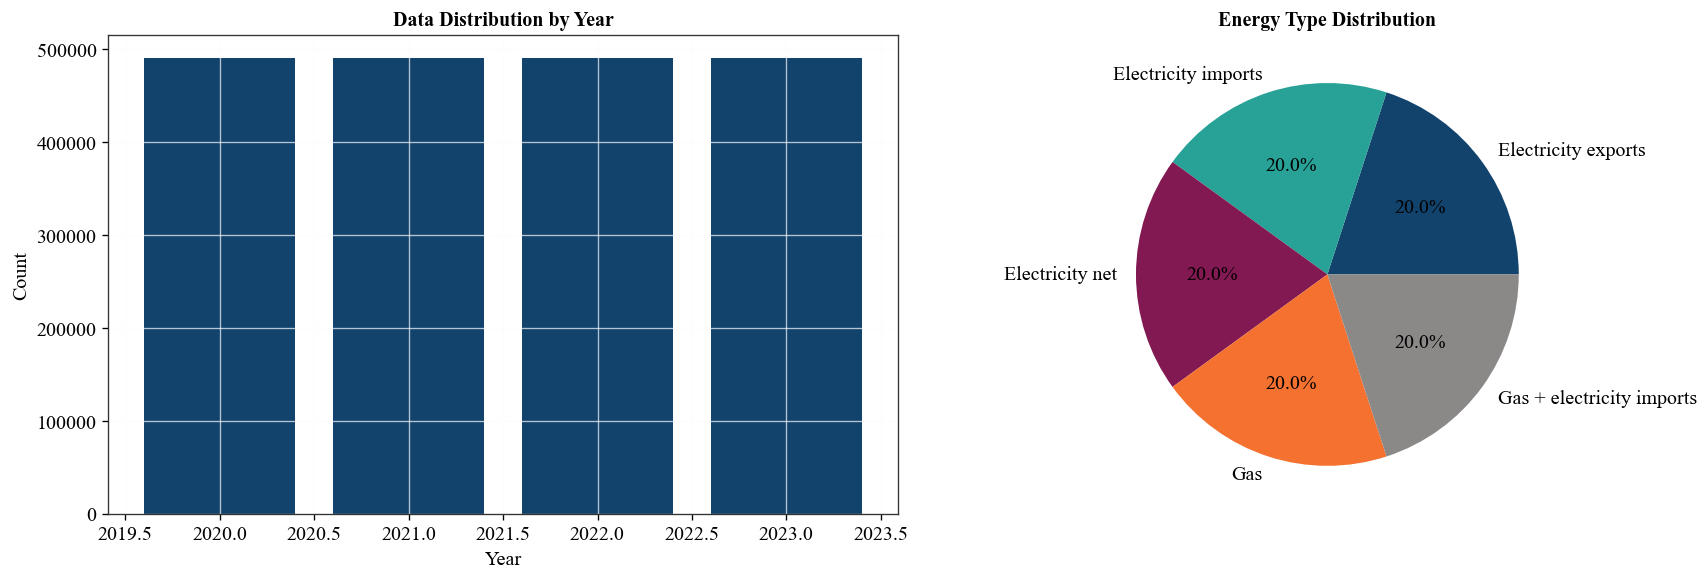

## 1a. Overview Statistics

Value
Statistic           
count      1,961,280
mean          110.76
std           204.31
min           -0.126
25%             2.45
50%            38.73
75%           108.60
max            1,286

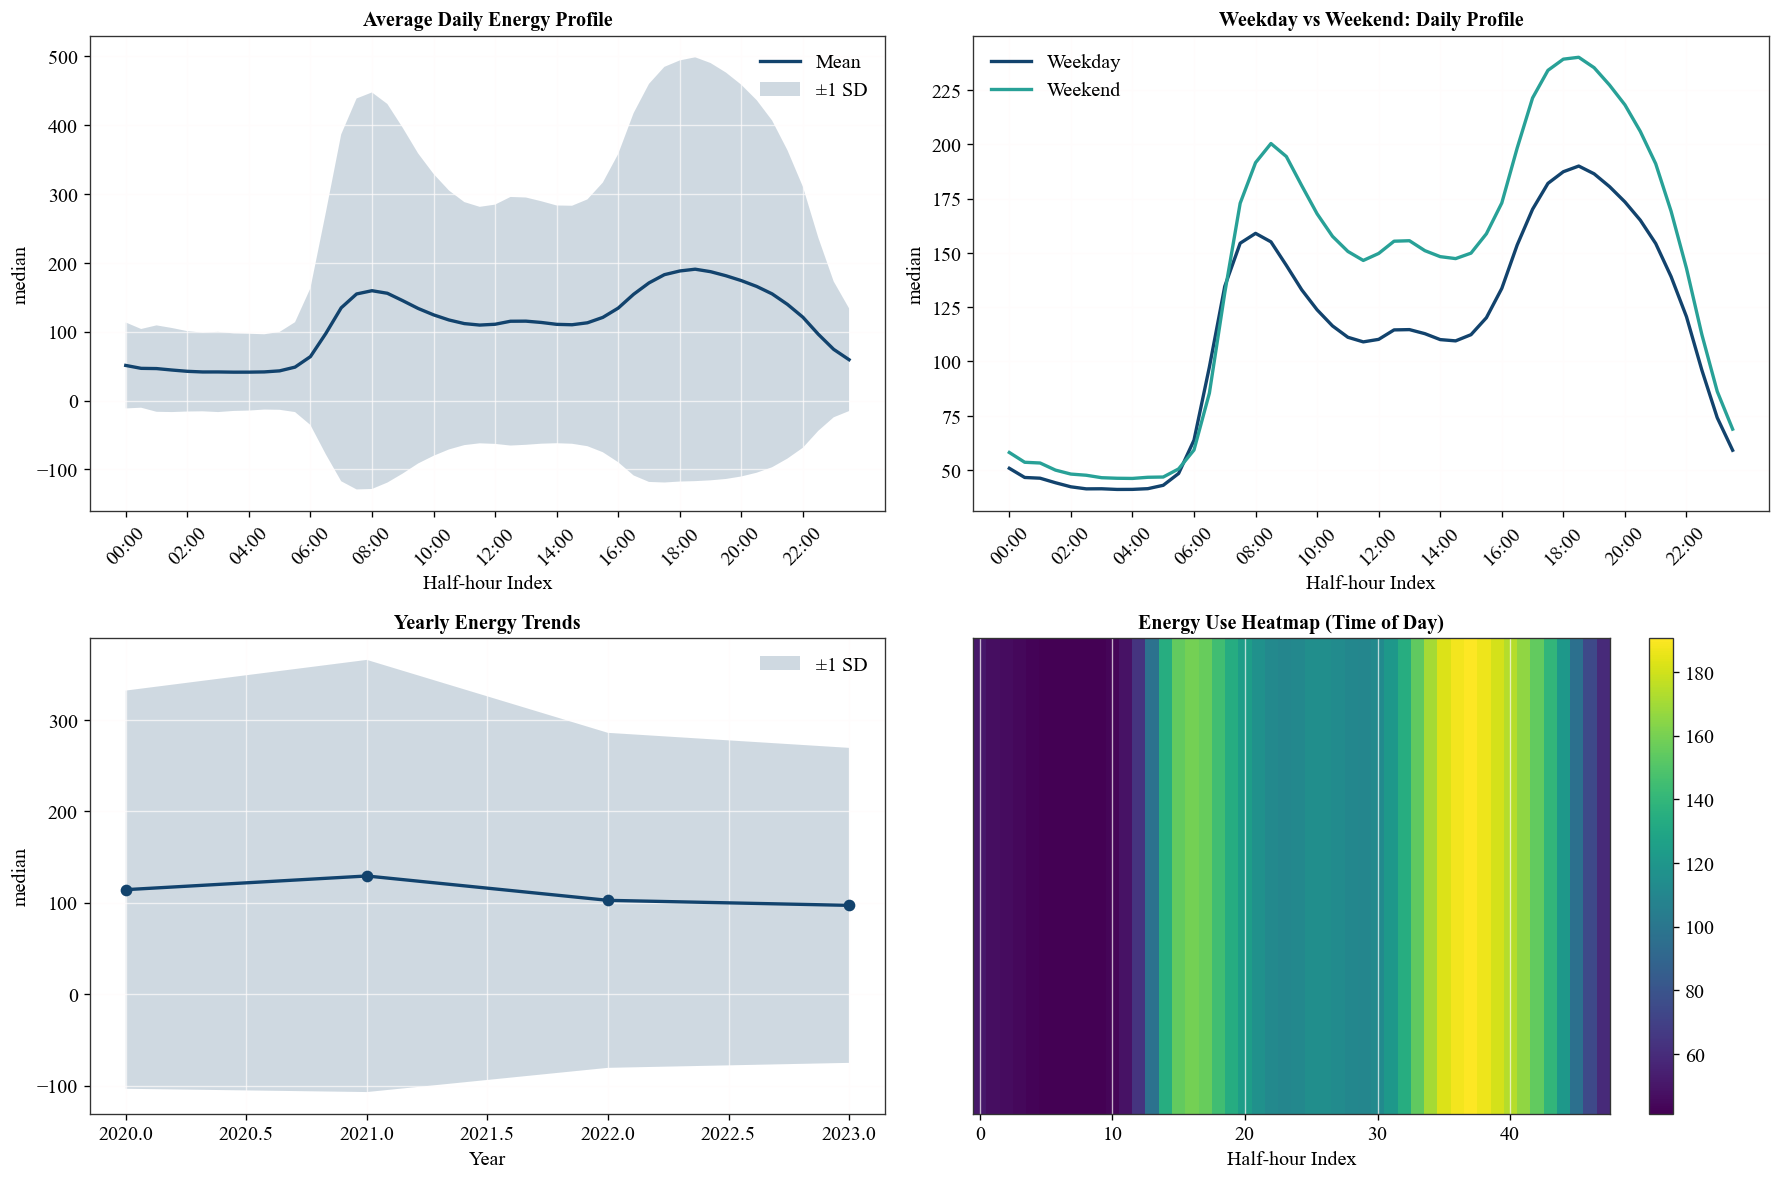

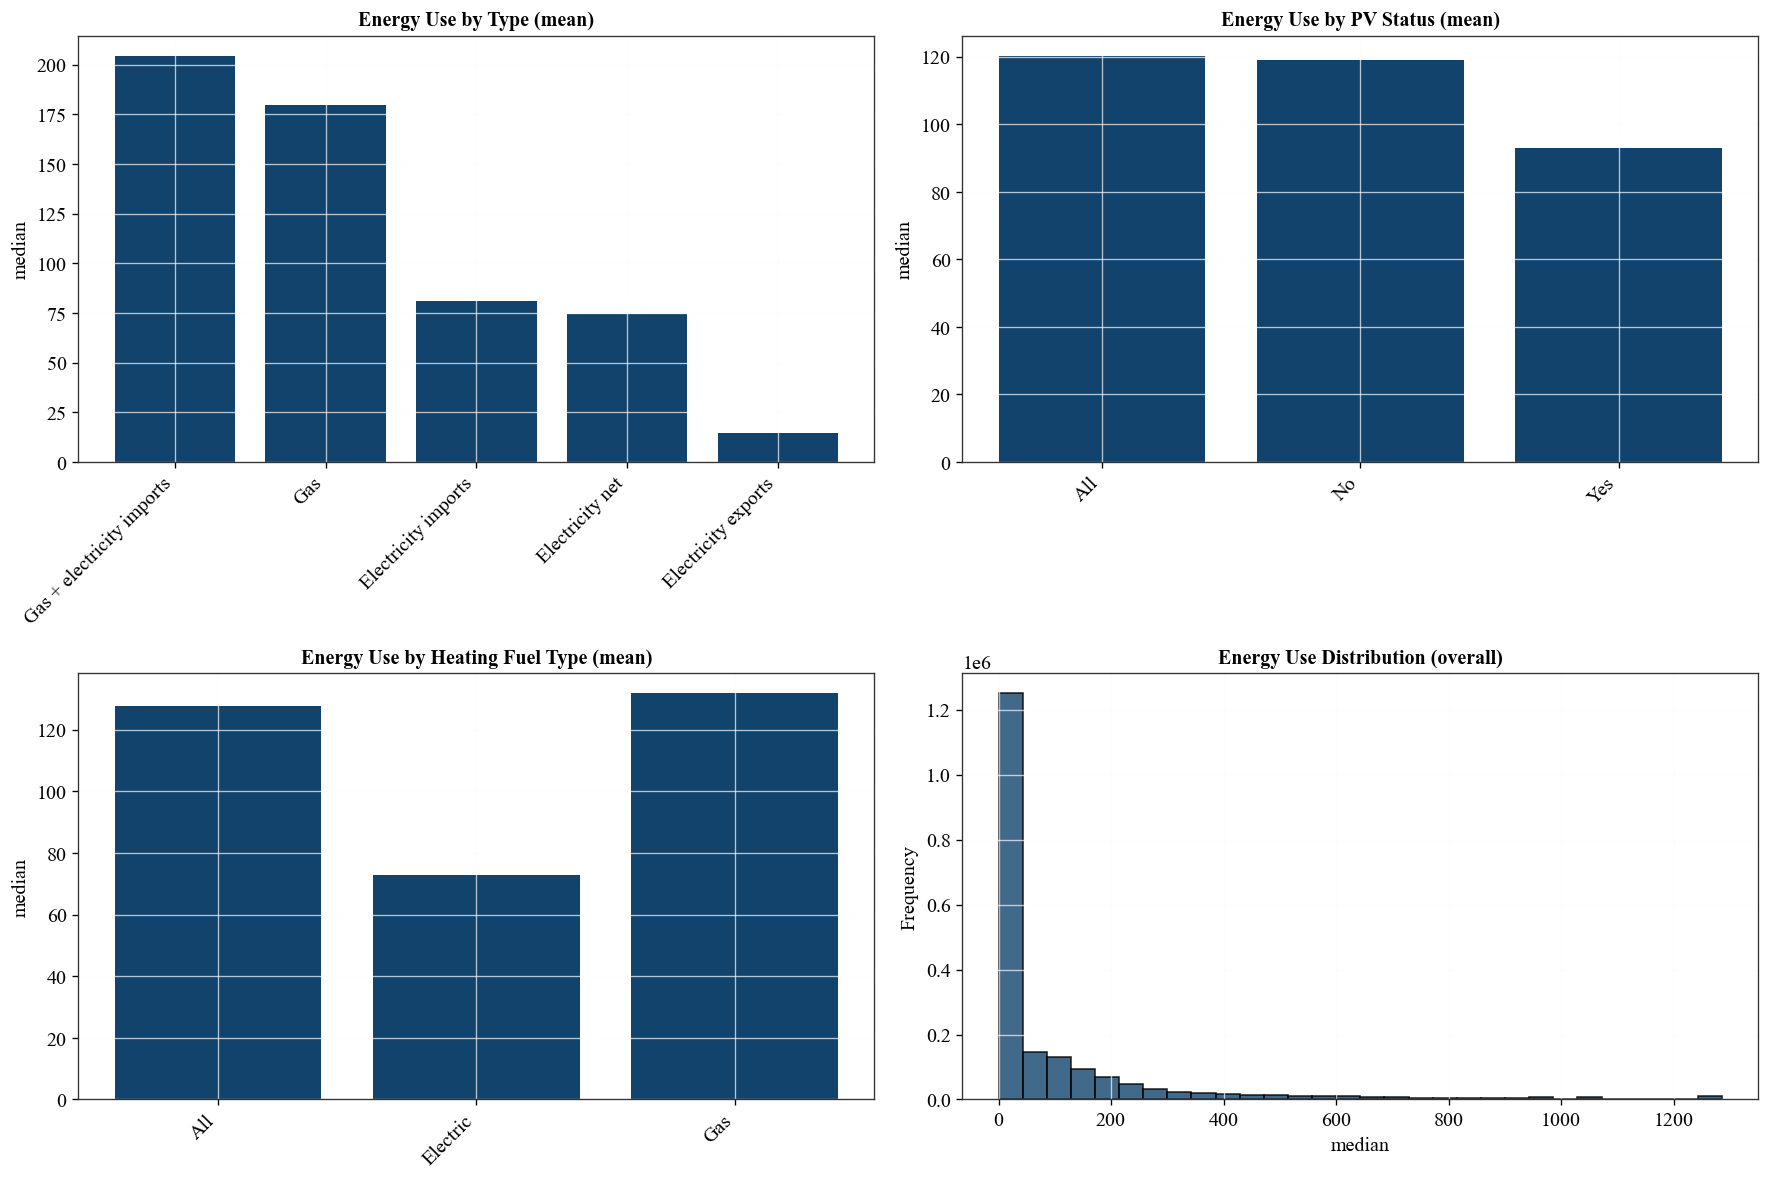

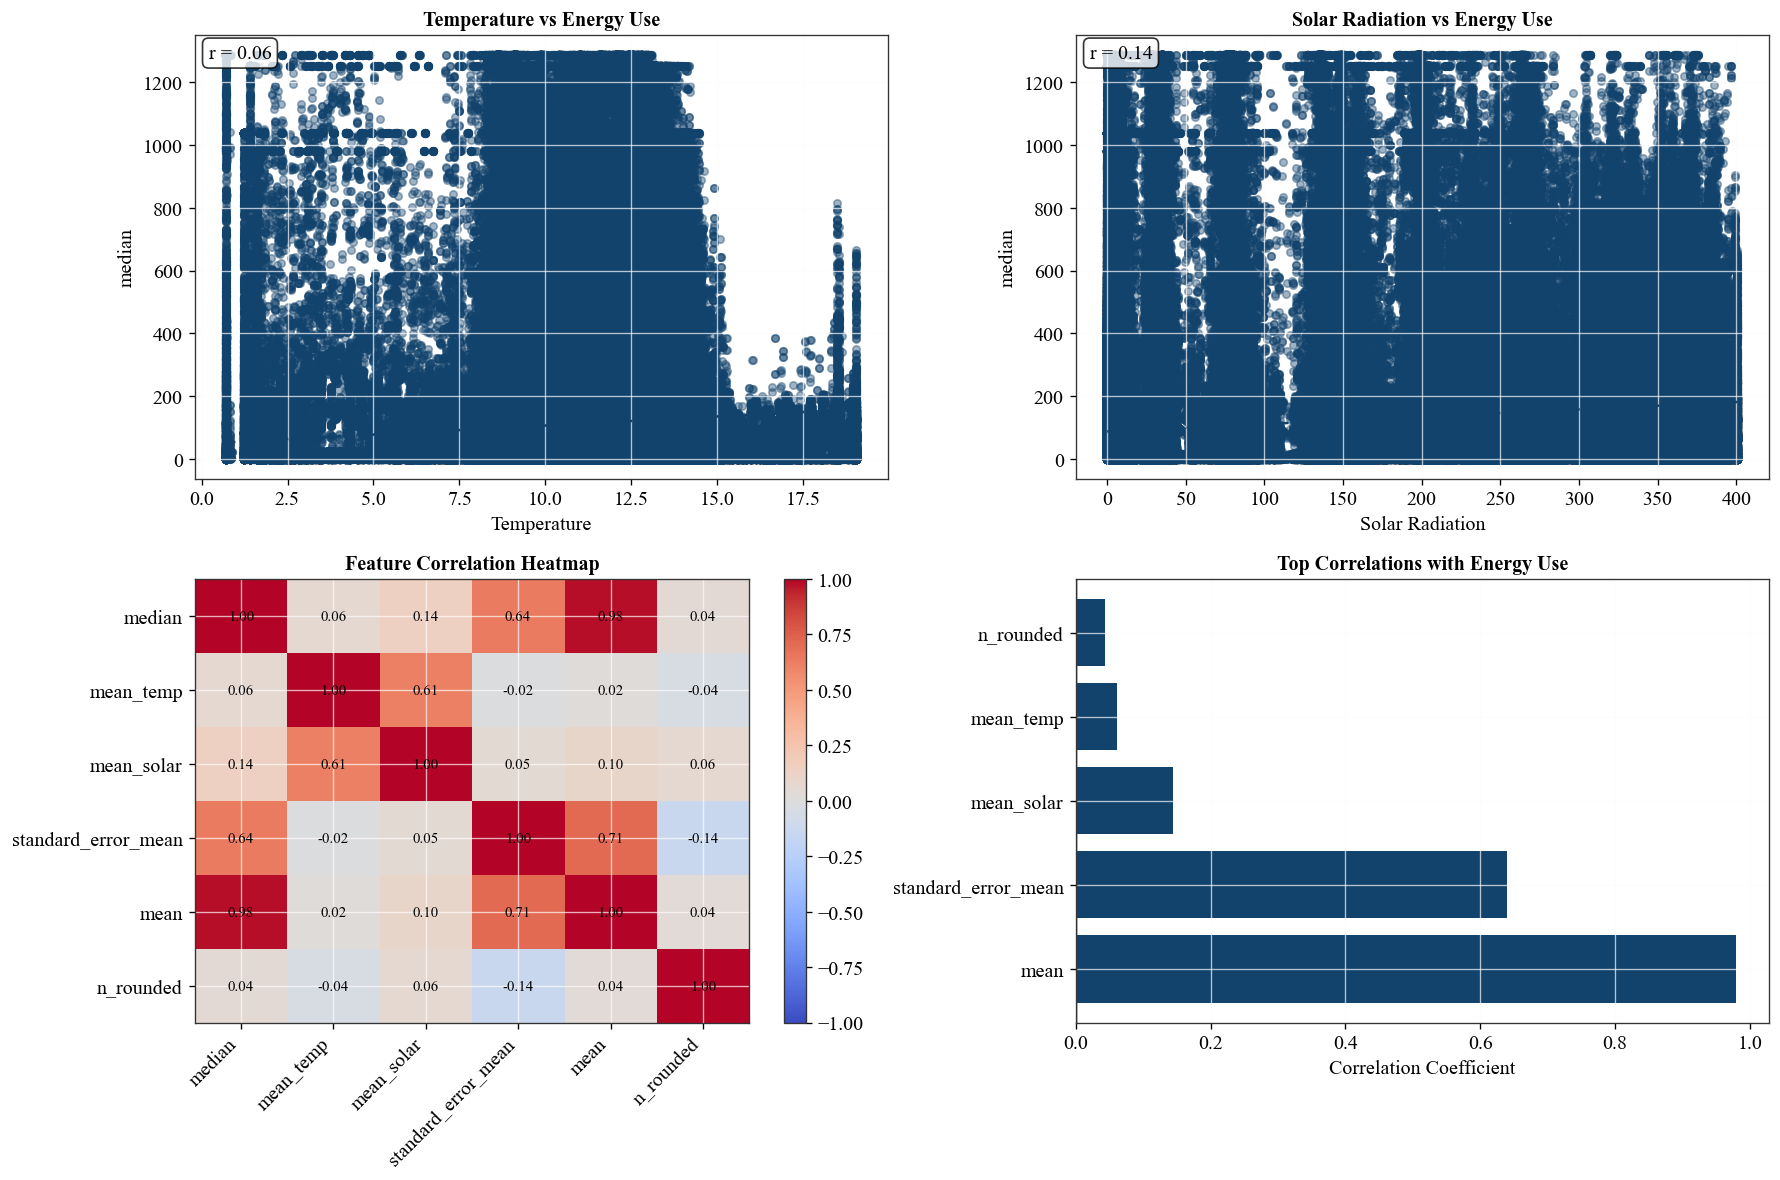

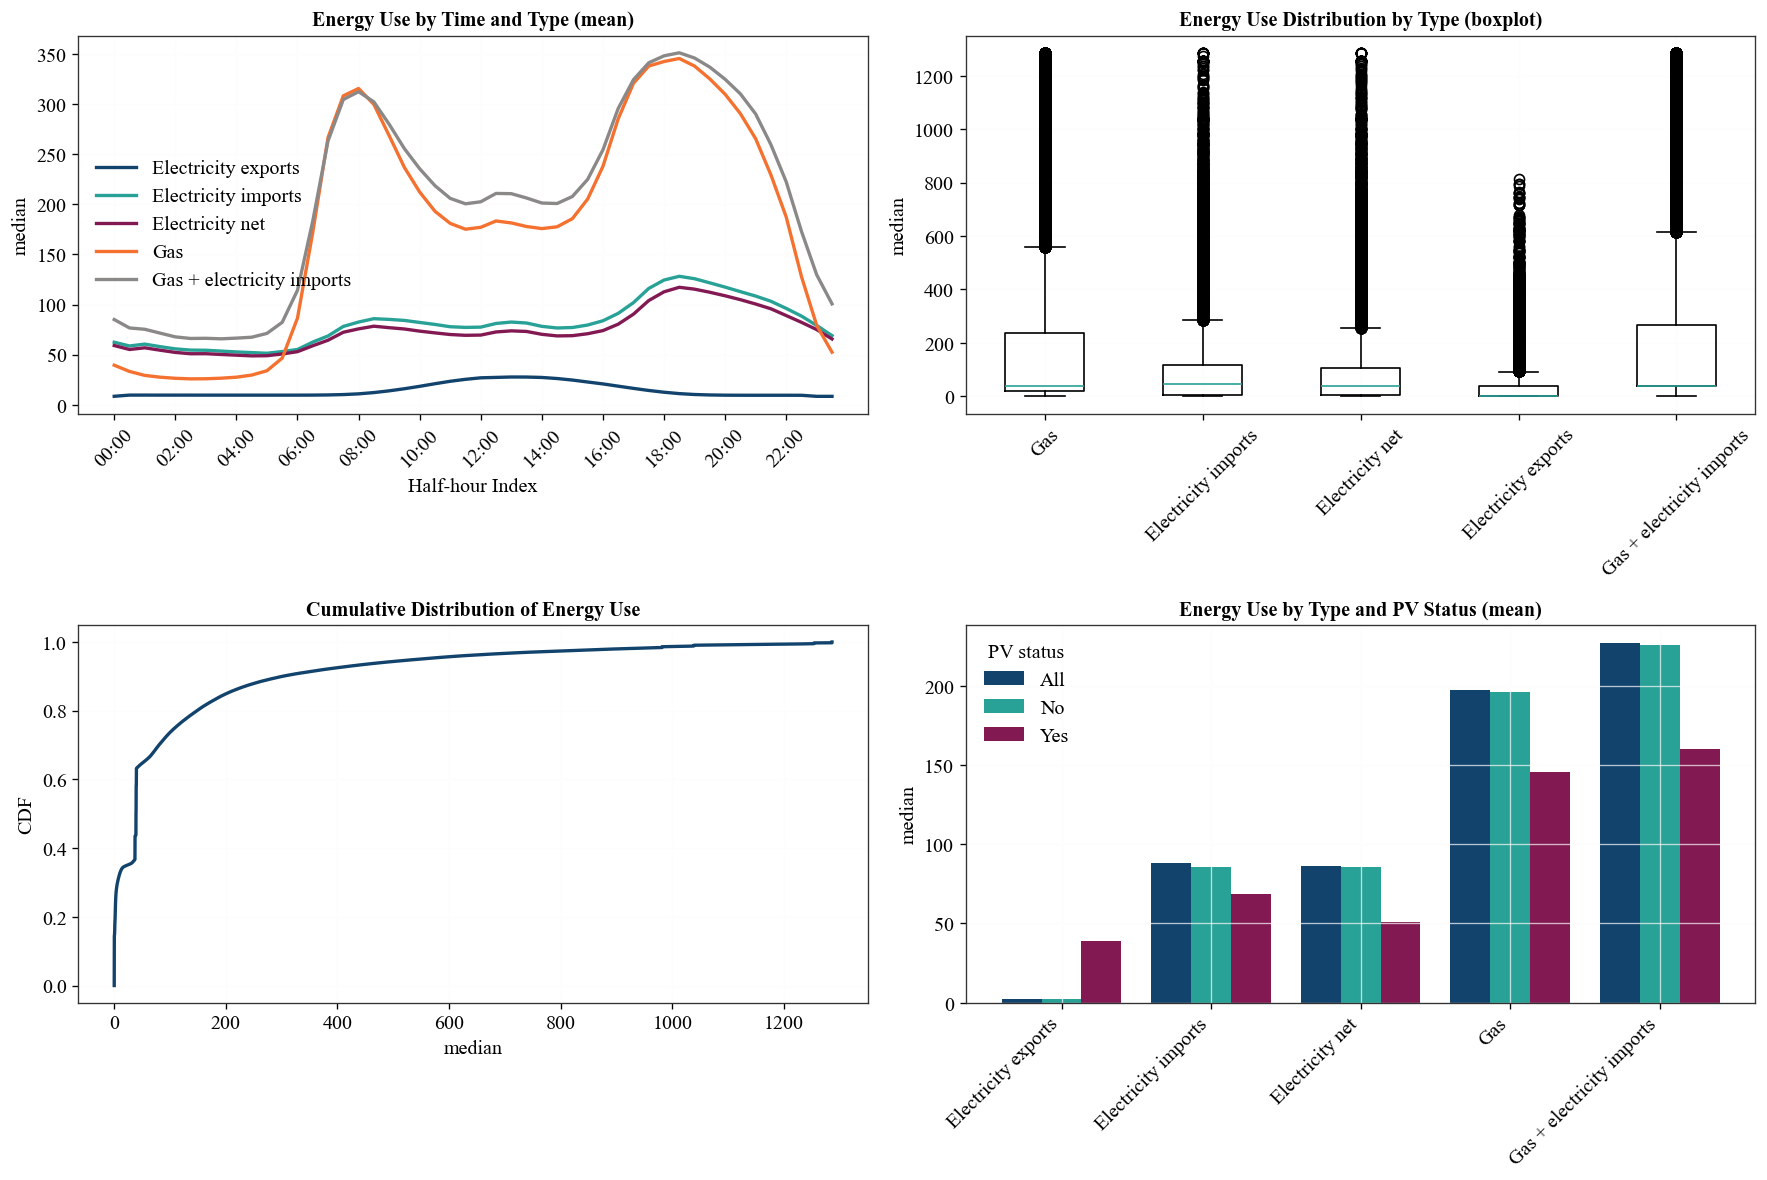

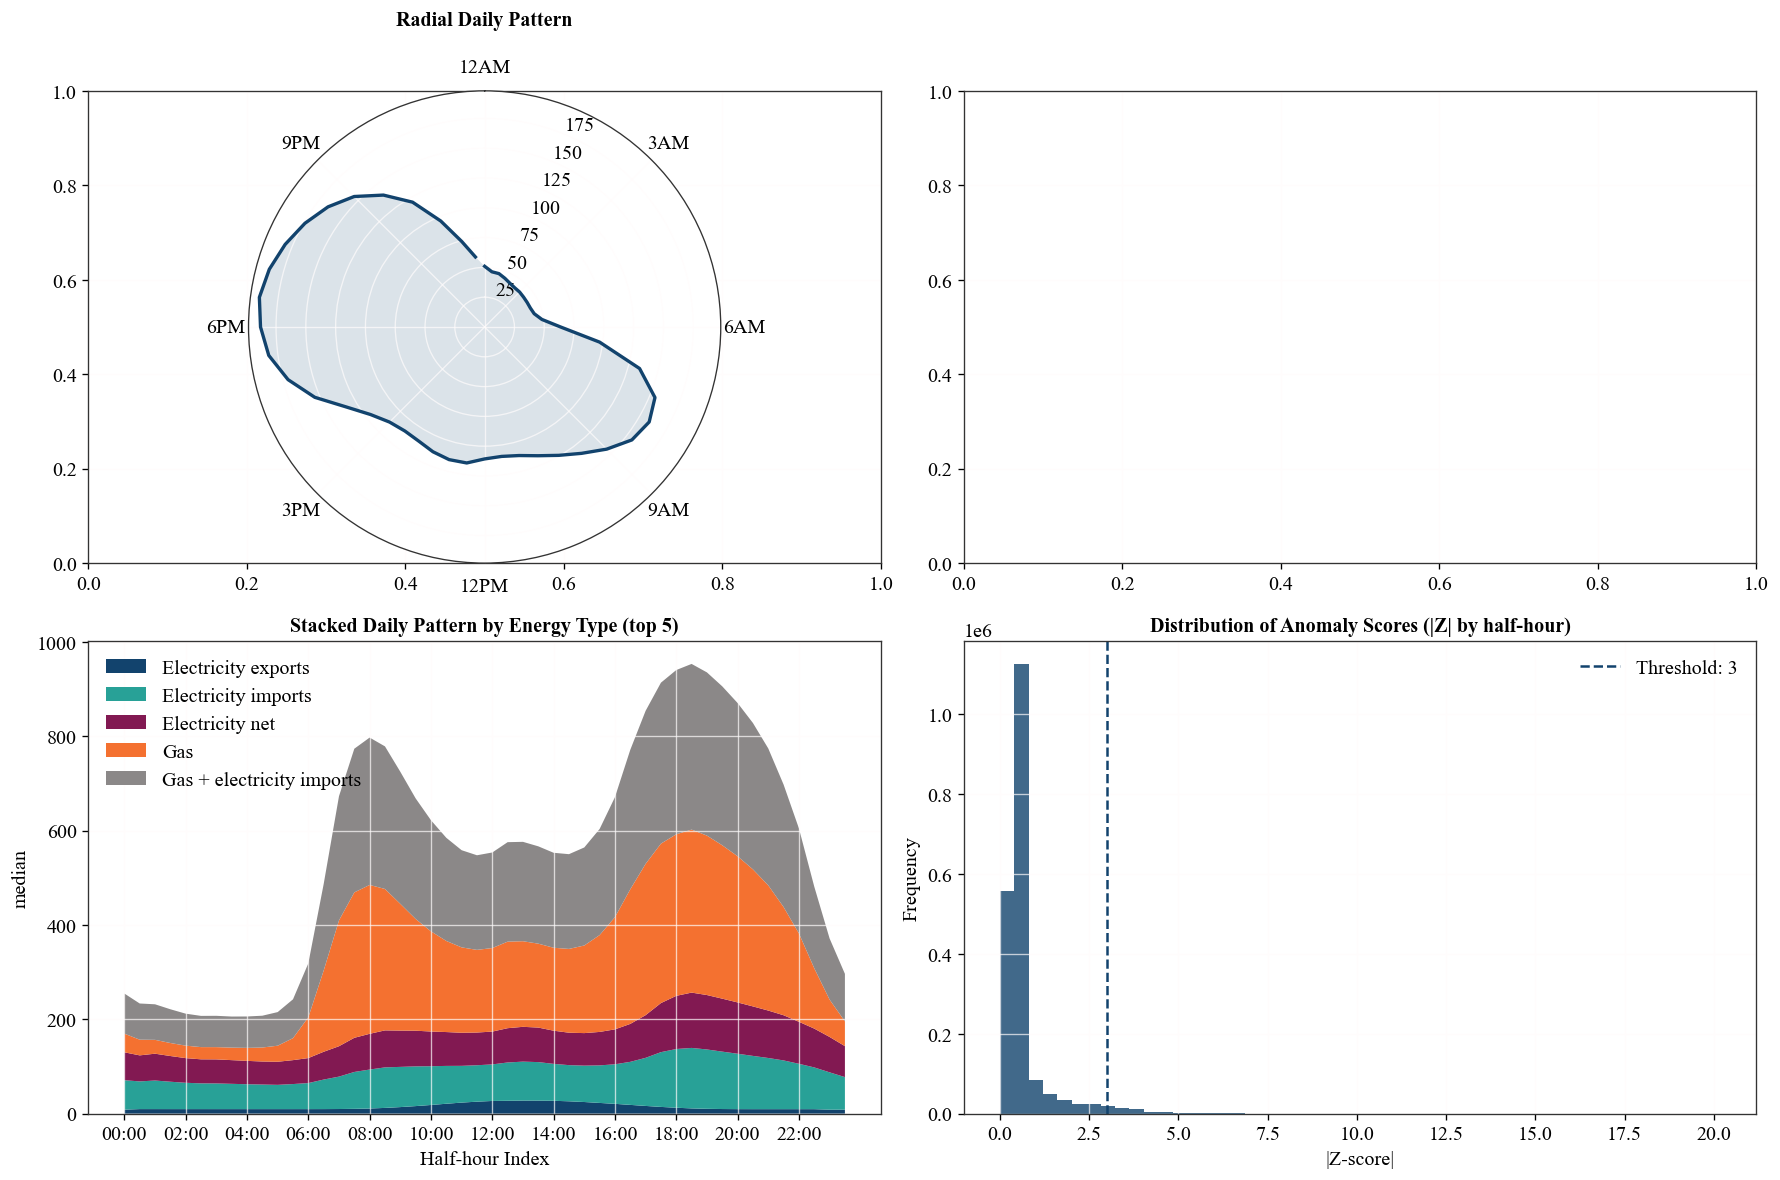

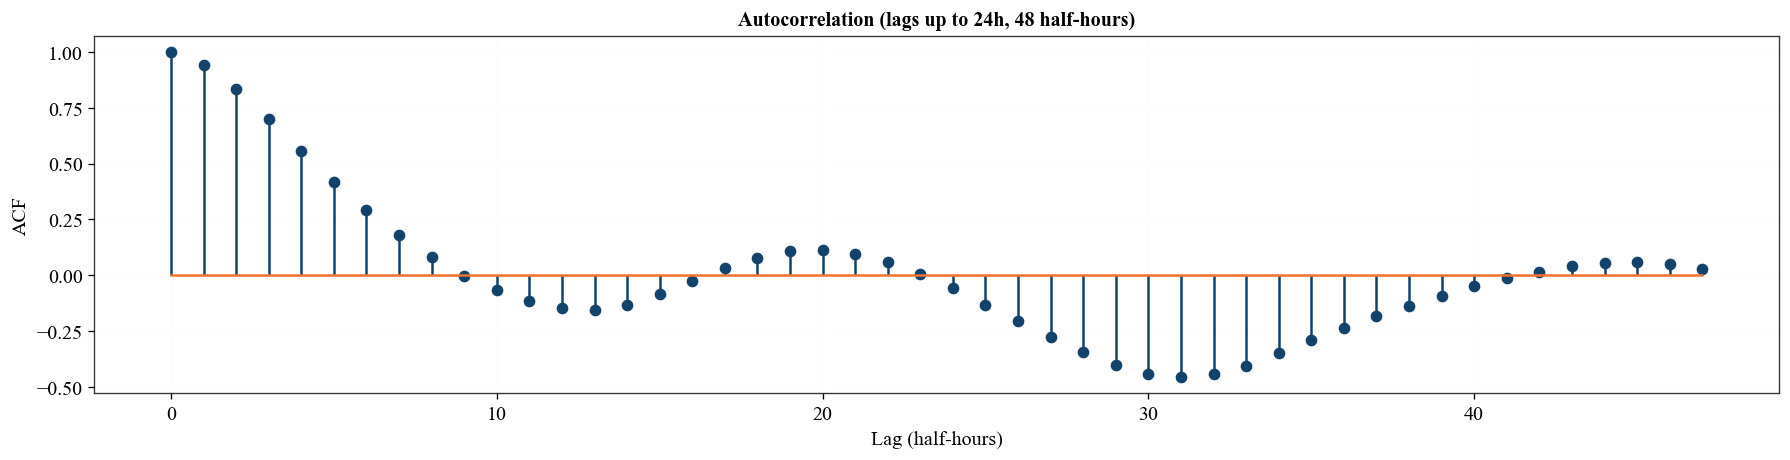

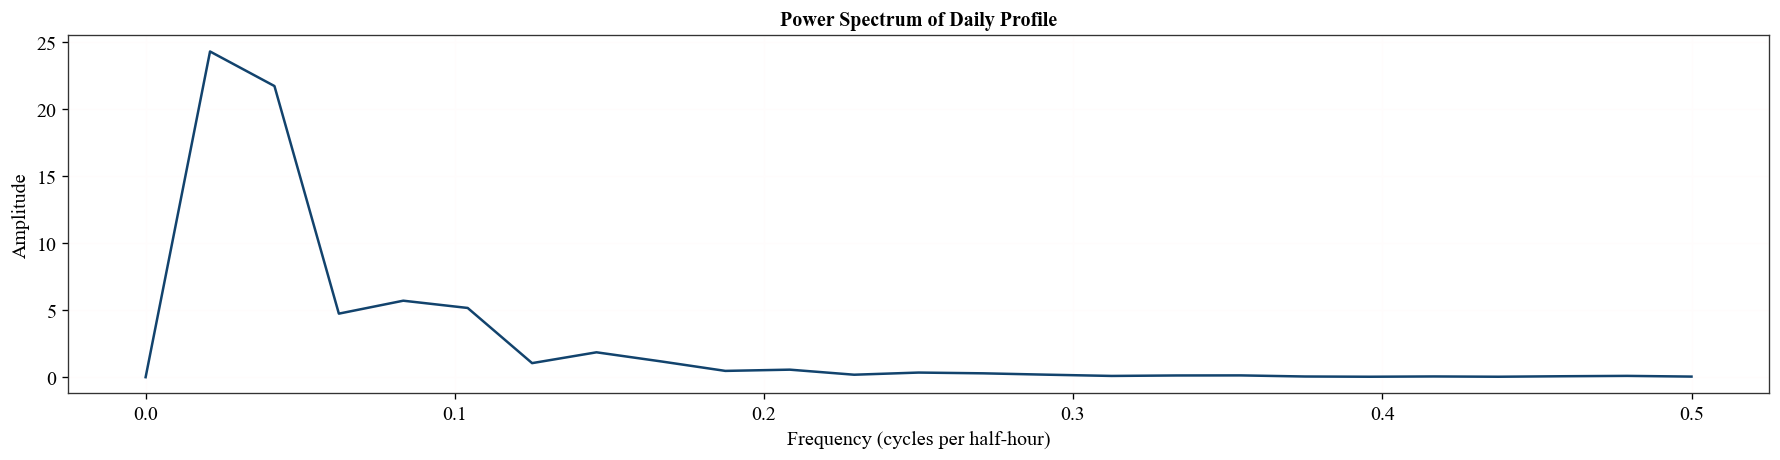

## 7. Statistical Metrics

Metric      Value
          Total Observations  1,961,280
                        Mean     110.76
                      Median      38.73
          Standard Deviation     204.31
                    Skewness       3.23
                    Kurtosis      11.56
                   Peak Time      18:30
                  Peak Value     190.62
                 Load Factor     58.11%
     Temperature Correlation      0.062
           Solar Correlation      0.144
  Weekend-Weekday Difference     24.76%

## 8. Regression Models

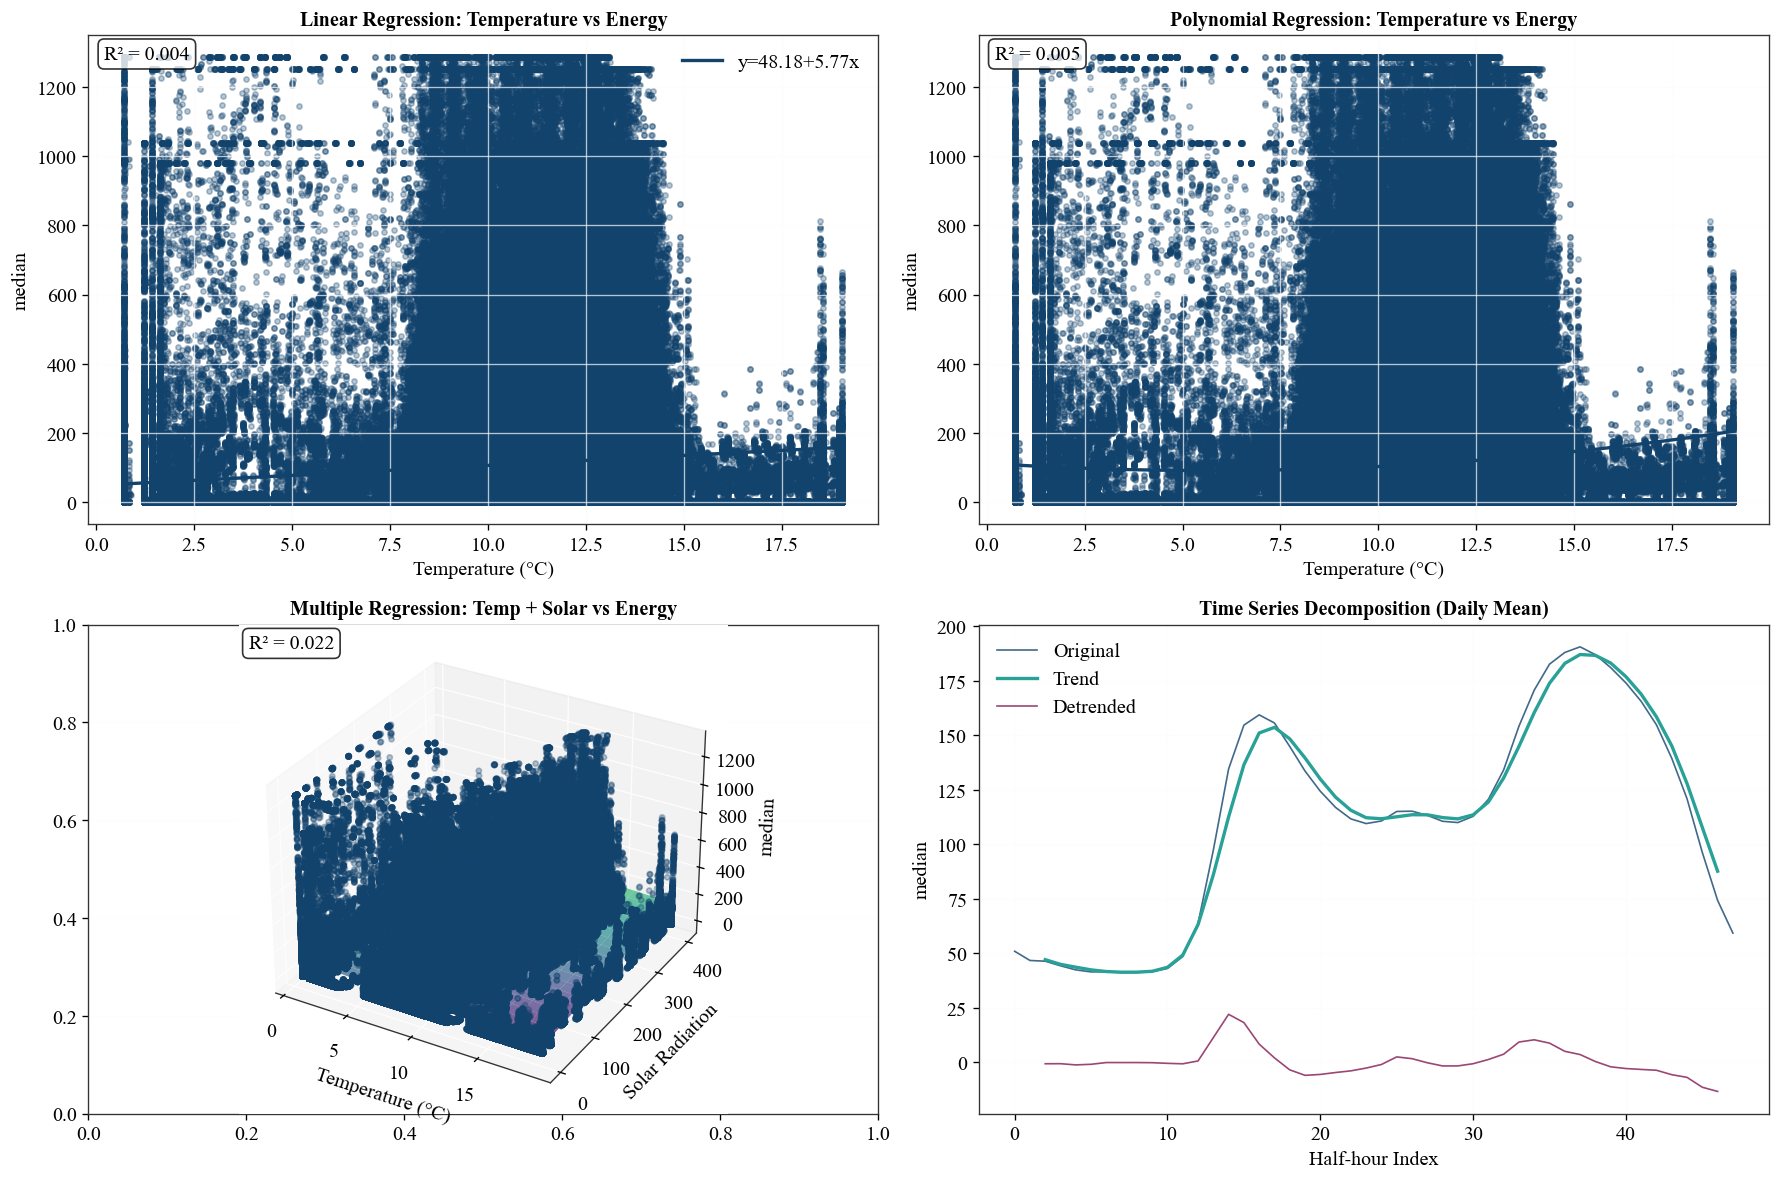

## 9. Summary and Insights

1. Peak energy consumption occurs at 18:30.

2. Weekend consumption is higher than weekday consumption.

3. Annual energy consumption has decreased by 15.0% over the period.

### Dashboard Complete

In [ ]:
run_serl_dashboard()  

📂 loading & preprocessing serl data...
✅ combined shape: (1961280, 26)
📊 creating matrices for each quantity...
Found 5 unique quantities: ['electricity exports', 'electricity imports', 'electricity net', 'gas', 'gas + electricity imports']
Processing quantity: electricity exports


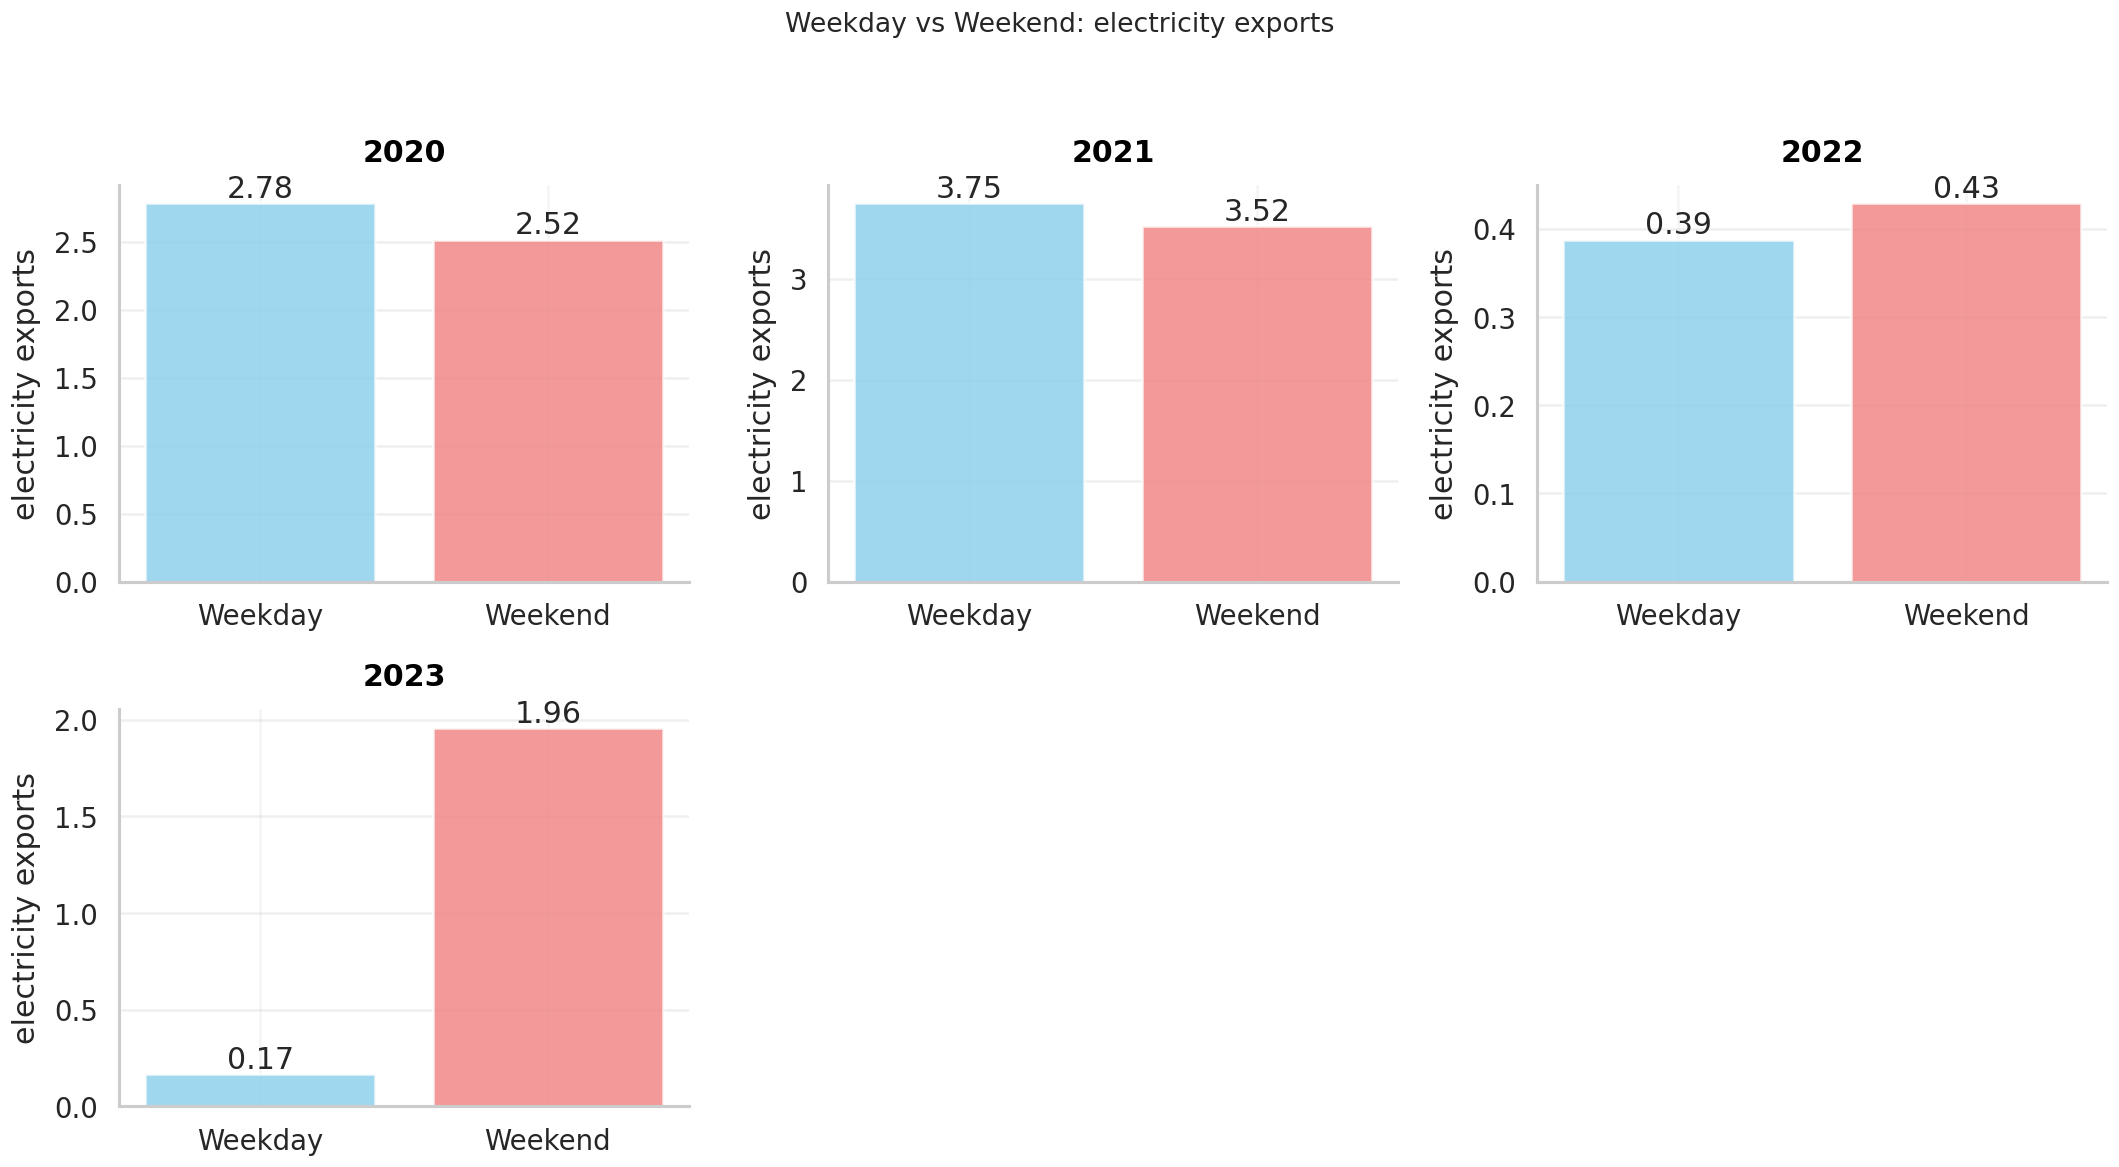

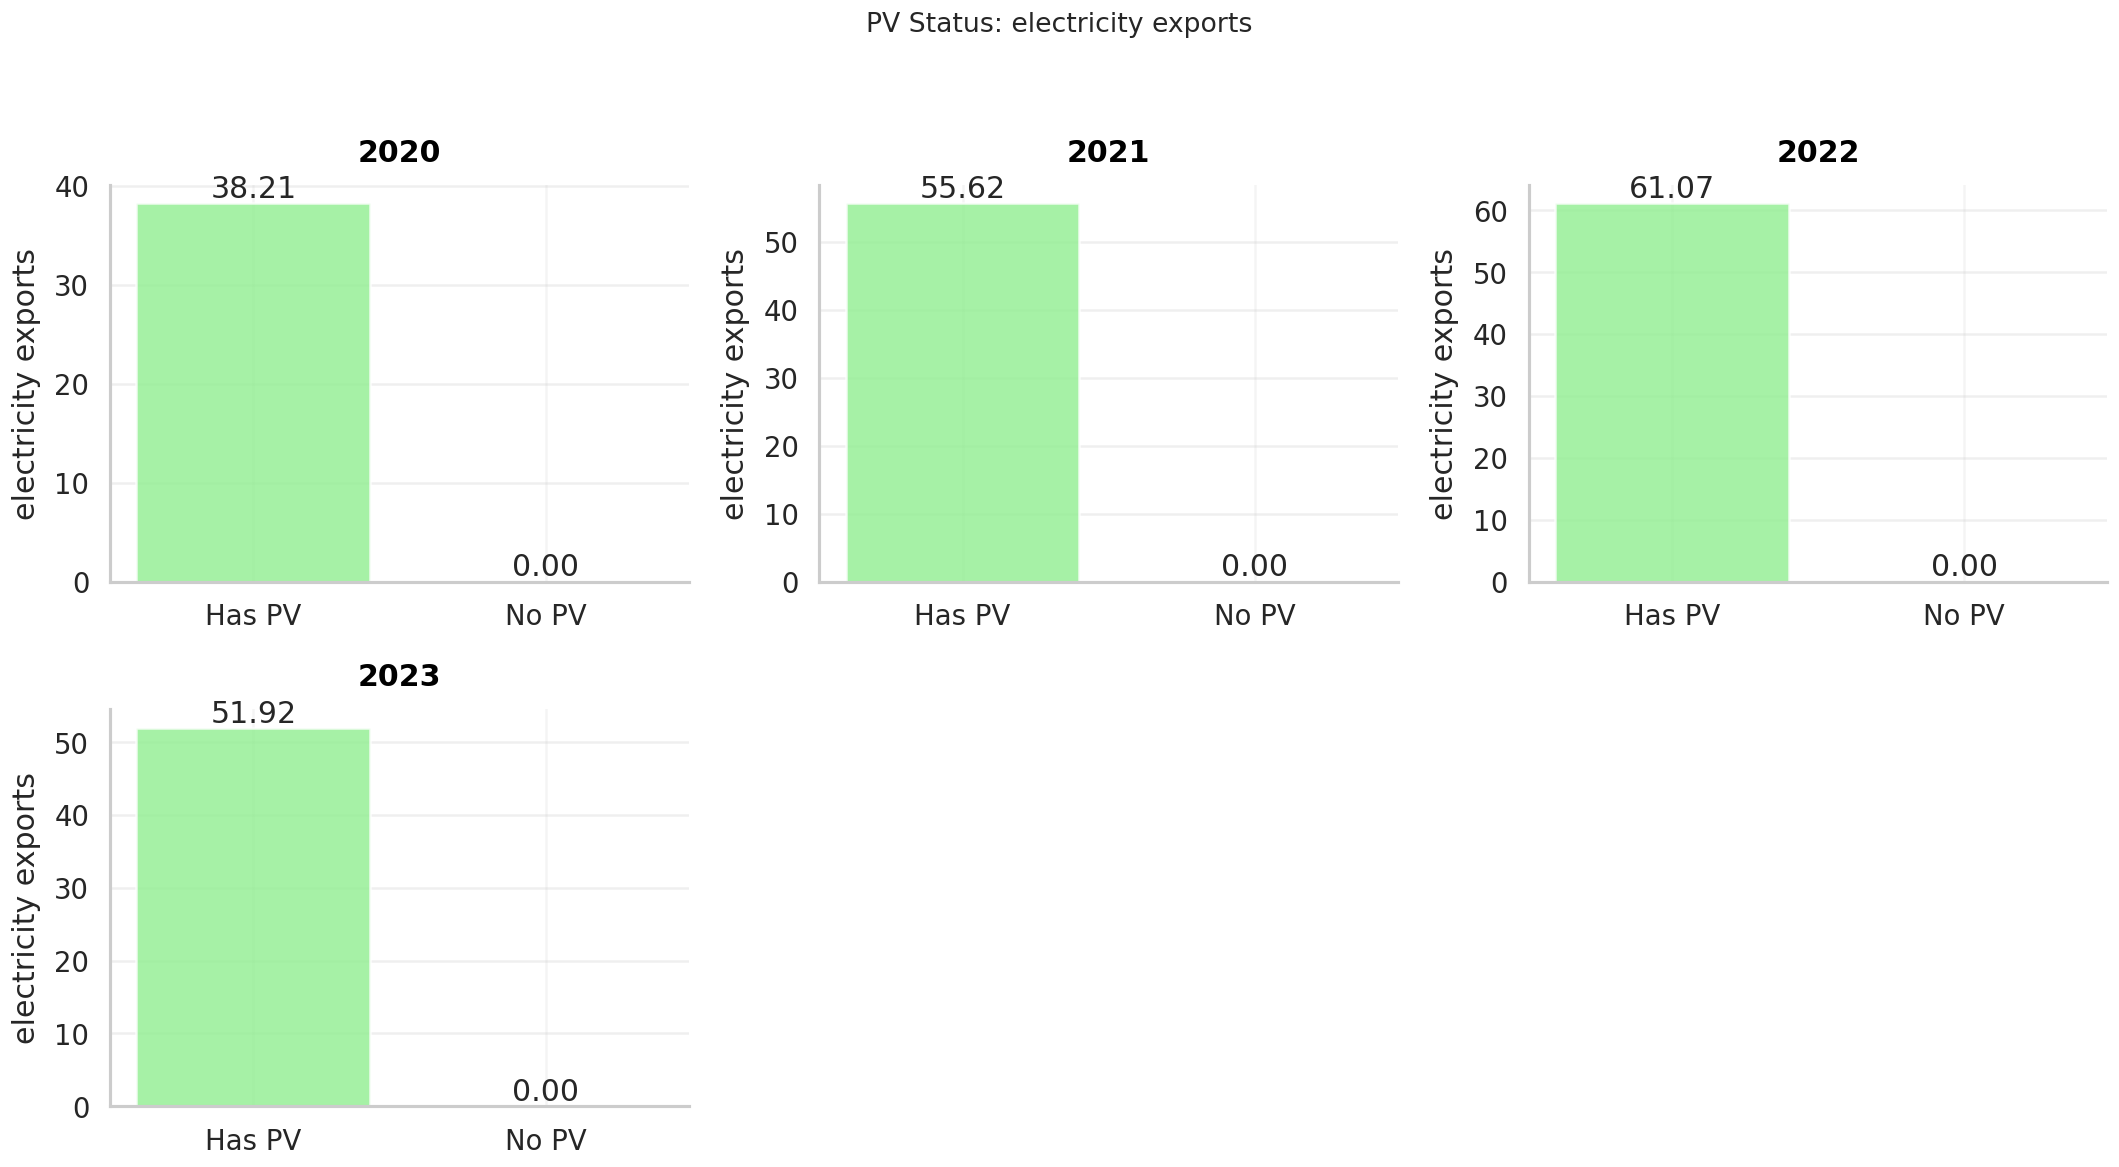

Processing quantity: electricity imports


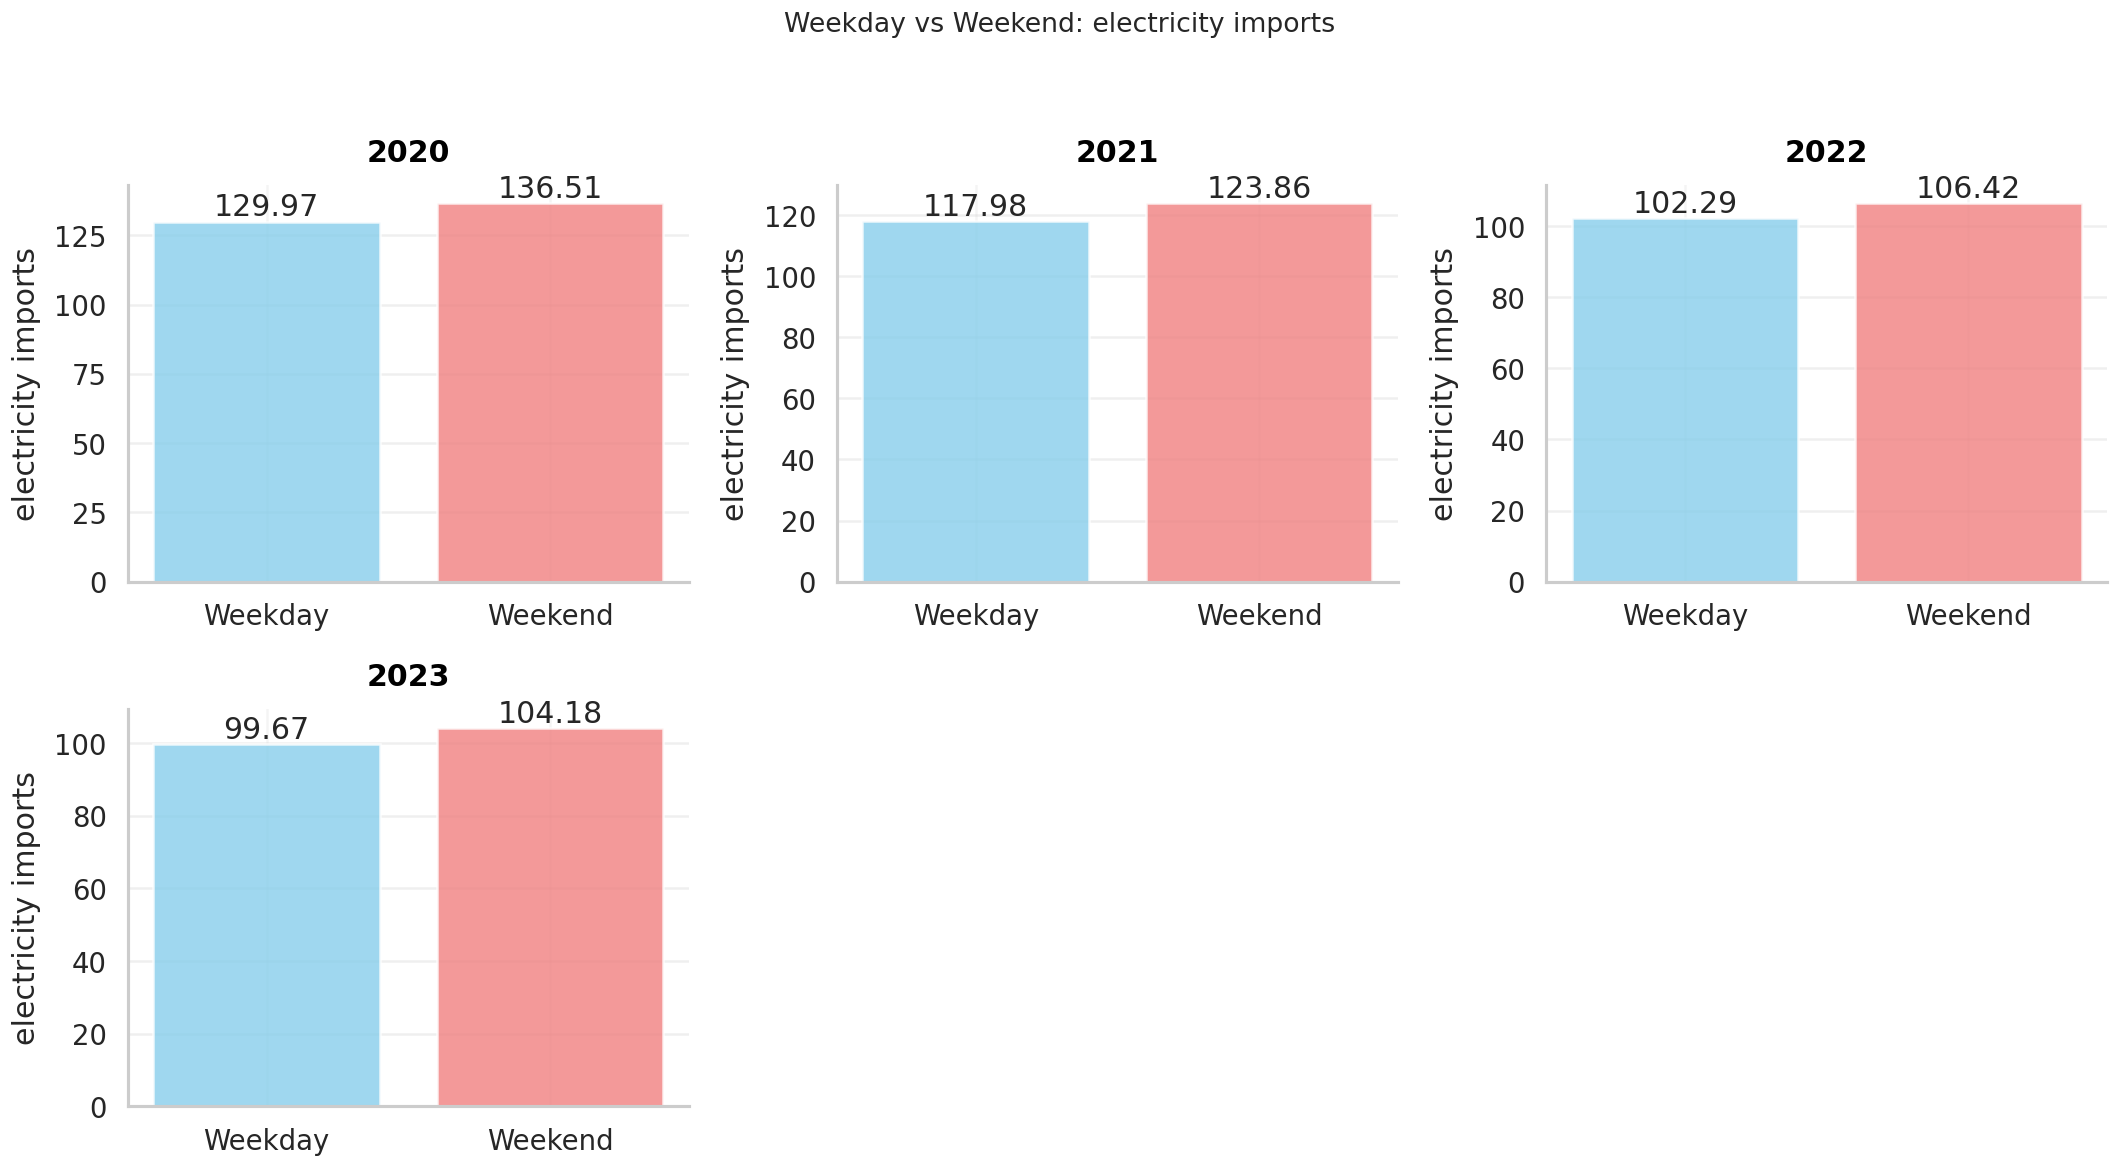

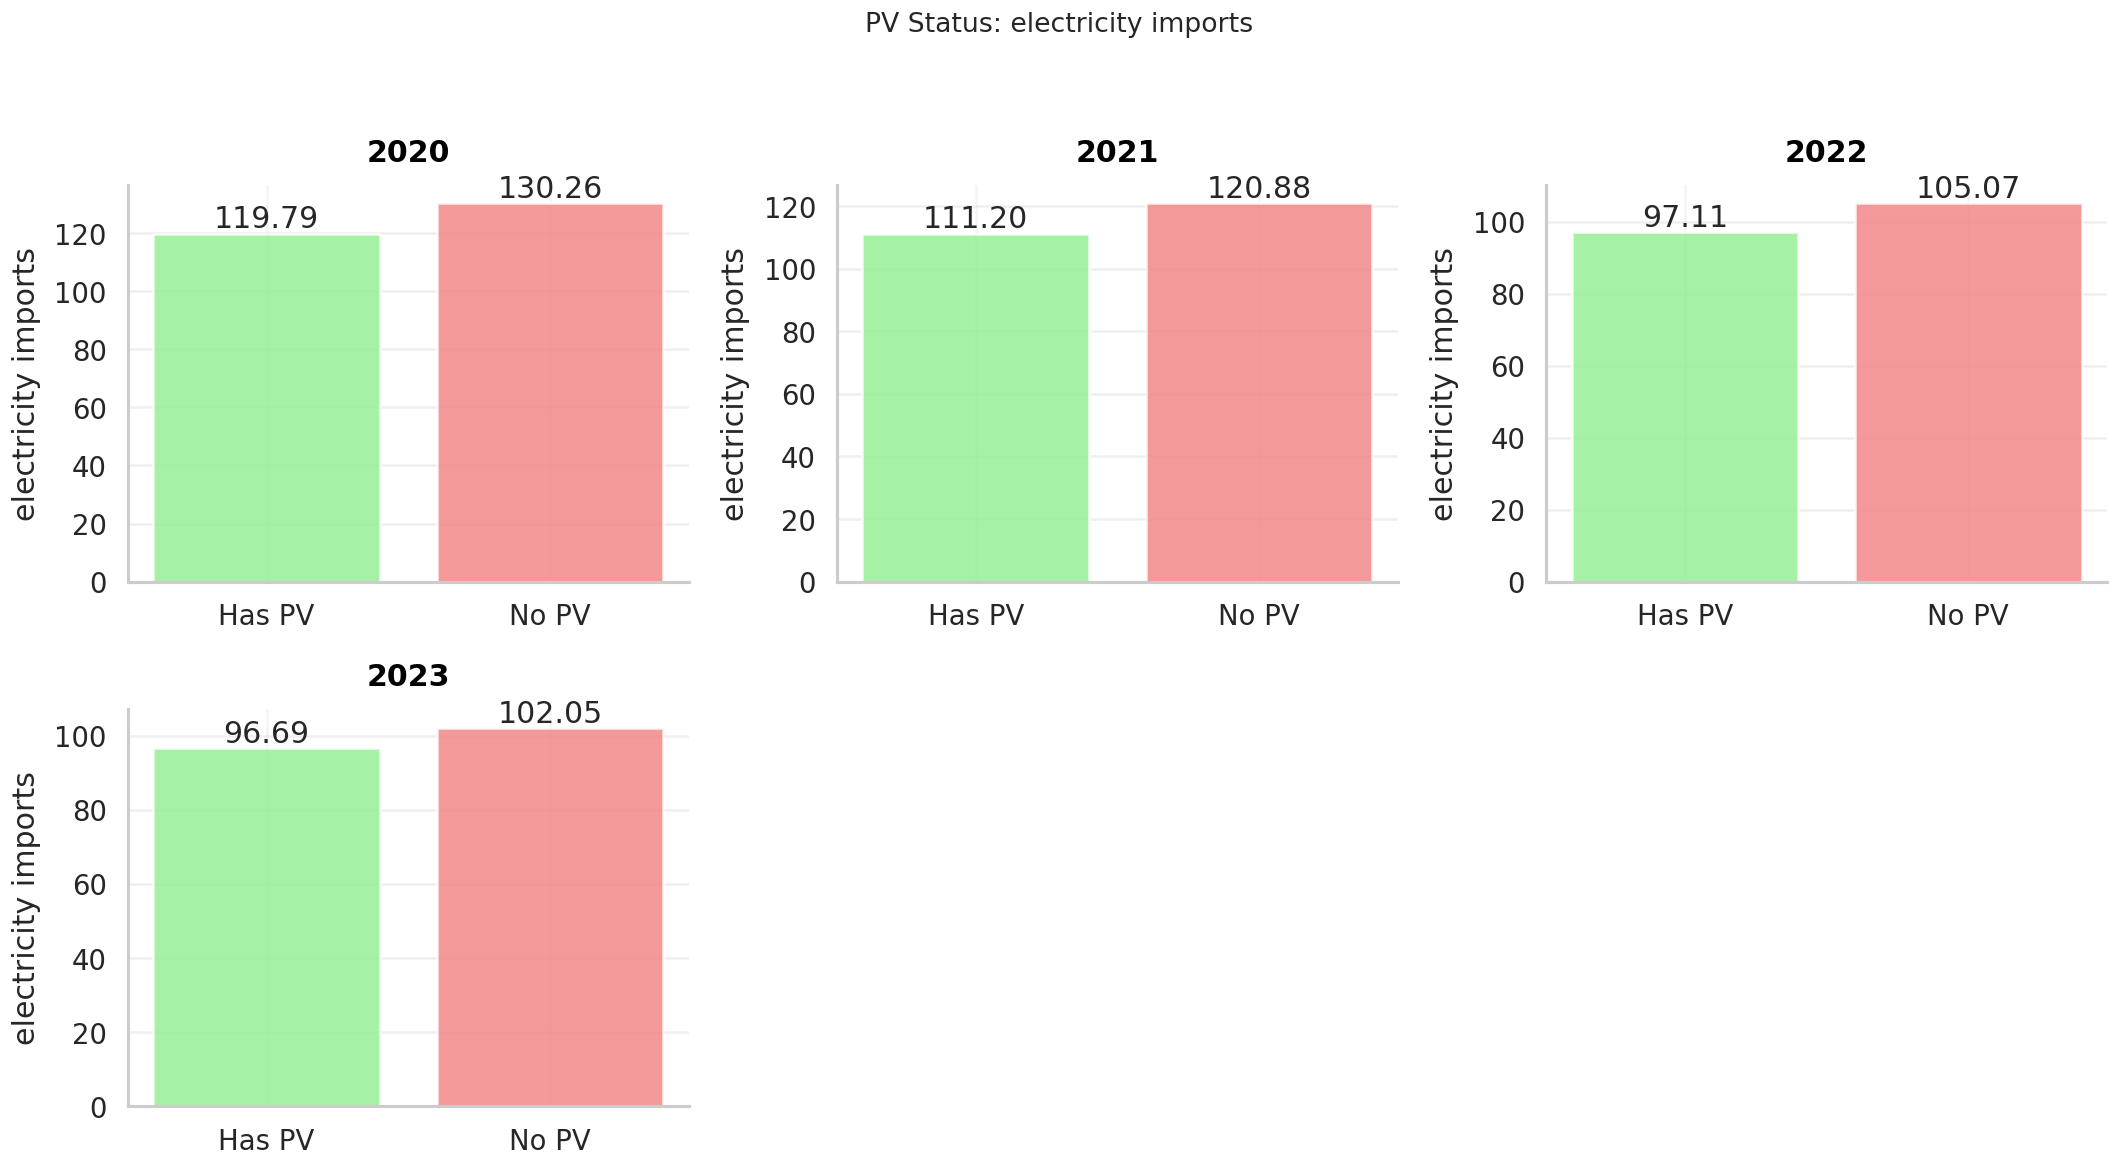

Processing quantity: electricity net


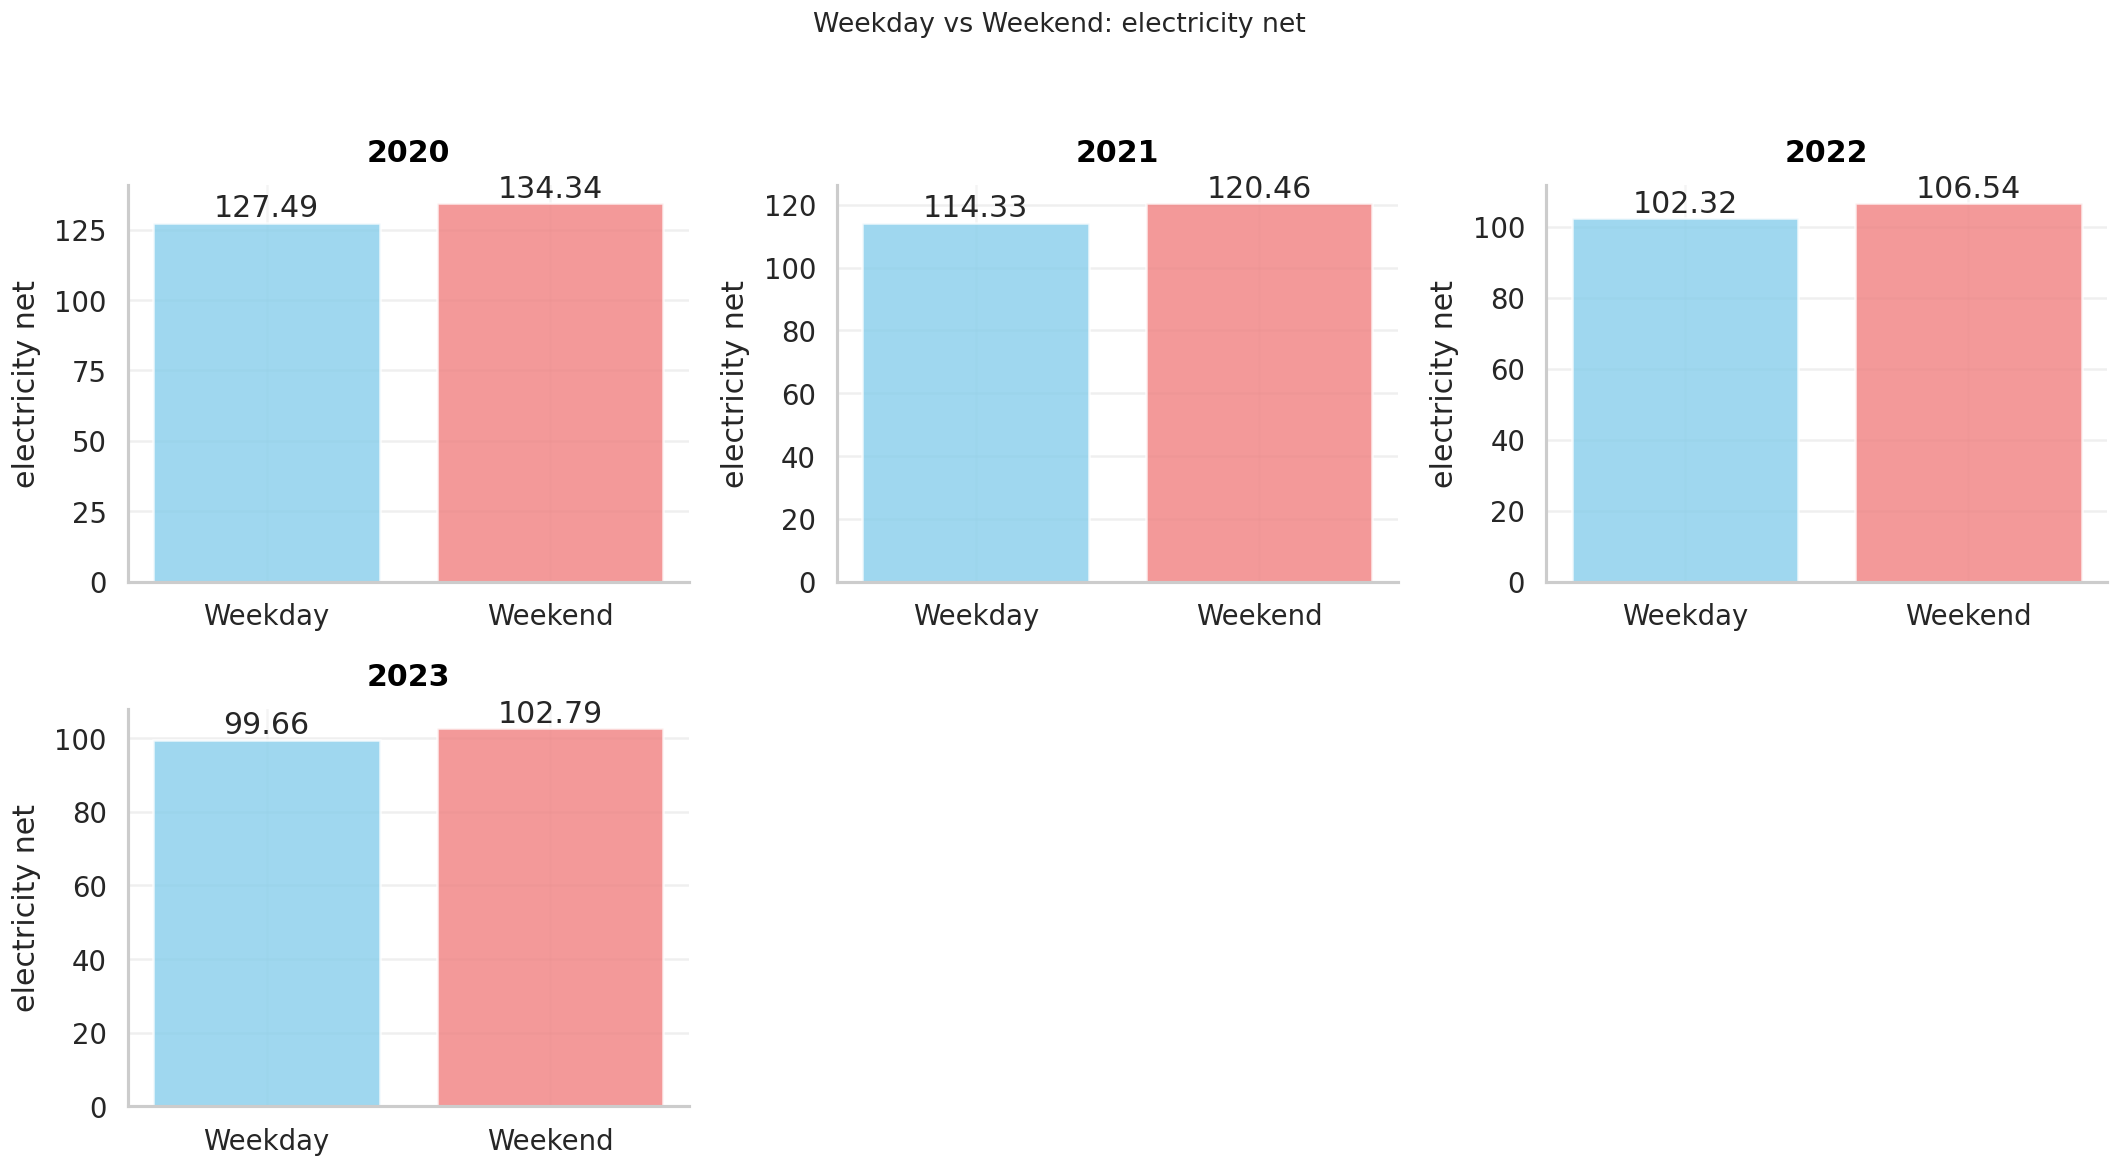

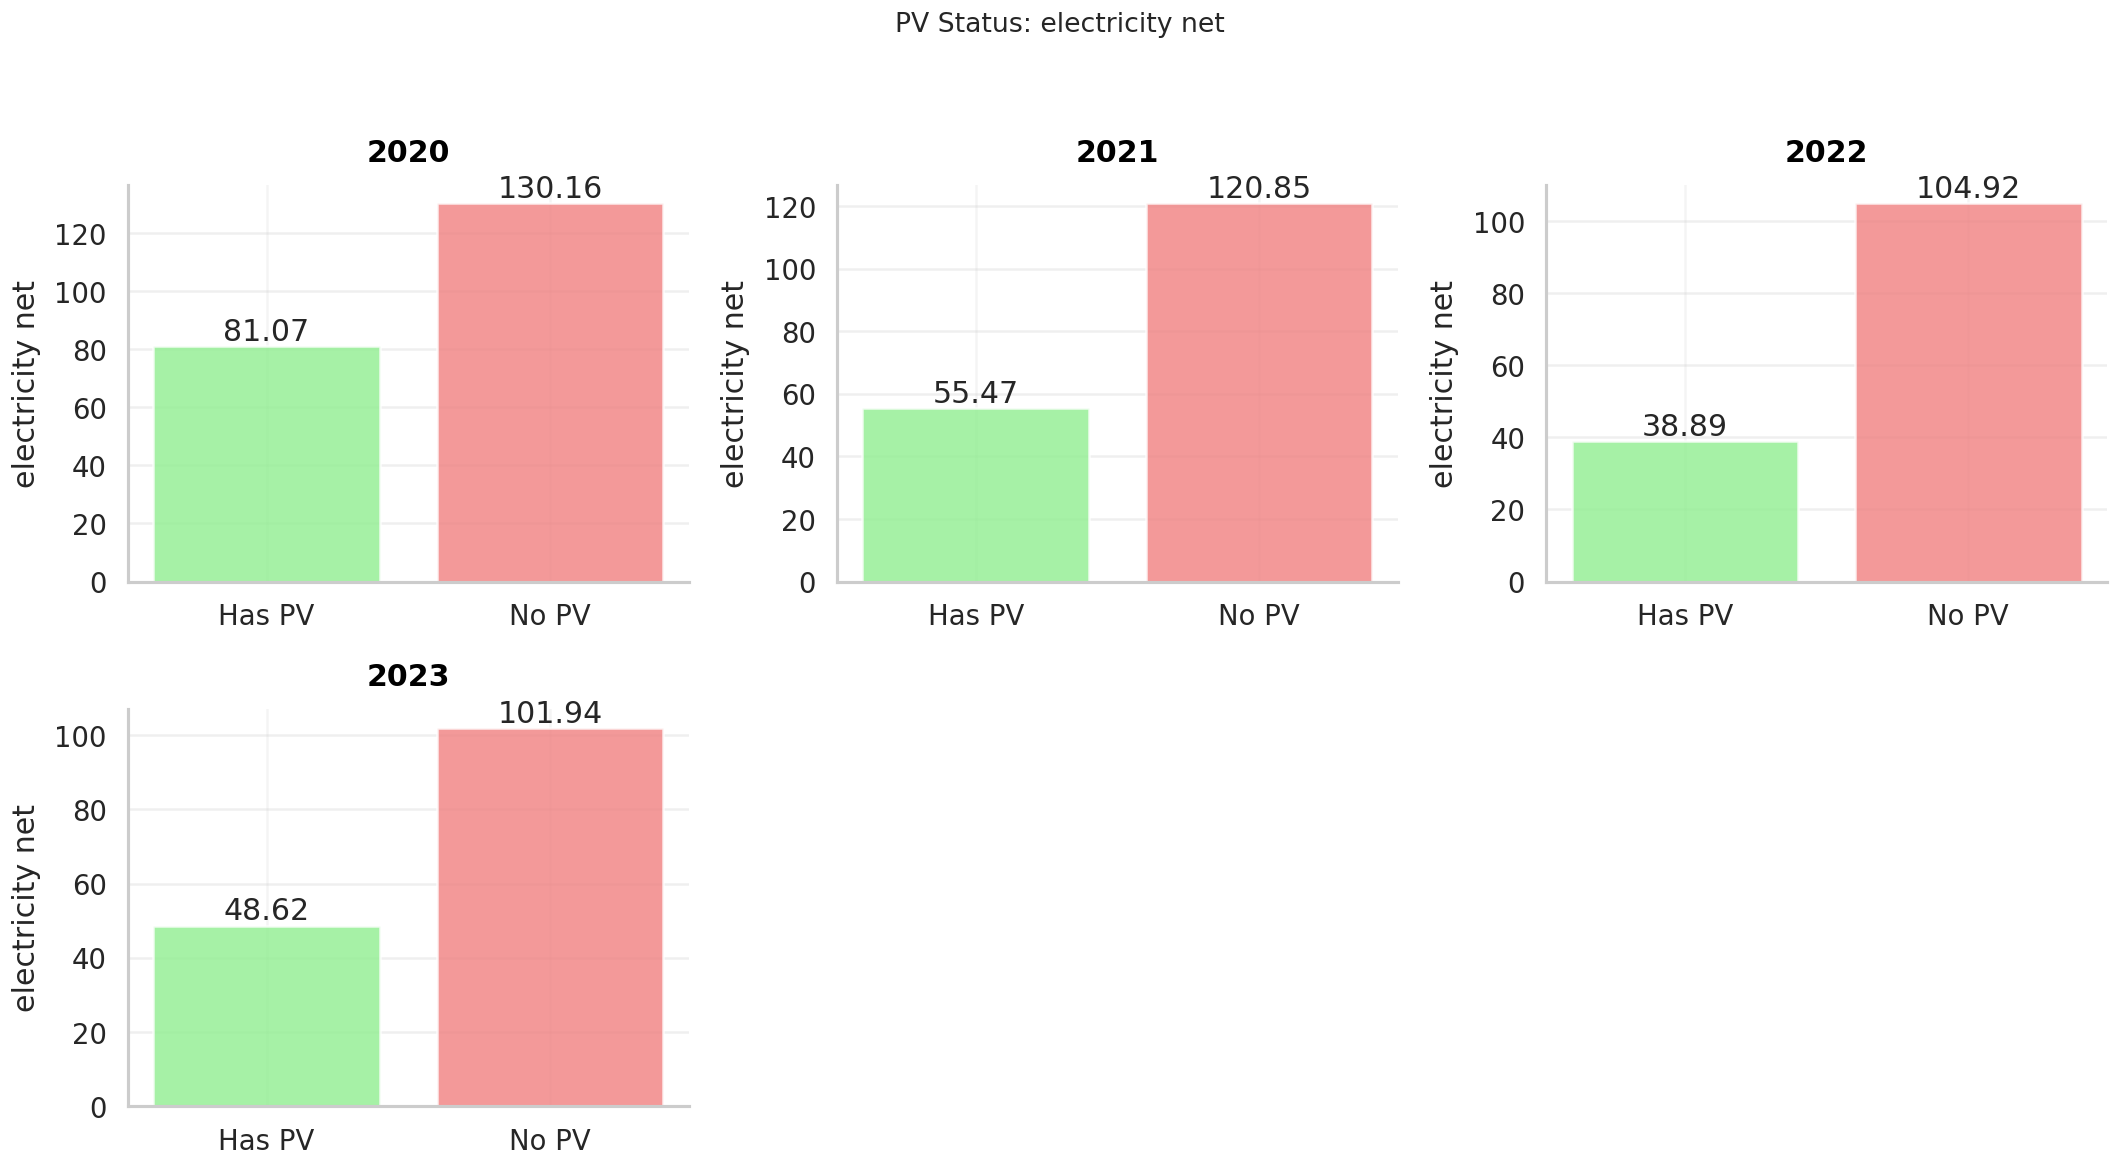

Processing quantity: gas


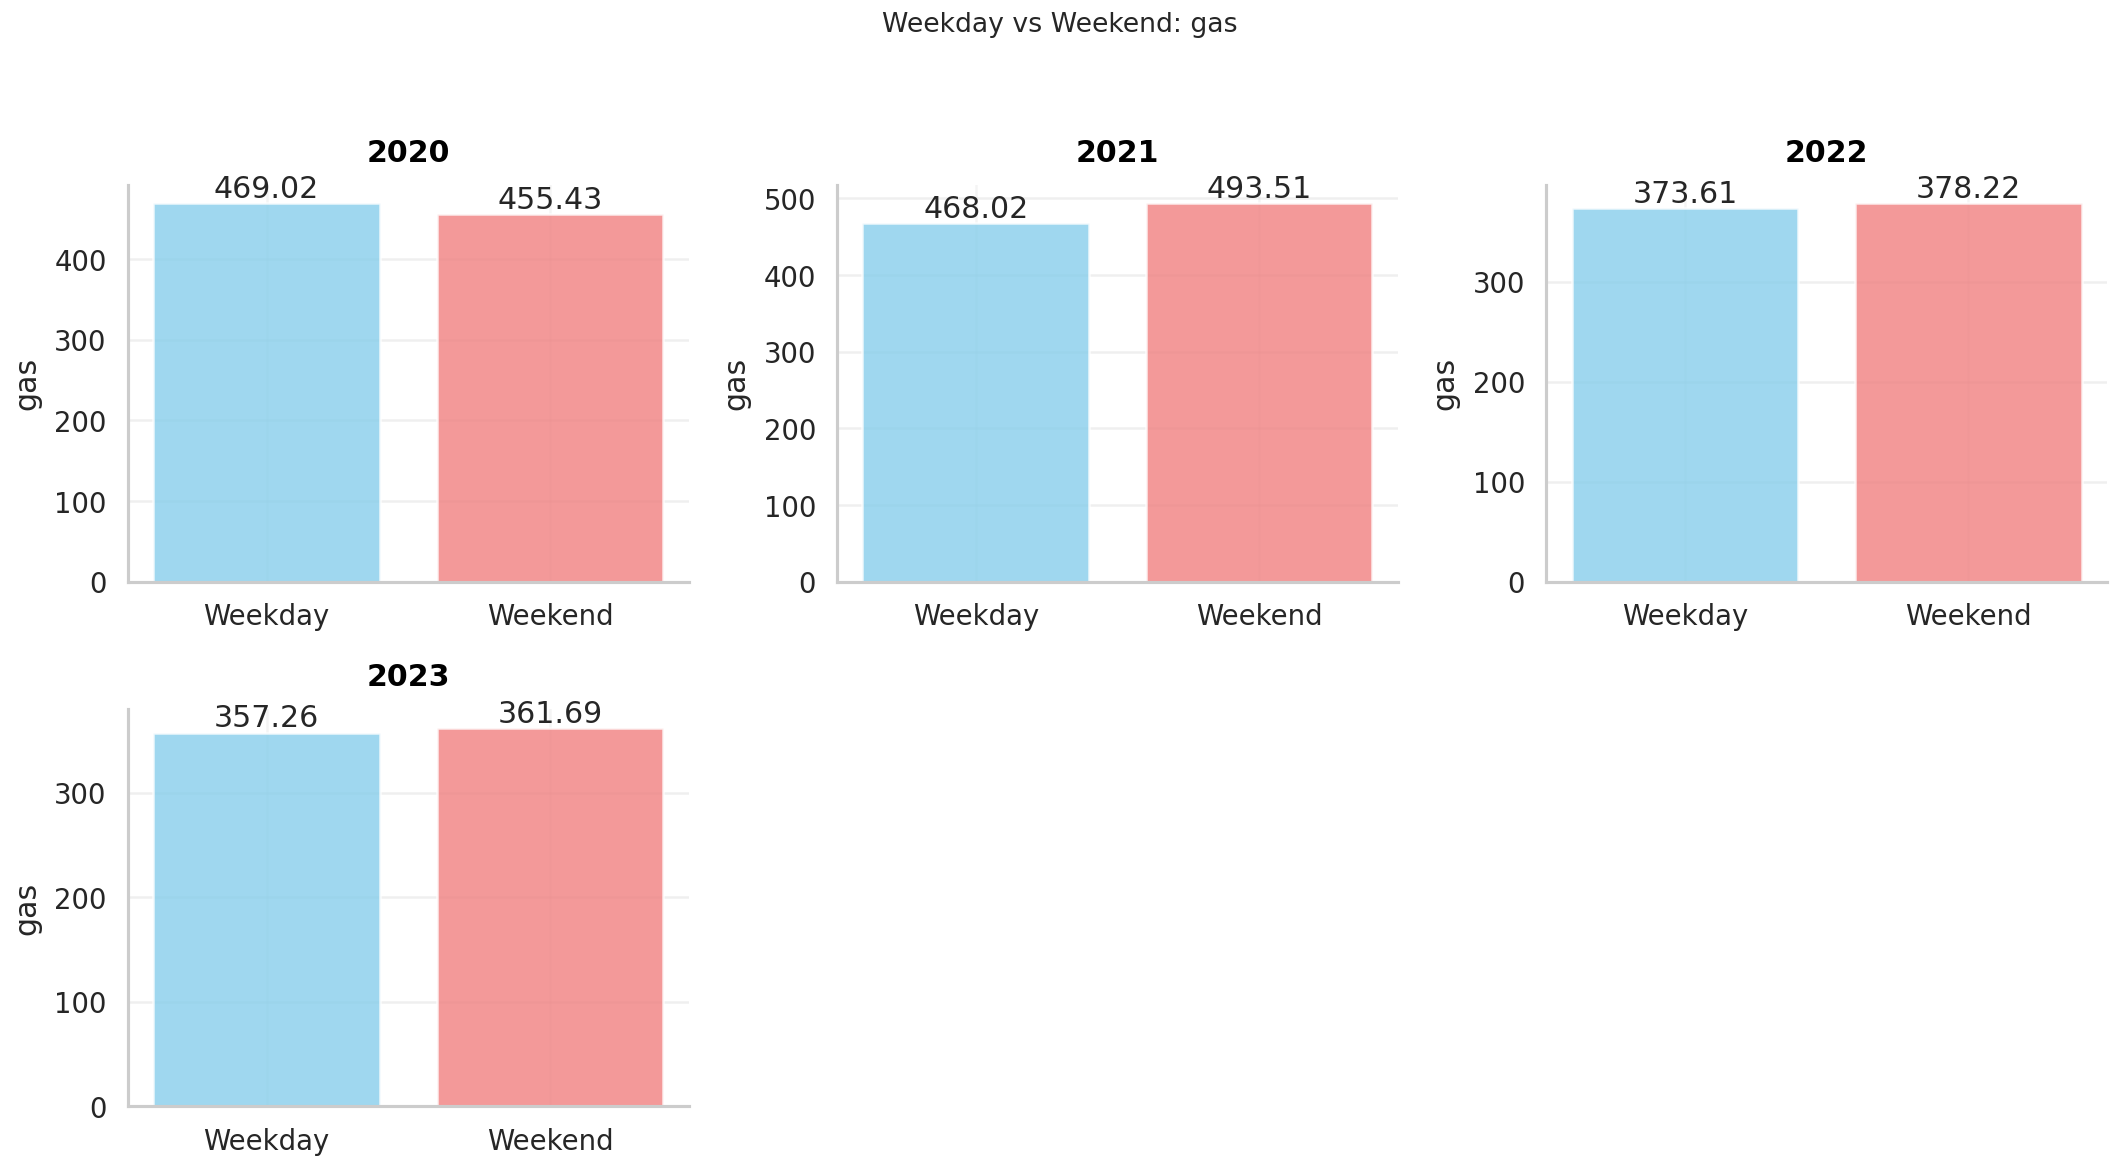

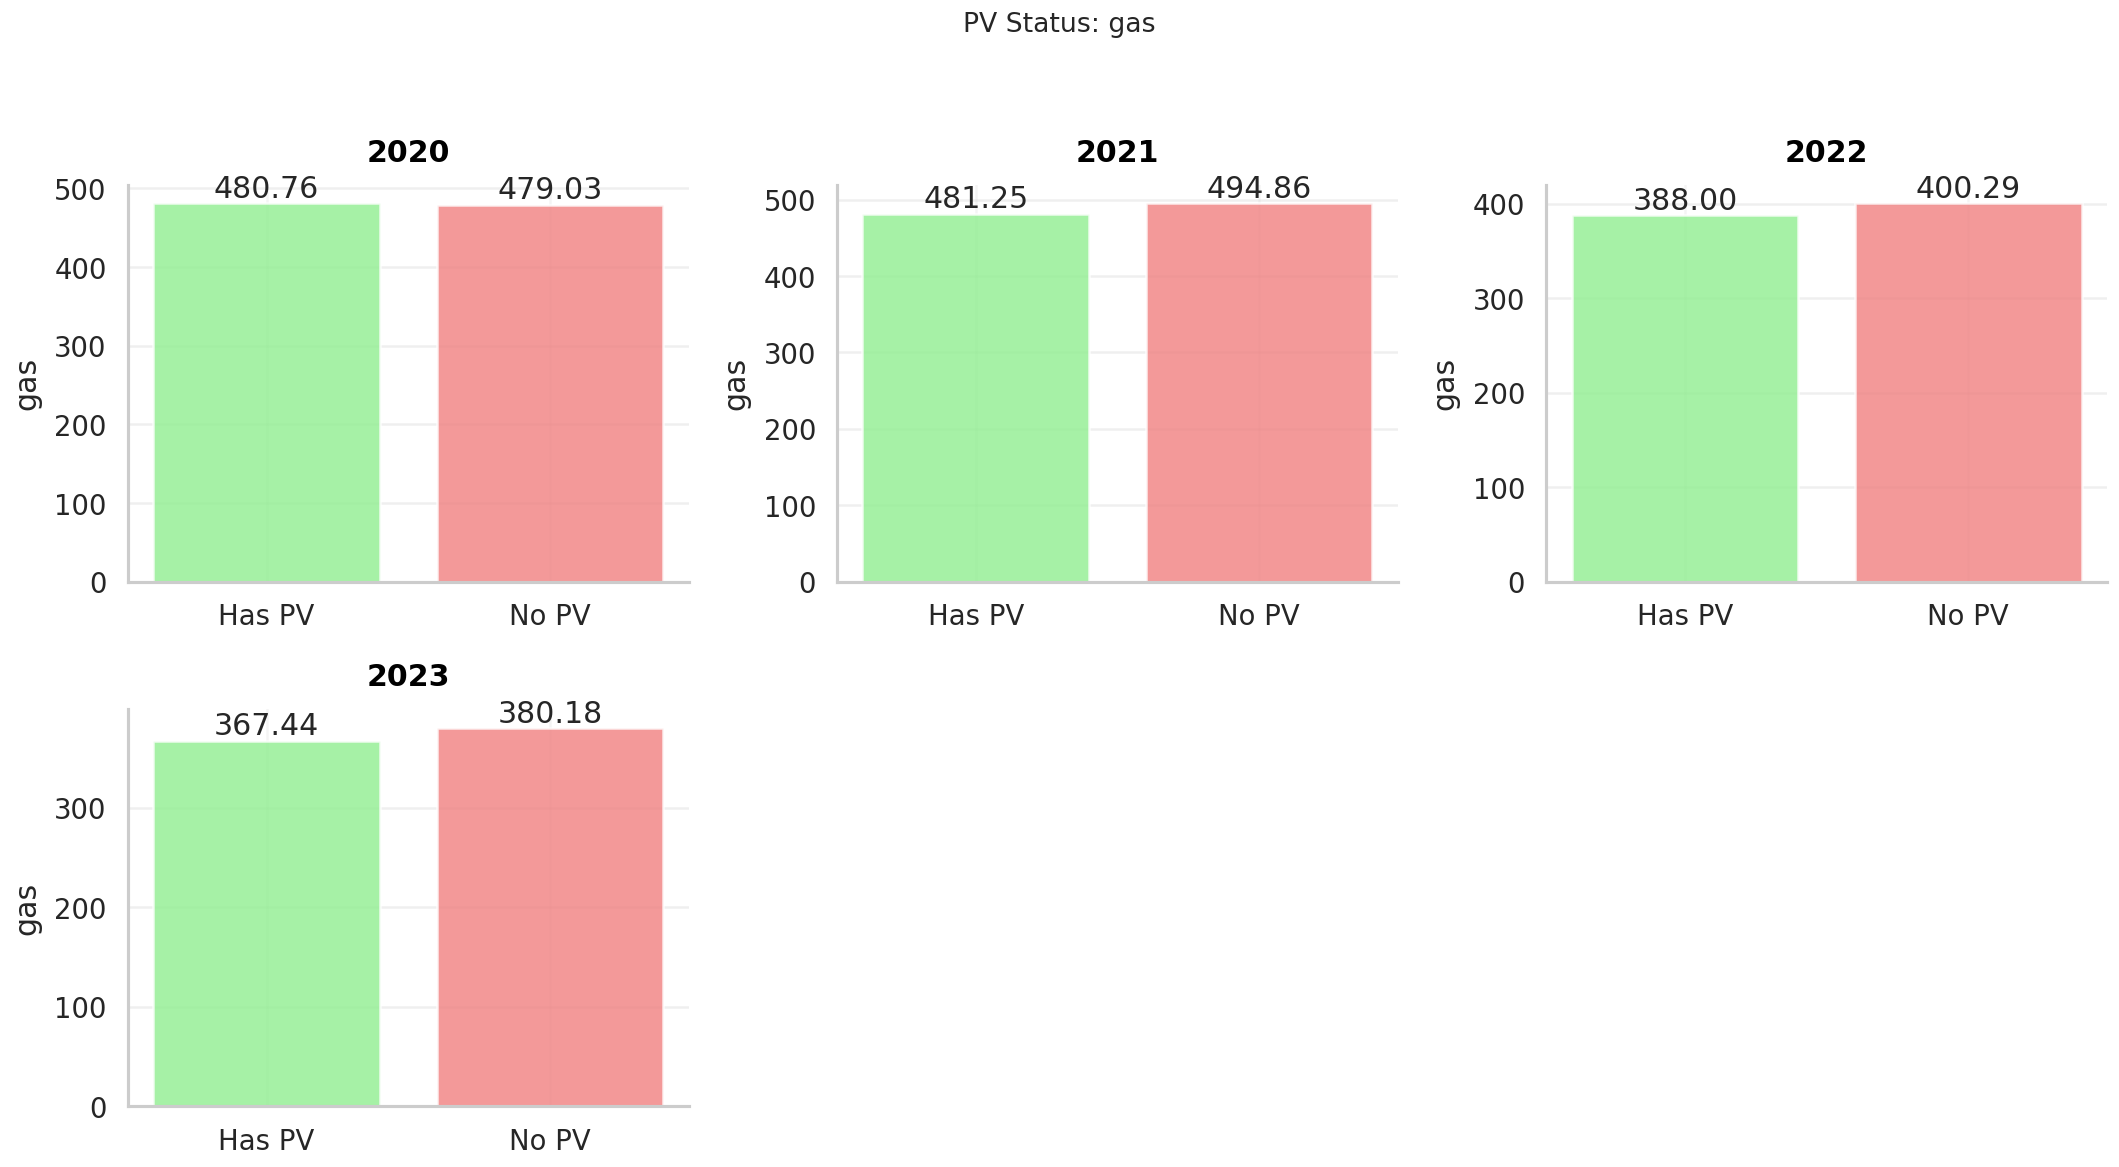

Processing quantity: gas + electricity imports


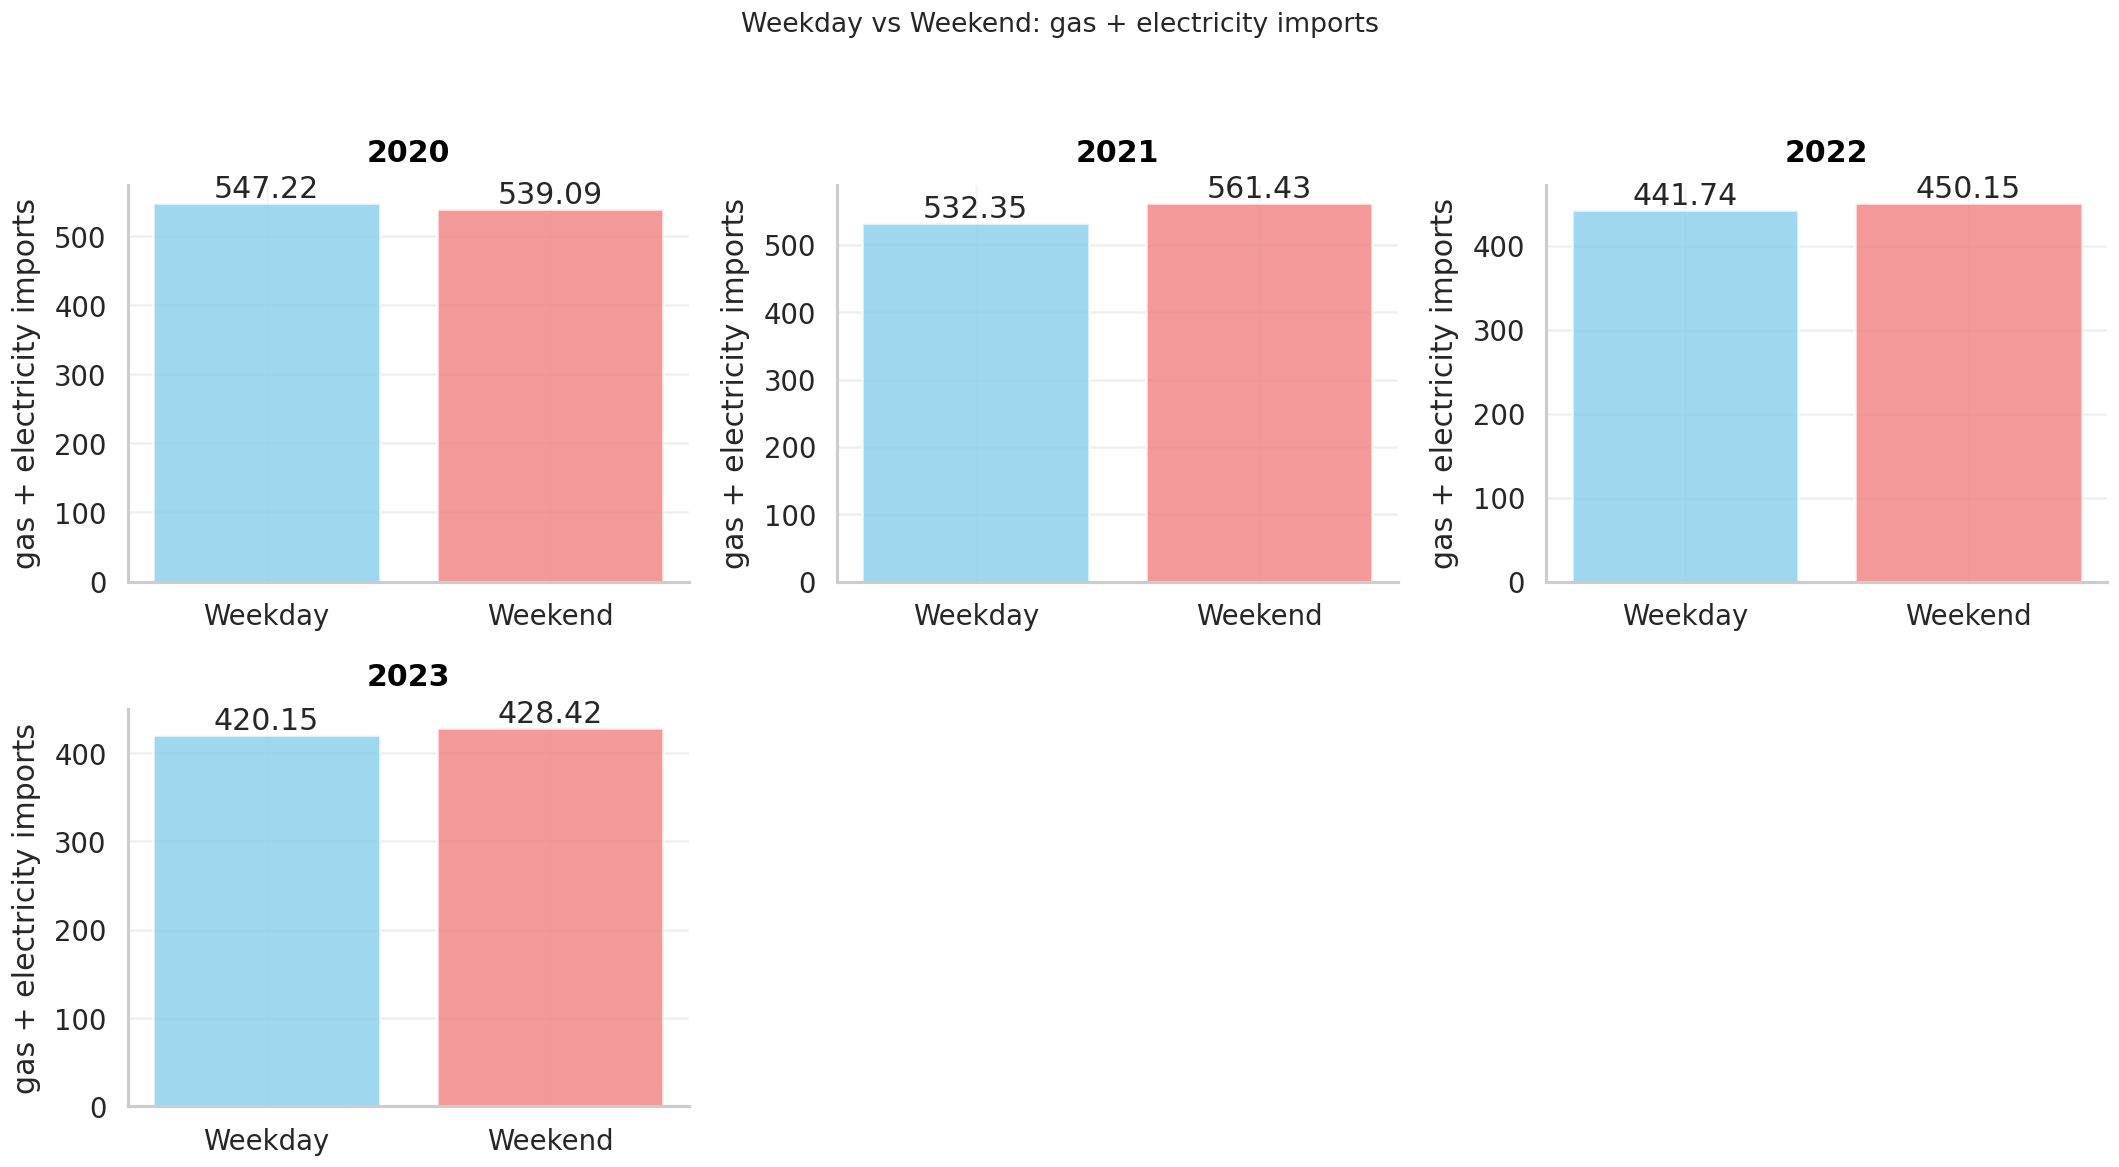

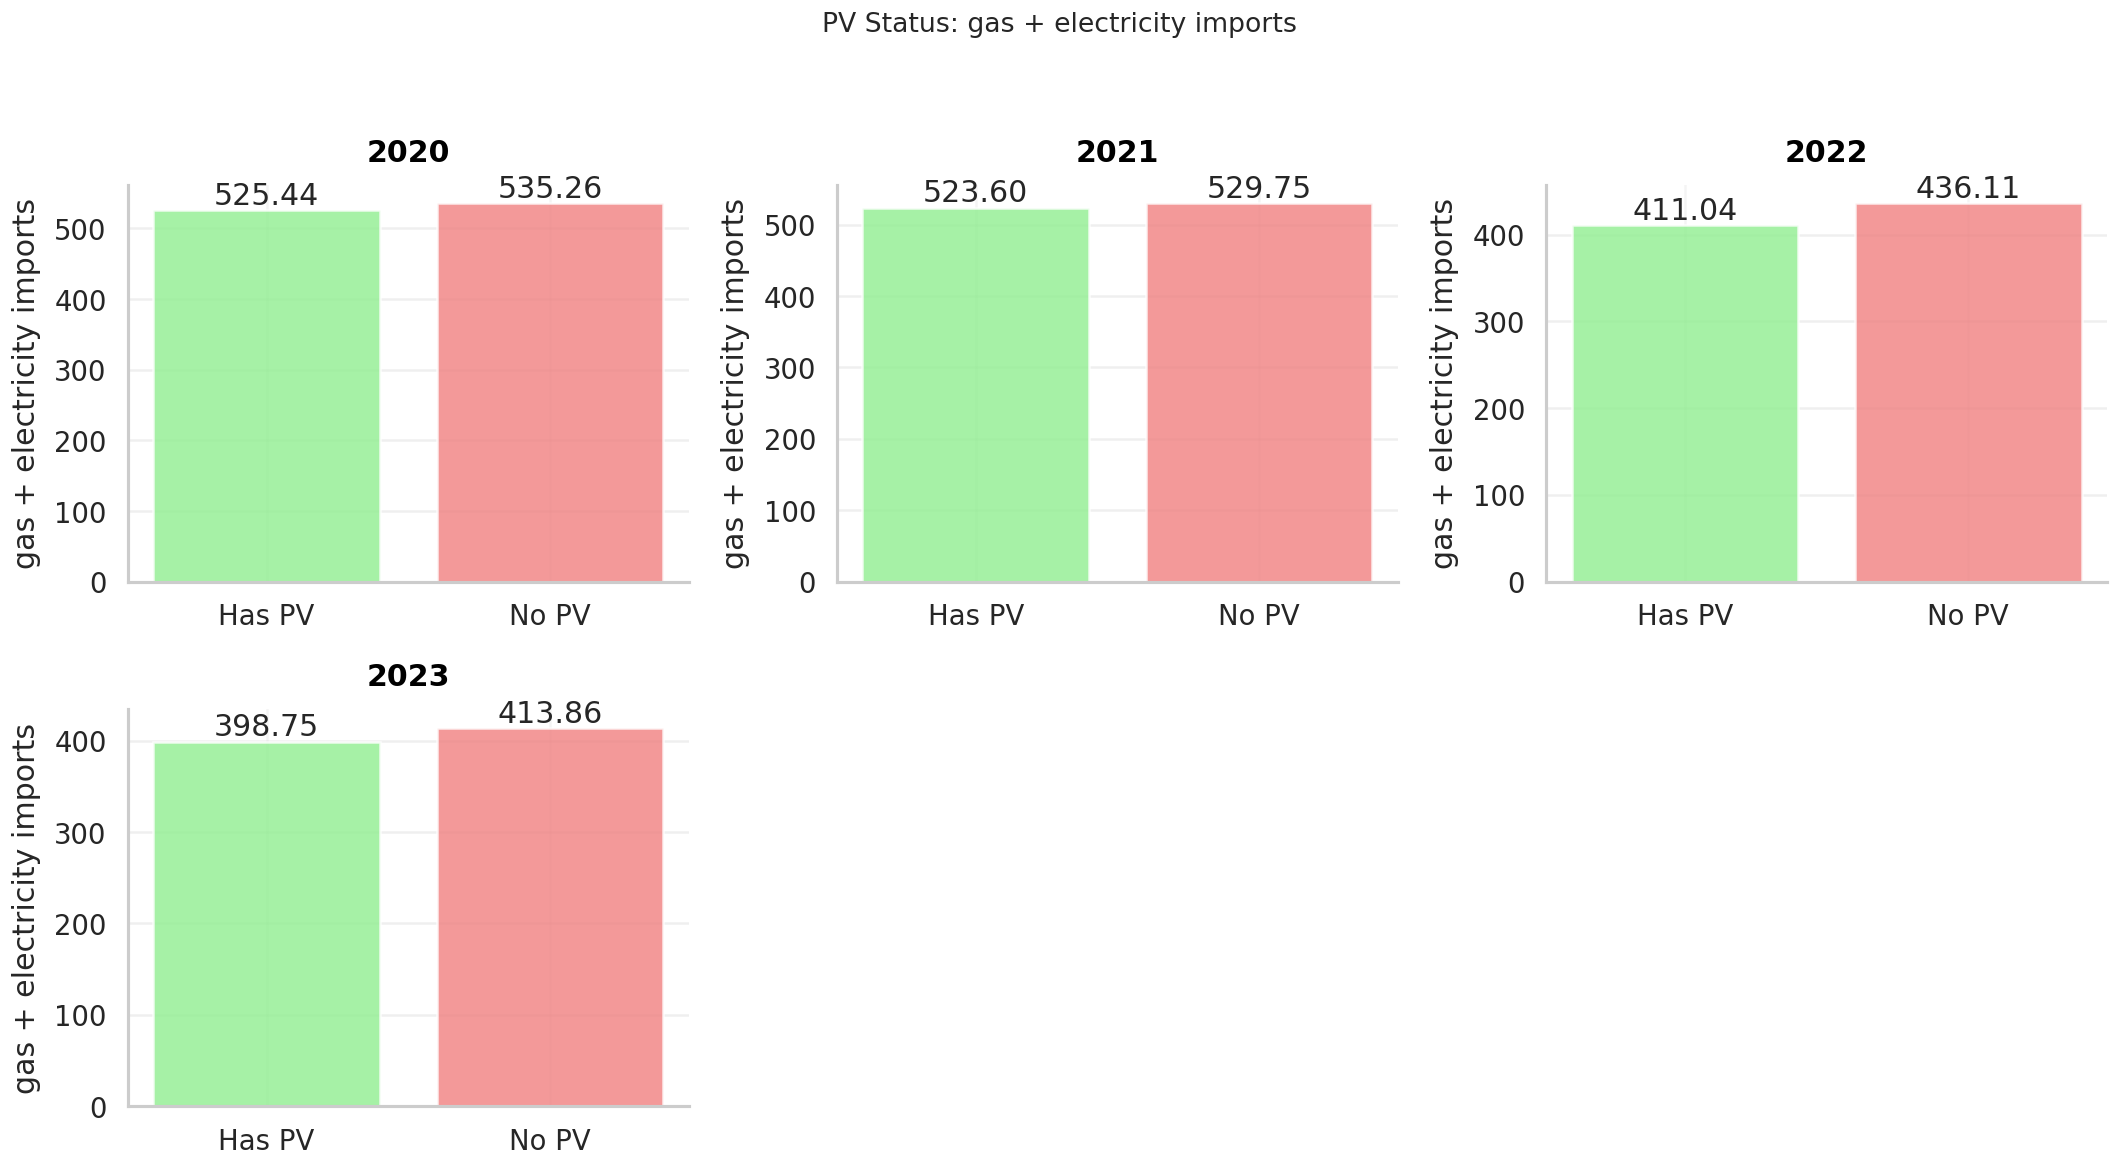

📈 creating cross-year comparison matrices...


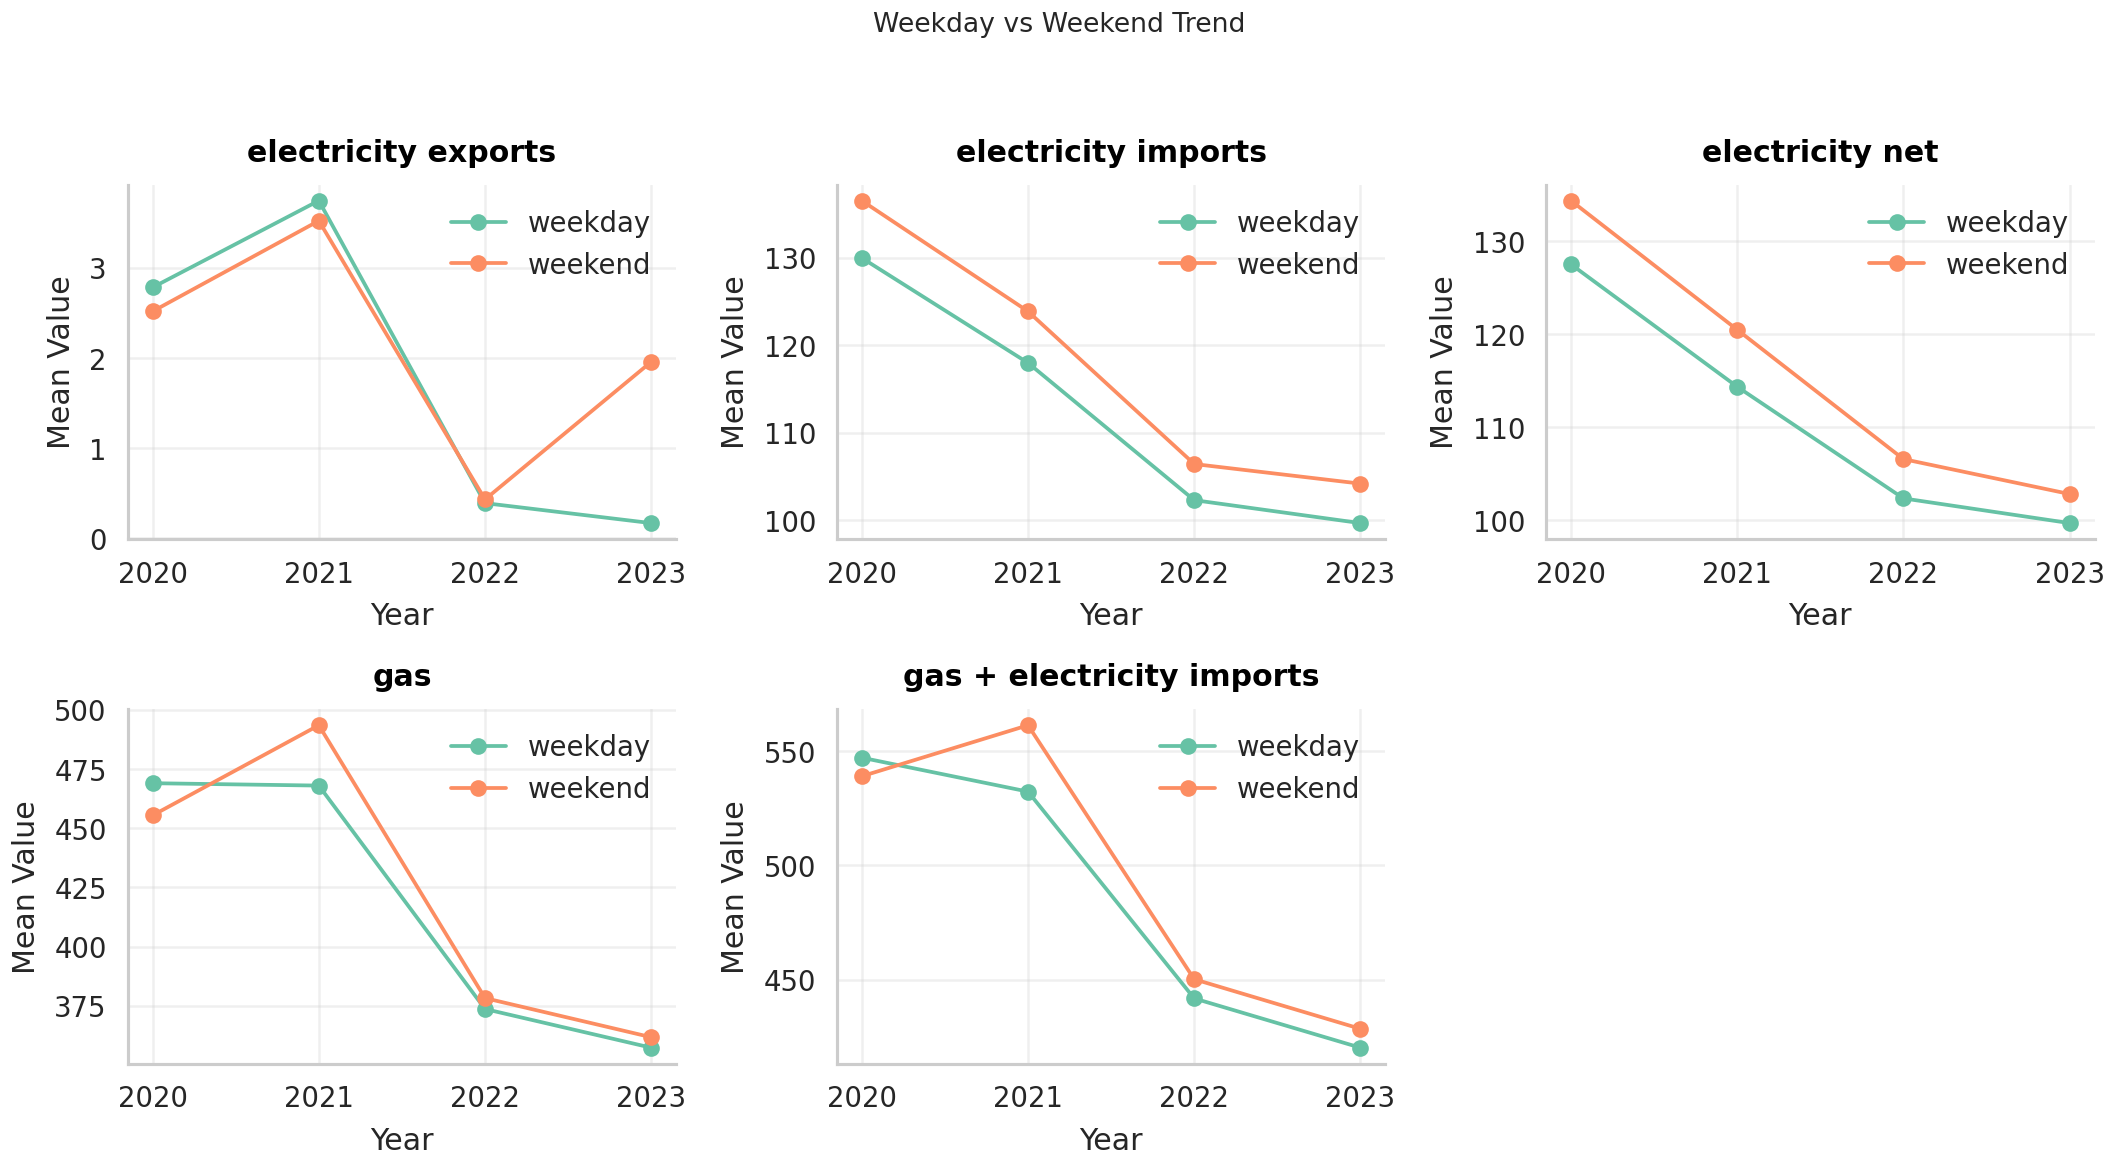

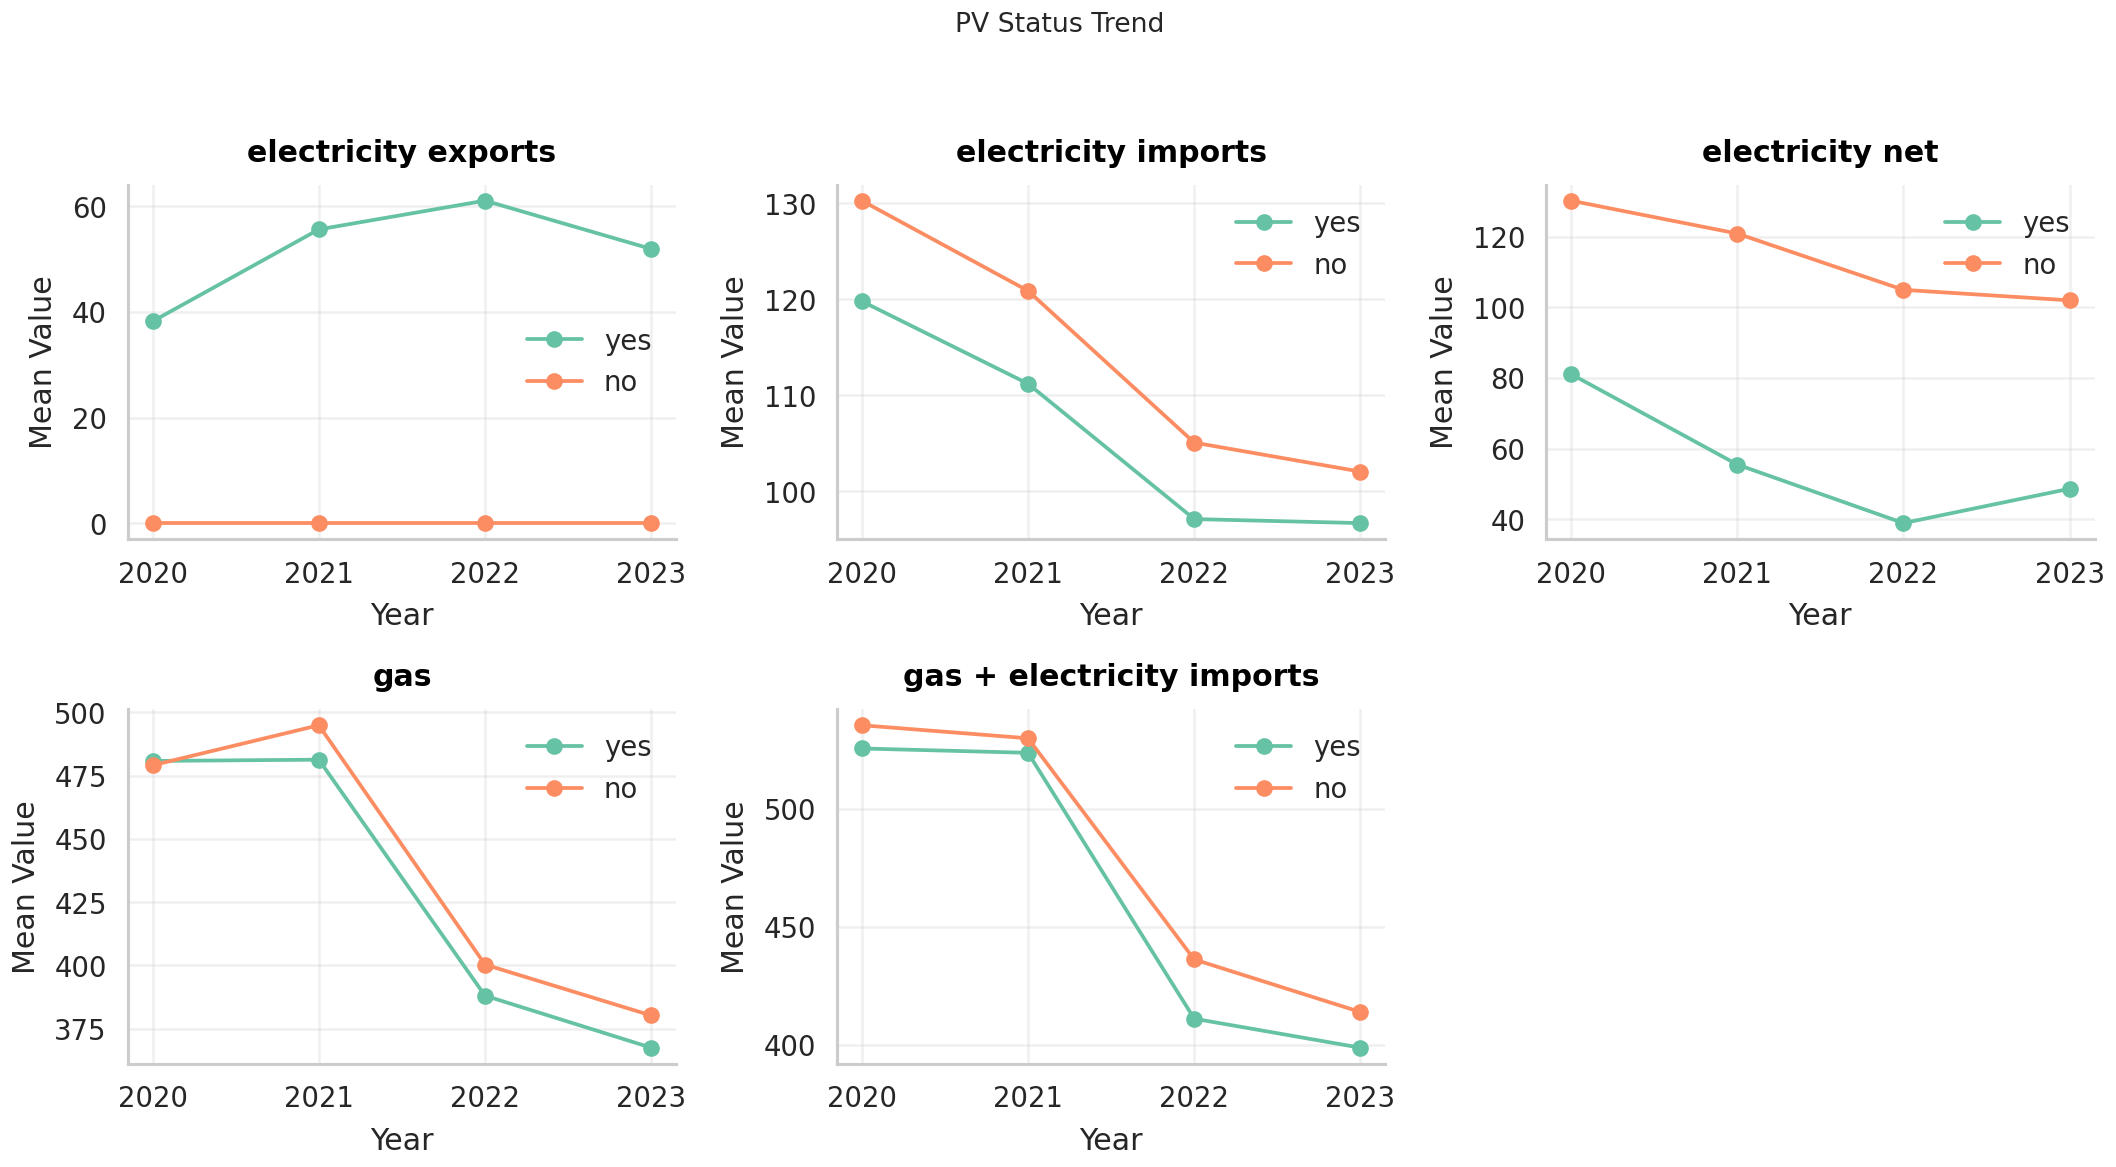


✅ analysis complete. figures saved to: /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/figures


In [ ]:
# -*- coding: utf-8 -*-
"""serl multi-year energy analysis — quantity vs weekday/weekend and PV status matrix.

this script creates matrices of visualizations for each unique quantity
against weekday/weekend and PV status across different years.
"""

# =============================================================================
# setup & environment check
# =============================================================================

import os
import sys
import random
import json
import platform
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import math

SEED = 42  # keep runs deterministic enough
random.seed(SEED)

ENV_SNAPSHOT = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "seed": SEED,
}

# =============================================================================
# configuration
# =============================================================================

BASE_DIR = Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025")
DATA_DIR = BASE_DIR / "data" / "csv"
FIGURES_DIR = BASE_DIR / "figures"
REPRO_DIR = BASE_DIR / "repro"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPRO_DIR.mkdir(parents=True, exist_ok=True)

YEAR_FILES = {
    2020: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2020_aggregated_statistics.csv",
    2021: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2021_aggregated_statistics.csv",
    2022: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2022_aggregated_statistics.csv",
    2023: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2023_aggregated_statistics.csv",
}

# clean white theme 🌿
sns.set_theme(style="whitegrid", context="talk", palette="Set2")
plt.rcParams.update({
    "figure.figsize": (12, 7),
    "font.family": "DejaVu Sans",
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "grid.alpha": 0.2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlelocation": "center",
    "axes.titlepad": 14.0,
    "axes.labelpad": 8.0
})

# =============================================================================
# utilities
# =============================================================================

def write_env_snapshot(path: Path) -> None:
    """Write environment snapshot for reproducibility.

    Args:
        path: destination json file path.

    Returns:
        None.
    """
    # we log env info so results can be reproduced later.
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(ENV_SNAPSHOT, f, indent=2)
    except Exception as e:
        # non-fatal; continue analysis
        print(f"could not write env snapshot: {e}")


def sanitize_filename(name: str) -> str:
    """Return a filesystem-safe version of `name`.

    Args:
        name: arbitrary string (e.g., quantity or unit).

    Returns:
        A sanitized string with unsafe characters replaced.
    """
    # filenames must be safe across platforms.
    return re.sub(r'[\\/*?:"<>|]', "_", str(name))


def _savefig(fig: plt.Figure, name: str) -> None:
    """Save figure to FIGURES_DIR with a clean filename.

    Args:
        fig: matplotlib figure.
        name: base filename without extension.

    Returns:
        None.
    """
    # consistent saving improves findability.
    safe = sanitize_filename(name)
    out = FIGURES_DIR / f"{safe}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")


def _format_time_axis(ax: plt.Axes) -> None:
    """Standardize x ticks to 00:00–24:00, 4h step.

    Args:
        ax: target axis.

    Returns:
        None.
    """
    # uniform time axis helps compare charts.
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 4)])


# =============================================================================
# data loading & preprocessing
# =============================================================================

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and enrich a serl aggregated dataframe.

    Args:
        df: raw dataframe for a single or multiple years.

    Returns:
        A cleaned dataframe with normalized categories and time features.
    """
    # keep original intact while we transform.
    dfc = df.copy()

    # normalize text categories to lowercase for stable grouping.
    cat_cols = [
        "quantity",
        "unit",
        "weekday_weekend",
        "segmentation_variable_1",
        "segment_1_value",
        "segmentation_variable_2",
        "segment_2_value",
        "segmentation_variable_3",
        "segment_3_value",
    ]
    for col in cat_cols:
        if col in dfc.columns:
            dfc[col] = dfc[col].astype(str).str.strip().str.lower()

    # parse time from 'summary_time' like 'HH:MM' to hour / minute / half_hour.
    if "summary_time" in dfc.columns:
        tp = dfc["summary_time"].astype(str).str.extract(r"(\d{1,2}):(\d{2})")
        dfc["hour"] = pd.to_numeric(tp[0], errors="coerce")
        dfc["minute"] = pd.to_numeric(tp[1], errors="coerce")
        dfc["half_hour"] = dfc["hour"] * 2 + (dfc["minute"] >= 30).astype(int)
        dfc["time_index"] = dfc["half_hour"] / 2.0  # hours since midnight for plots

    # coerce known numeric columns
    num_cols = ["mean", "median", "standard_deviation", "mean_temp", "mean_solar", "n_rounded"]
    for col in num_cols:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc


def load_all_years() -> pd.DataFrame:
    """Load 2020–2023 csvs, tag with year, and preprocess.

    Returns:
        Combined tidy dataframe across available years.

    Raises:
        FileNotFoundError: if none of the files are found.
    """
    # we load lazily and tolerate missing years.
    dfs = []
    for year, path in YEAR_FILES.items():
        if not path.exists():
            print(f"⚠️ missing file for {year}: {path}")
            continue
        dfi = pd.read_csv(path)
        dfi["year"] = int(year)
        dfs.append(dfi)

    if not dfs:
        raise FileNotFoundError("no serl csv files found — check DATA_DIR paths")

    df_all = pd.concat(dfs, ignore_index=True)
    df_all = preprocess_data(df_all)
    print(f"✅ combined shape: {df_all.shape}")
    return df_all


# =============================================================================
# analysis functions
# =============================================================================

def get_unique_quantities(df: pd.DataFrame) -> list:
    """Get all unique quantities in the dataset.
    
    Args:
        df: combined dataframe
        
    Returns:
        List of unique quantities
    """
    return sorted(df["quantity"].unique().tolist())


def create_quantity_matrices(df: pd.DataFrame) -> None:
    """Create matrices of visualizations for each quantity.
    
    For each unique quantity, create:
    1. Weekday vs Weekend comparison across years
    2. PV vs No PV comparison across years
    
    Args:
        df: combined dataframe
        
    Returns:
        None
    """
    # Get unique quantities
    quantities = get_unique_quantities(df)
    years = sorted(df["year"].unique())
    
    print(f"Found {len(quantities)} unique quantities: {quantities}")
    
    # For each quantity, create the matrices
    for quantity in quantities:
        print(f"Processing quantity: {quantity}")
        
        # Filter data for this quantity
        q_df = df[df["quantity"] == quantity].copy()
        
        # Create weekday/weekend matrix
        create_weekday_weekend_matrix(q_df, quantity, years)
        
        # Create PV status matrix
        create_pv_status_matrix(q_df, quantity, years)


def create_weekday_weekend_matrix(df: pd.DataFrame, quantity: str, years: list) -> None:
    """Create a matrix of weekday vs weekend comparisons across years.
    
    Args:
        df: filtered dataframe for a specific quantity
        quantity: the quantity being analyzed
        years: list of years to include
        
    Returns:
        None
    """
    # Filter for weekday/weekend data
    ww_df = df[df["weekday_weekend"].isin(["weekday", "weekend"])].copy()
    
    if ww_df.empty:
        print(f"No weekday/weekend data for {quantity}")
        return
    
    # Calculate weighted means
    ww_df["weighted_mean"] = ww_df["mean"] * ww_df["n_rounded"].fillna(0)
    yearly_data = ww_df.groupby(["year", "weekday_weekend"]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()
    
    yearly_data["mean_value"] = yearly_data["total_weighted"] / yearly_data["total_n"].replace(0, np.nan)
    
    # Create a matrix of plots (one for each year)
    n_years = len(years)
    ncols = min(3, n_years)
    nrows = math.ceil(n_years / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    
    if n_years > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, year in enumerate(years):
        if i >= len(axes):
            break
            
        ax = axes[i]
        year_data = yearly_data[yearly_data["year"] == year]
        
        # Prepare data for bar chart
        weekday_data = year_data[year_data["weekday_weekend"] == "weekday"]
        weekend_data = year_data[year_data["weekday_weekend"] == "weekend"]
        
        # Create bar chart
        labels = ["Weekday", "Weekend"]
        values = [
            weekday_data["mean_value"].values[0] if not weekday_data.empty else 0,
            weekend_data["mean_value"].values[0] if not weekend_data.empty else 0
        ]
        
        ax.bar(labels, values, alpha=0.8, color=["skyblue", "lightcoral"])
        ax.set_title(f"{year}")
        ax.set_ylabel(f"{quantity}")
        ax.grid(True, axis='y', alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(values):
            ax.text(j, v, f"{v:.2f}", ha='center', va='bottom')
    
    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Create a super title
    fig.suptitle(f"Weekday vs Weekend: {quantity}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    filename = f"weekday_weekend_matrix_{sanitize_filename(quantity)}"
    _savefig(fig, filename)
    plt.show()


def create_pv_status_matrix(df: pd.DataFrame, quantity: str, years: list) -> None:
    """Create a matrix of PV status comparisons across years.
    
    Args:
        df: filtered dataframe for a specific quantity
        quantity: the quantity being analyzed
        years: list of years to include
        
    Returns:
        None
    """
    # Filter for PV status data
    pv_df = df[df["segmentation_variable_2"] == "has_pv"].copy()
    
    if pv_df.empty:
        print(f"No PV status data for {quantity}")
        return
    
    # Calculate weighted means
    pv_df["weighted_mean"] = pv_df["mean"] * pv_df["n_rounded"].fillna(0)
    yearly_data = pv_df.groupby(["year", "segment_2_value"]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()
    
    yearly_data["mean_value"] = yearly_data["total_weighted"] / yearly_data["total_n"].replace(0, np.nan)
    
    # Create a matrix of plots (one for each year)
    n_years = len(years)
    ncols = min(3, n_years)
    nrows = math.ceil(n_years / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    
    if n_years > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, year in enumerate(years):
        if i >= len(axes):
            break
            
        ax = axes[i]
        year_data = yearly_data[yearly_data["year"] == year]
        
        # Prepare data for bar chart
        pv_yes_data = year_data[year_data["segment_2_value"] == "yes"]
        pv_no_data = year_data[year_data["segment_2_value"] == "no"]
        
        # Create bar chart
        labels = ["Has PV", "No PV"]
        values = [
            pv_yes_data["mean_value"].values[0] if not pv_yes_data.empty else 0,
            pv_no_data["mean_value"].values[0] if not pv_no_data.empty else 0
        ]
        
        ax.bar(labels, values, alpha=0.8, color=["lightgreen", "lightcoral"])
        ax.set_title(f"{year}")
        ax.set_ylabel(f"{quantity}")
        ax.grid(True, axis='y', alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(values):
            ax.text(j, v, f"{v:.2f}", ha='center', va='bottom')
    
    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Create a super title
    fig.suptitle(f"PV Status: {quantity}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    filename = f"pv_status_matrix_{sanitize_filename(quantity)}"
    _savefig(fig, filename)
    plt.show()


def create_cross_year_comparison(df: pd.DataFrame) -> None:
    """Create cross-year comparison matrices for all quantities.
    
    Args:
        df: combined dataframe
        
    Returns:
        None
    """
    # Get unique quantities
    quantities = get_unique_quantities(df)
    years = sorted(df["year"].unique())
    
    # Create a matrix for weekday/weekend trends across years
    create_trend_matrix(df, quantities, years, "weekday_weekend", ["weekday", "weekend"], "Weekday vs Weekend Trend")
    
    # Create a matrix for PV status trends across years
    create_trend_matrix(df, quantities, years, "segment_2_value", ["yes", "no"], "PV Status Trend", 
                       filter_condition=(df["segmentation_variable_2"] == "has_pv"))


def create_trend_matrix(df: pd.DataFrame, quantities: list, years: list, 
                       category_col: str, categories: list, title: str, 
                       filter_condition=None) -> None:
    """Create a matrix of trends across years for different quantities.
    
    Args:
        df: combined dataframe
        quantities: list of quantities to include
        years: list of years to include
        category_col: the column to use for categorization
        categories: the categories to include
        title: the title for the matrix
        filter_condition: optional condition to filter the dataframe
        
    Returns:
        None
    """
    # Apply filter condition if provided
    if filter_condition is not None:
        plot_df = df[filter_condition].copy()
    else:
        plot_df = df.copy()
    
    # Calculate weighted means
    plot_df["weighted_mean"] = plot_df["mean"] * plot_df["n_rounded"].fillna(0)
    yearly_data = plot_df.groupby(["year", "quantity", category_col]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()
    
    yearly_data["mean_value"] = yearly_data["total_weighted"] / yearly_data["total_n"].replace(0, np.nan)
    
    # Create a matrix of plots (one for each quantity)
    n_quantities = len(quantities)
    ncols = min(3, n_quantities)
    nrows = math.ceil(n_quantities / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    
    if n_quantities > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, quantity in enumerate(quantities):
        if i >= len(axes):
            break
            
        ax = axes[i]
        q_data = yearly_data[yearly_data["quantity"] == quantity]
        
        # Plot a line for each category
        for category in categories:
            cat_data = q_data[q_data[category_col] == category]
            if not cat_data.empty:
                ax.plot(cat_data["year"], cat_data["mean_value"], marker="o", label=category)
        
        ax.set_title(quantity)
        ax.set_xlabel("Year")
        ax.set_ylabel("Mean Value")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Create a super title
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    filename = f"cross_year_{sanitize_filename(title)}"
    _savefig(fig, filename)
    plt.show()


# =============================================================================
# main orchestration
# =============================================================================

def main() -> None:
    """Run the quantity matrix analysis.

    Steps:
      1) load data and preprocess
      2) create matrices for each quantity vs weekday/weekend and PV status
      3) create cross-year comparison matrices

    Returns:
        None.
    """
    # log environment for reproducibility.
    write_env_snapshot(REPRO_DIR / "env_snapshot.json")

    # load data
    print("📂 loading & preprocessing serl data...")
    df = load_all_years()
    
    # Create matrices for each quantity
    print("📊 creating matrices for each quantity...")
    create_quantity_matrices(df)
    
    # Create cross-year comparison matrices
    print("📈 creating cross-year comparison matrices...")
    create_cross_year_comparison(df)
    
    print(f"\n✅ analysis complete. figures saved to: {FIGURES_DIR}")


if __name__ == "__main__":
    main()

📂 loading & preprocessing SERL data...
✅ combined shape: (1961280, 26)

🔍 Identifying all unique quantities...
Unique quantities in the dataset:
1. electricity exports
2. electricity imports
3. electricity net
4. gas
5. gas + electricity imports

📊 Analyzing relationships with PV and heating types...


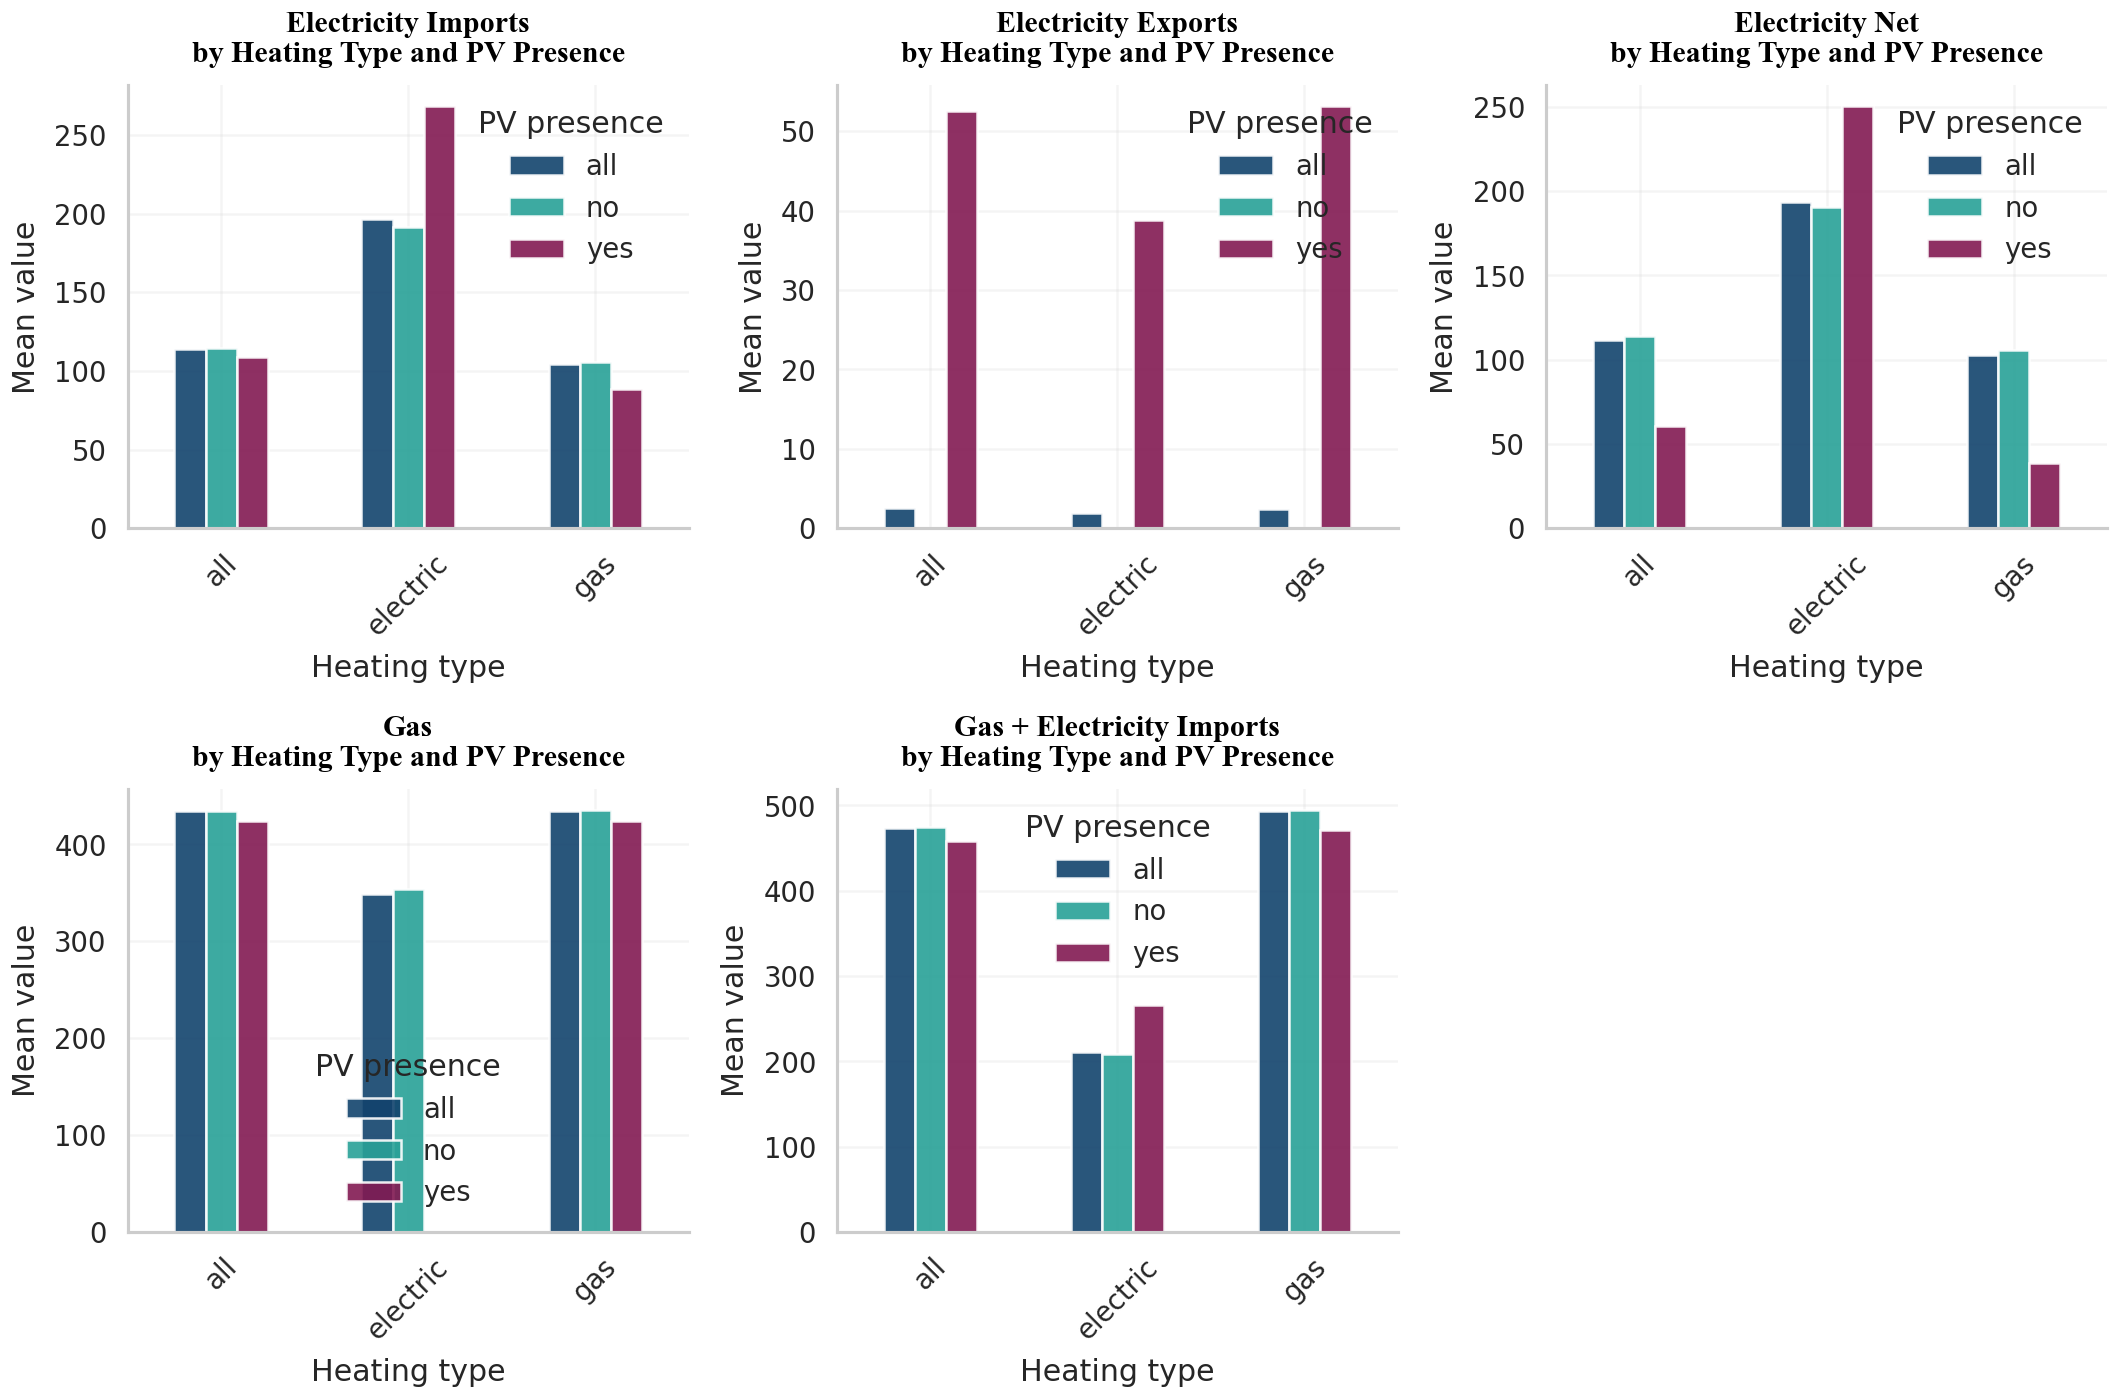


📈 Creating matrix of yearly trends...


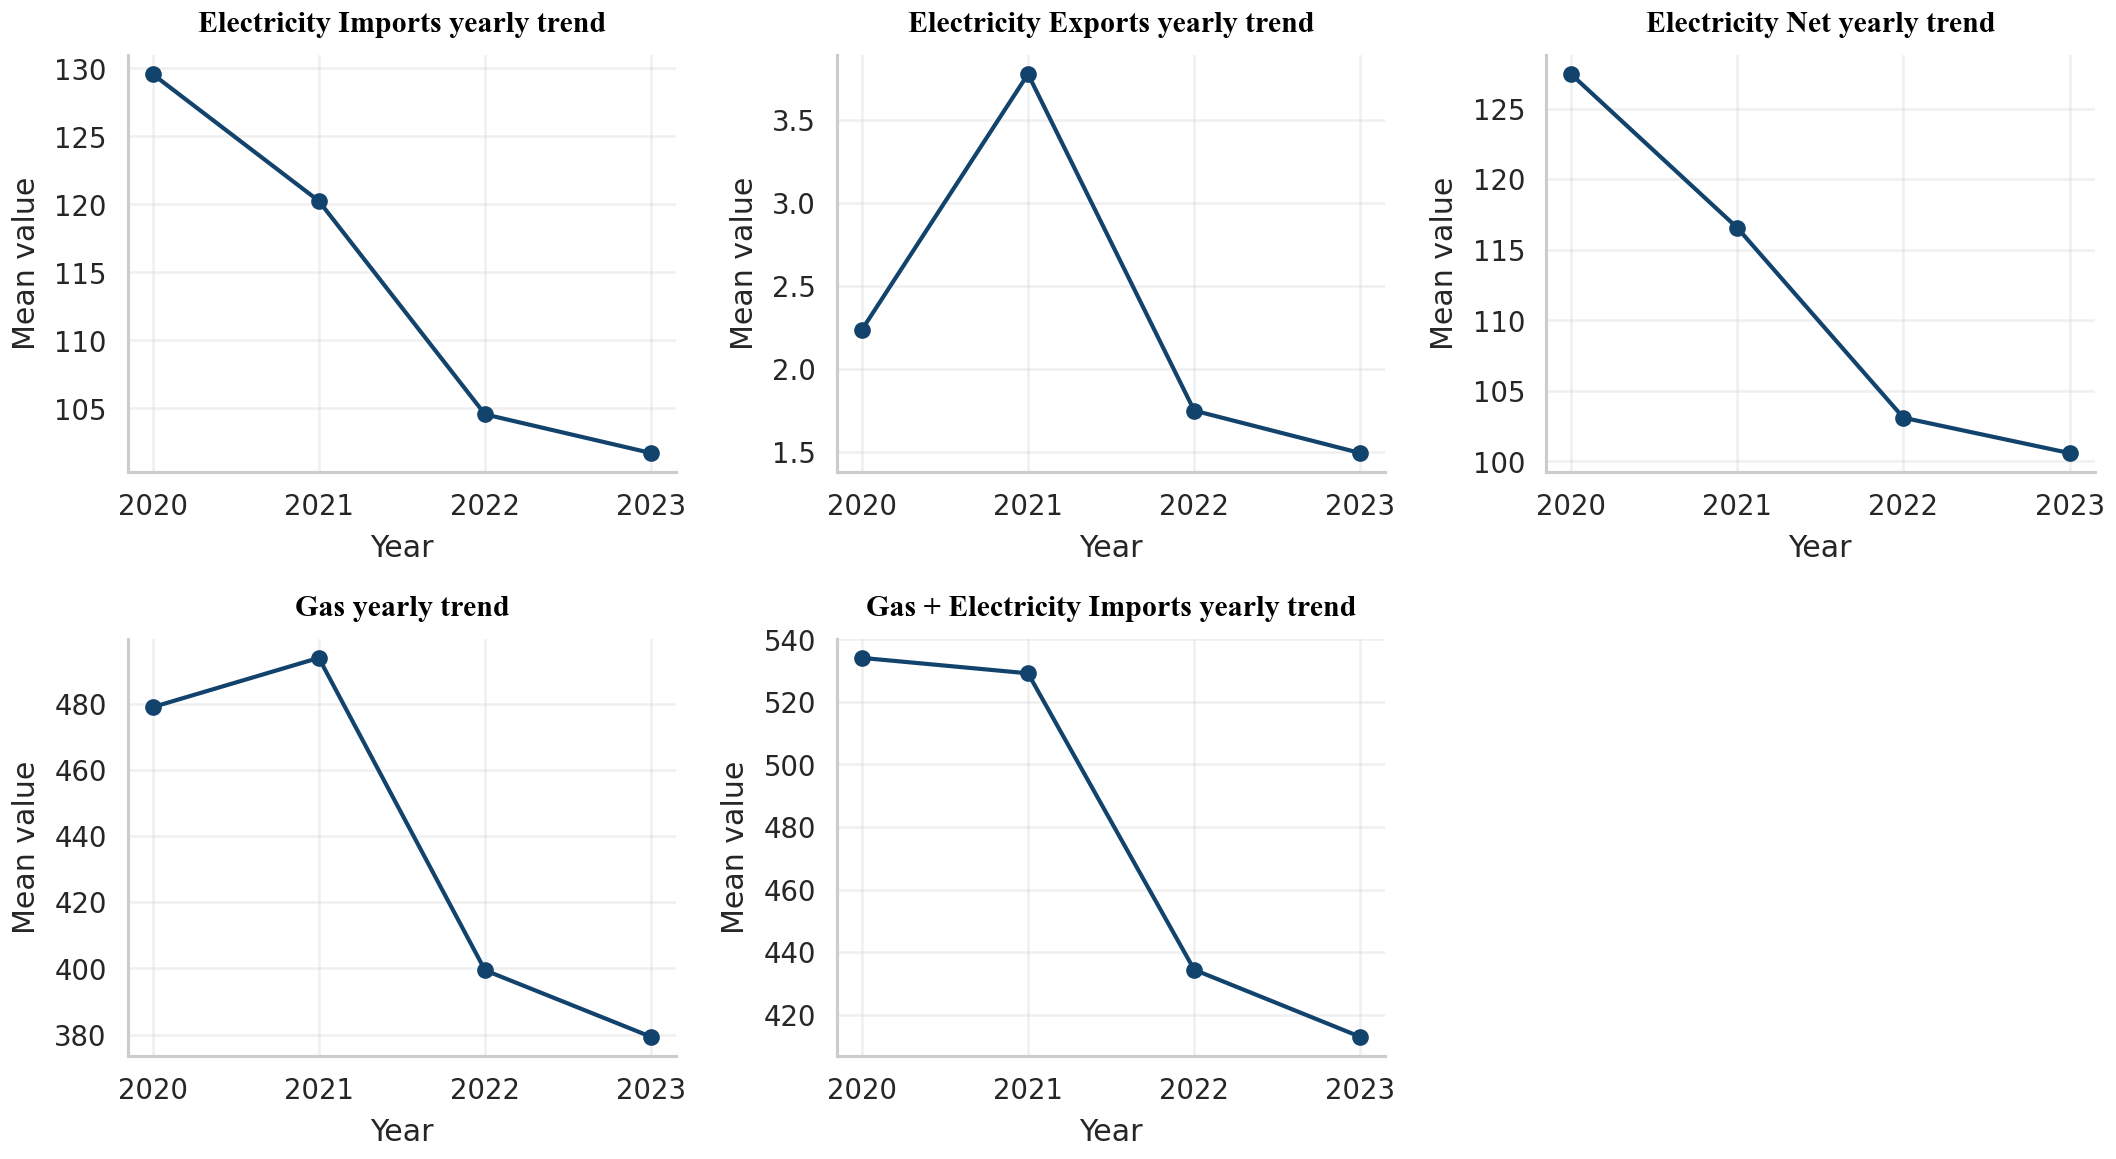


🌀 Generating radial plots...


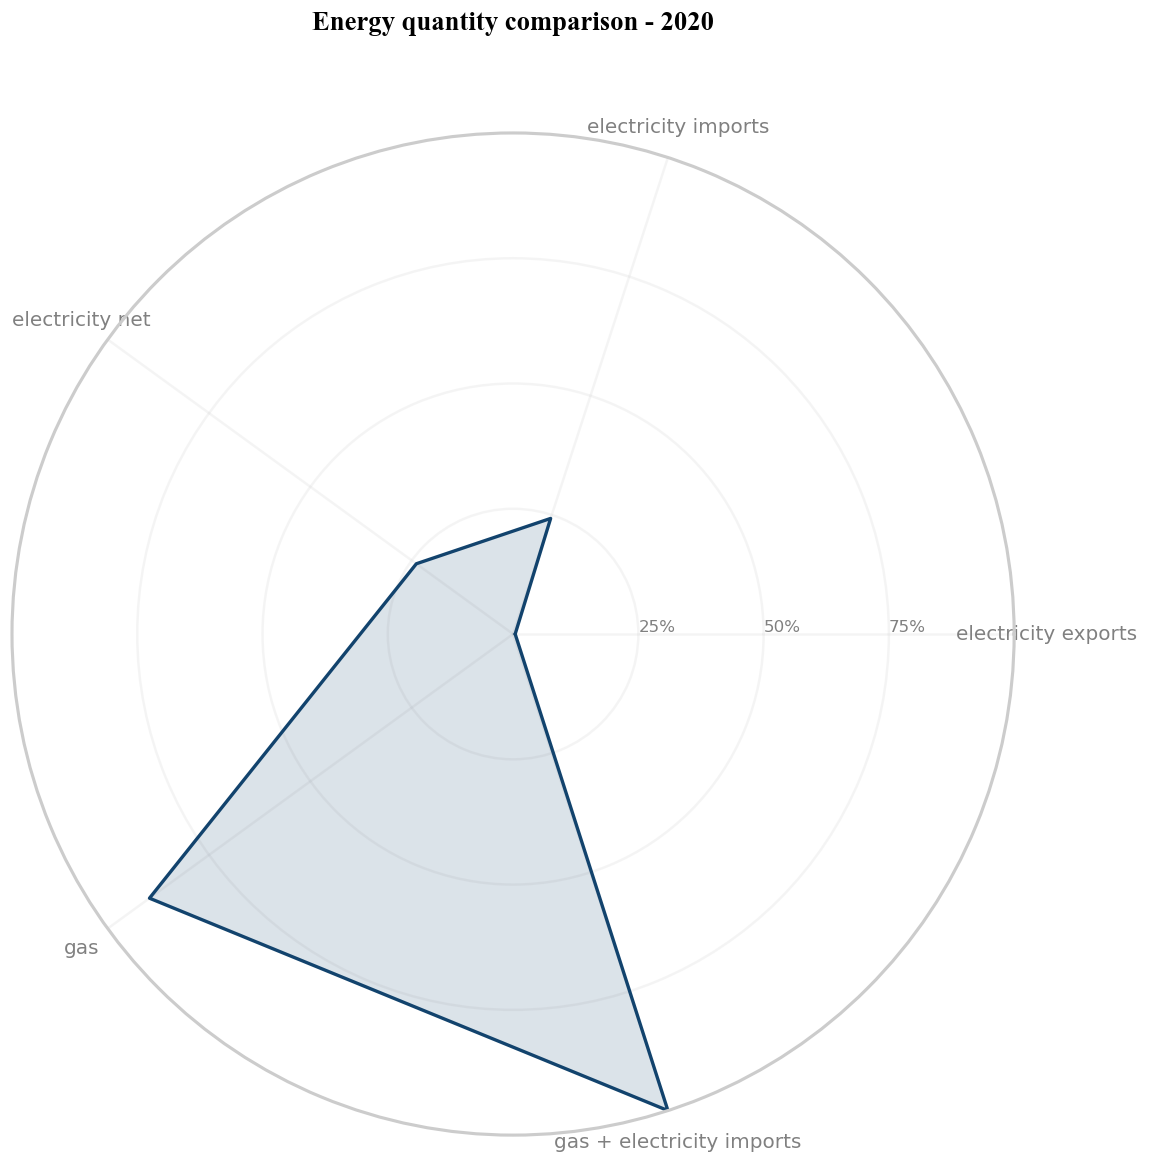

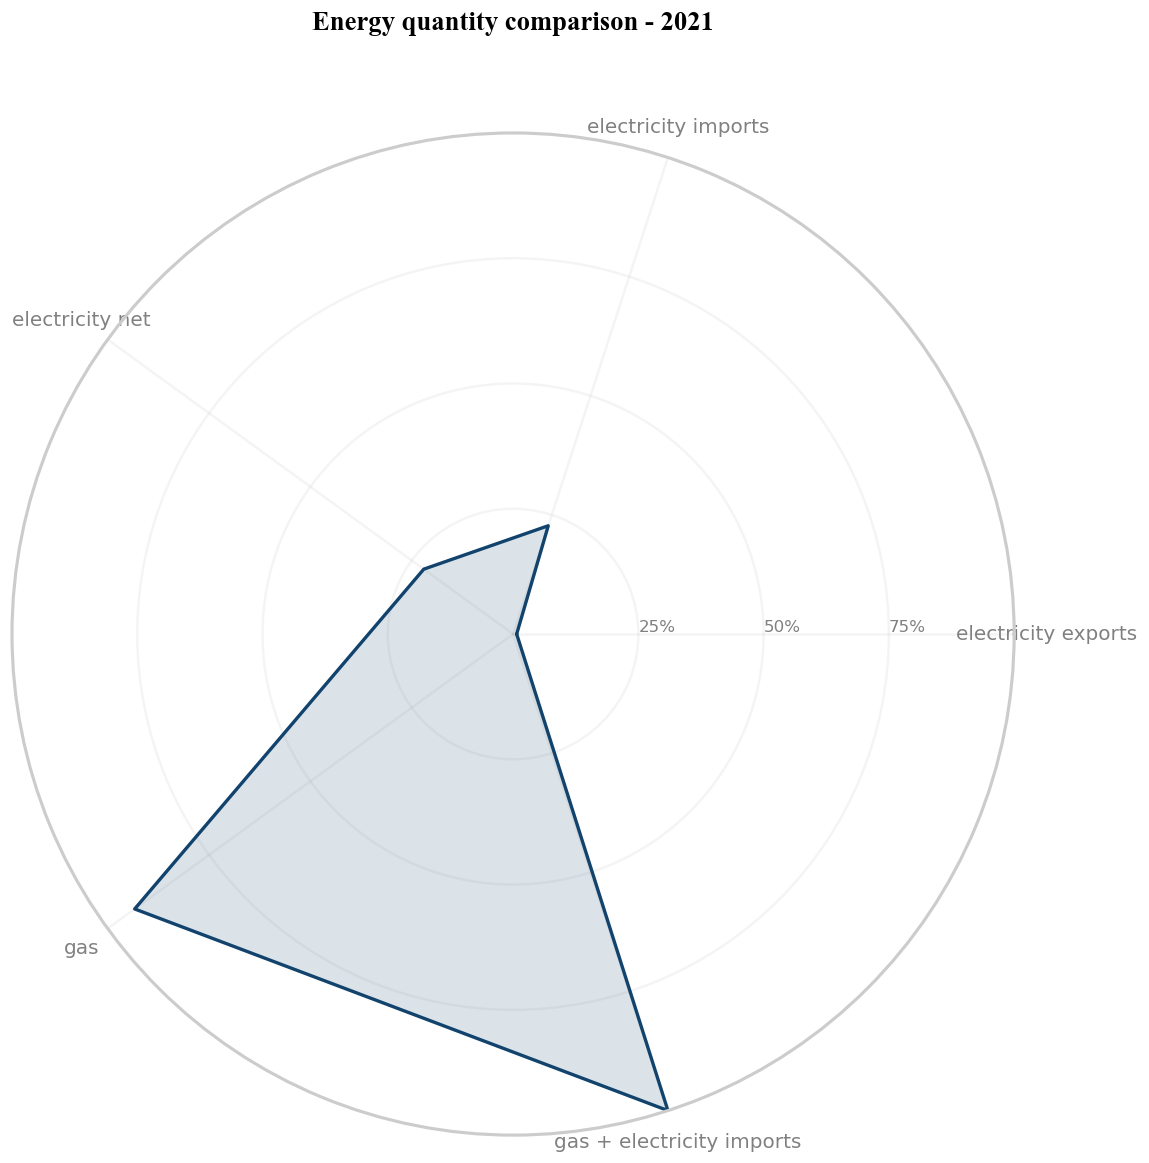

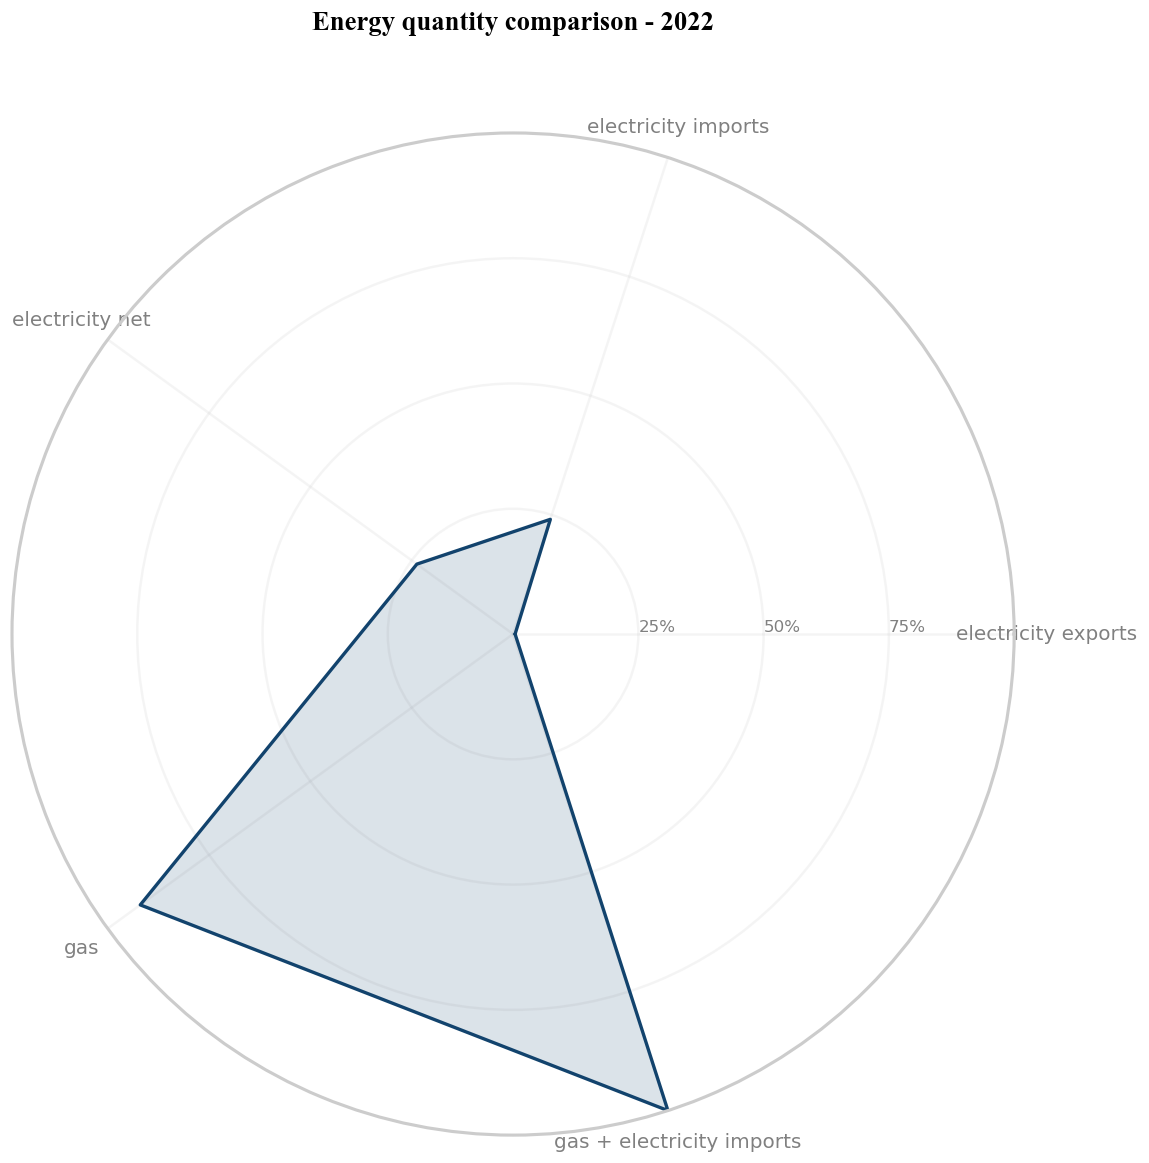

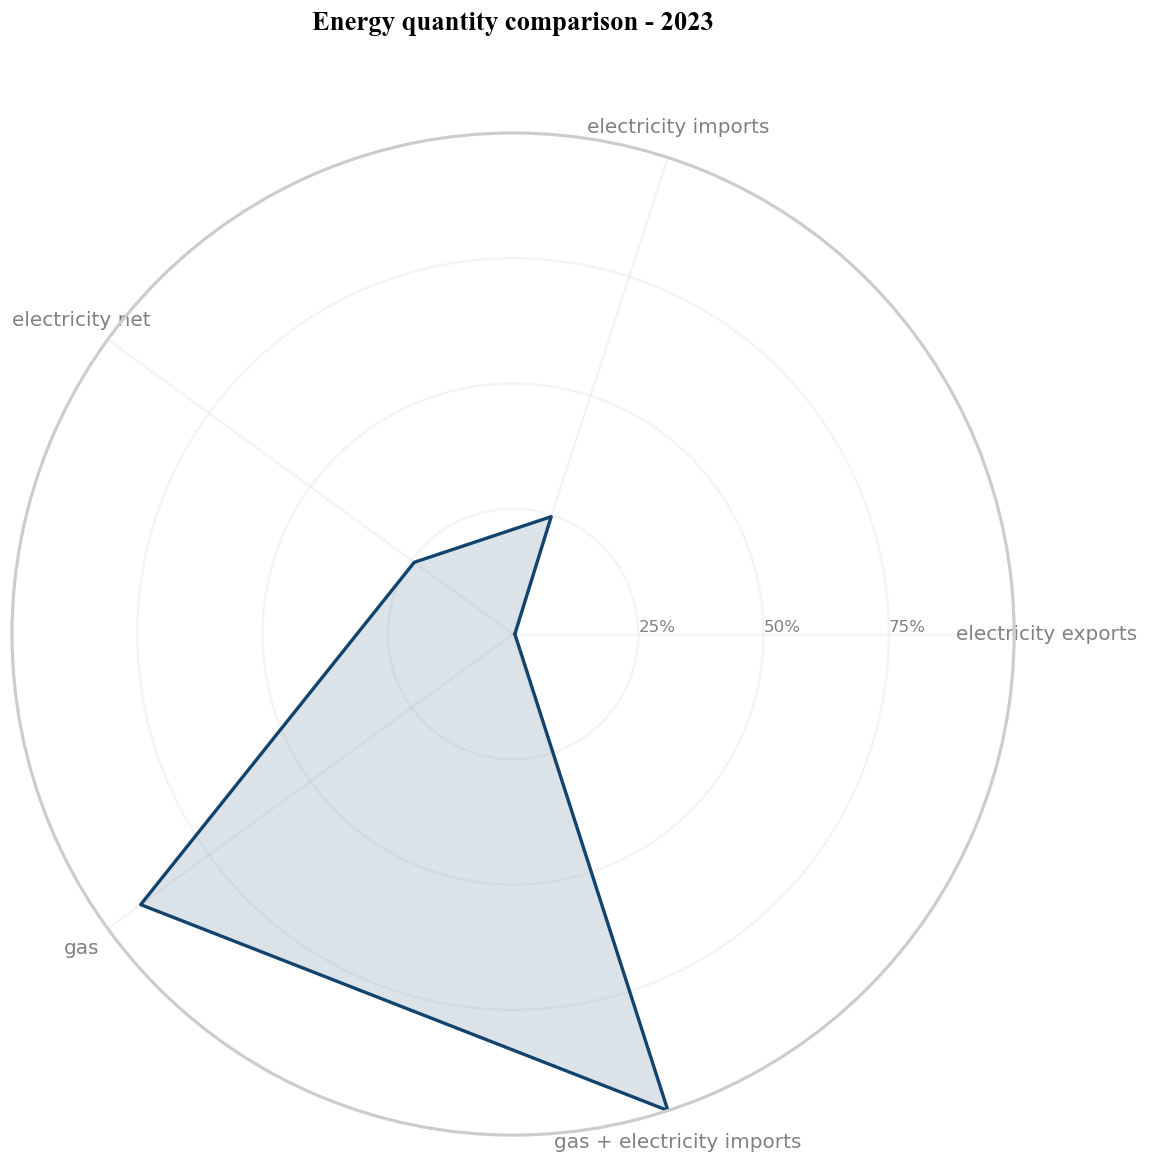

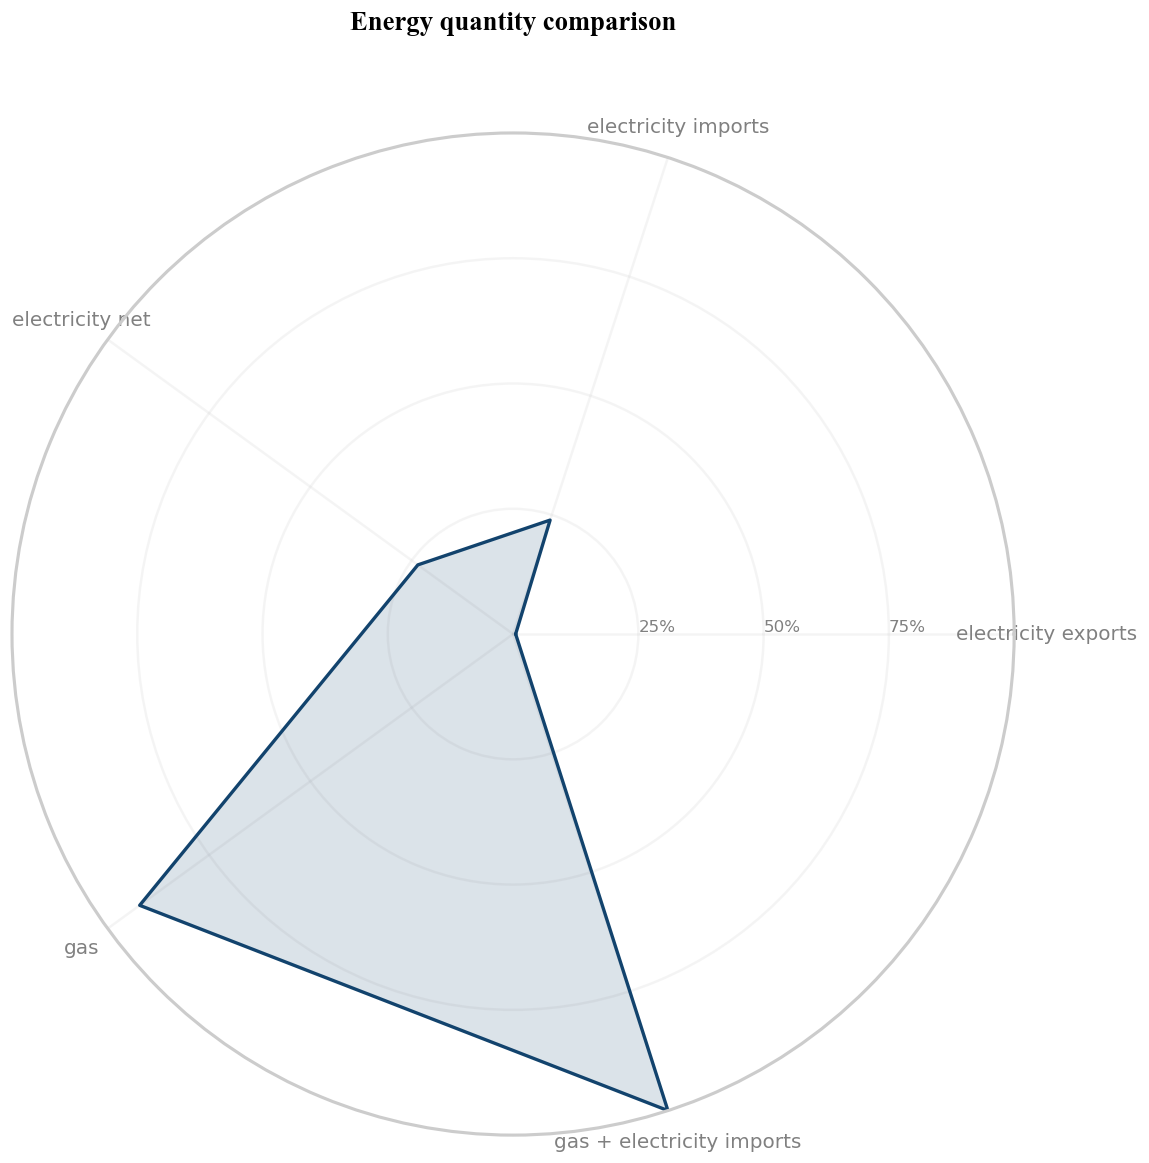


📊 Creating bar chart comparisons...


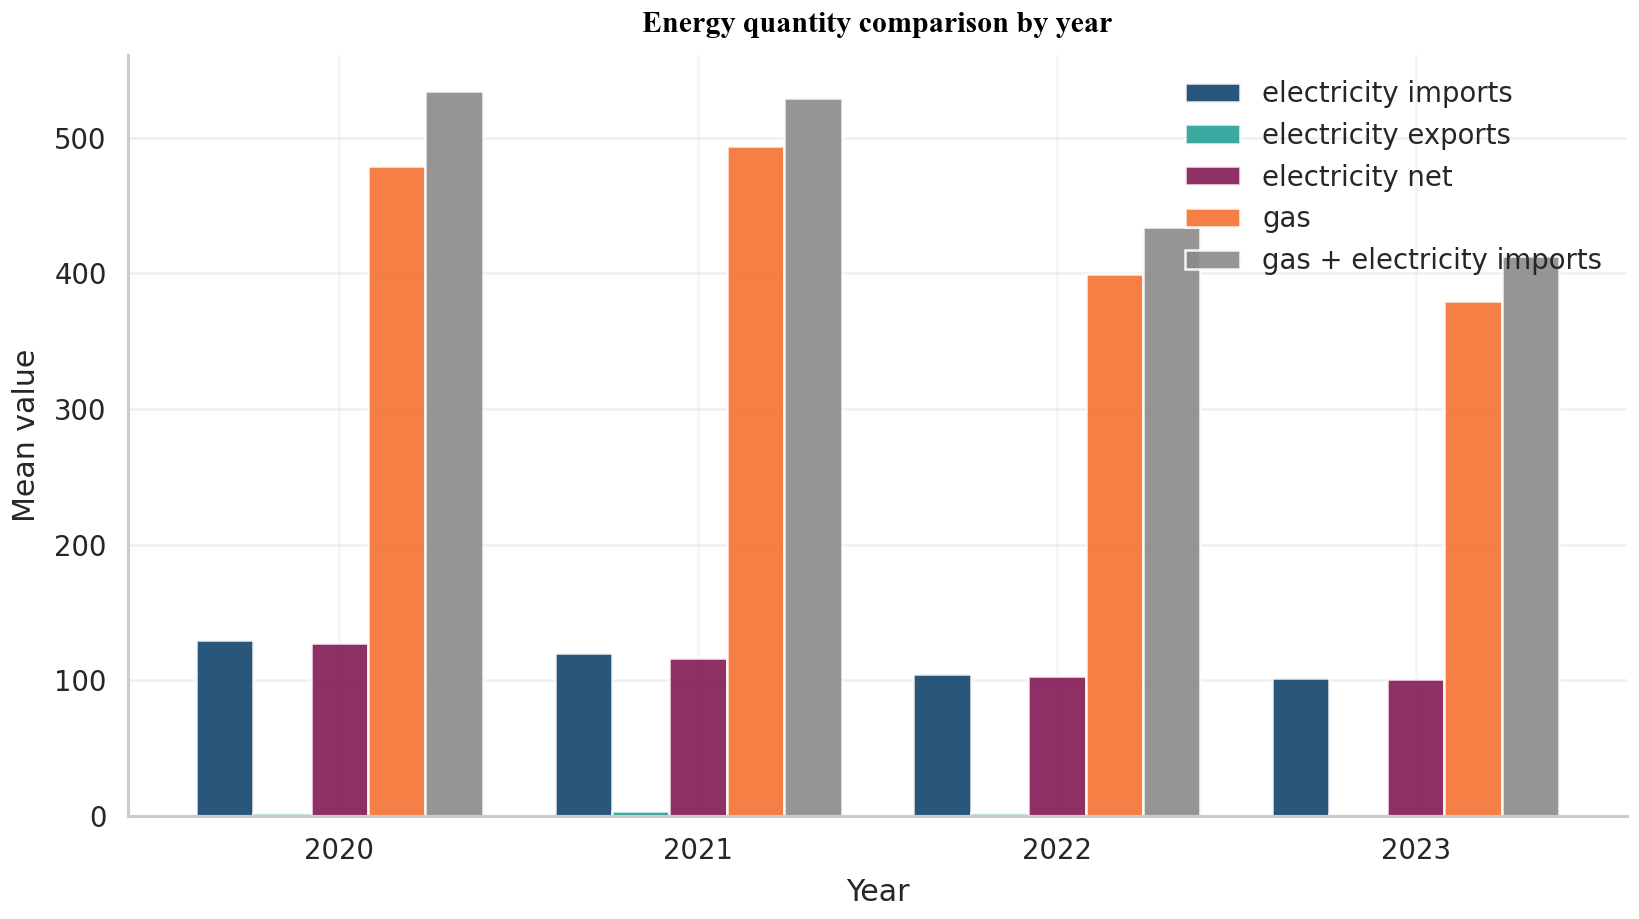


📋 Generating descriptive statistics...
DESCRIPTIVE STATISTICS FOR ENERGY QUANTITIES

ELECTRICITY IMPORTS:
  Number of records: 392,256
  Mean of means: 121.9046
  Median of means: 98.0883
  Std dev of means: 128.9935
  Min mean: 0.2263
  Max mean: 1445.8429
  Yearly breakdown:
    2020: mean=135.2724, std=139.8747, n=75390
    2021: mean=132.5141, std=140.3593, n=84233
    2022: mean=111.4651, std=117.0947, n=82786
    2023: mean=109.4068, std=115.1281, n=82992

ELECTRICITY EXPORTS:
  Number of records: 392,256
  Mean of means: 8.4537
  Median of means: 0.0000
  Std dev of means: 40.1802
  Min mean: 0.0000
  Max mean: 744.7246
  Yearly breakdown:
    2020: mean=9.5945, std=38.3453, n=73175
    2021: mean=13.2499, std=49.6233, n=84080
    2022: mean=6.2374, std=38.3966, n=69662
    2023: mean=3.5528, std=28.3474, n=67816

ELECTRICITY NET:
  Number of records: 392,256
  Mean of means: 114.1280
  Median of means: 93.8339
  Std dev of means: 132.3772
  Min mean: -716.7235
  Max mean: 1445

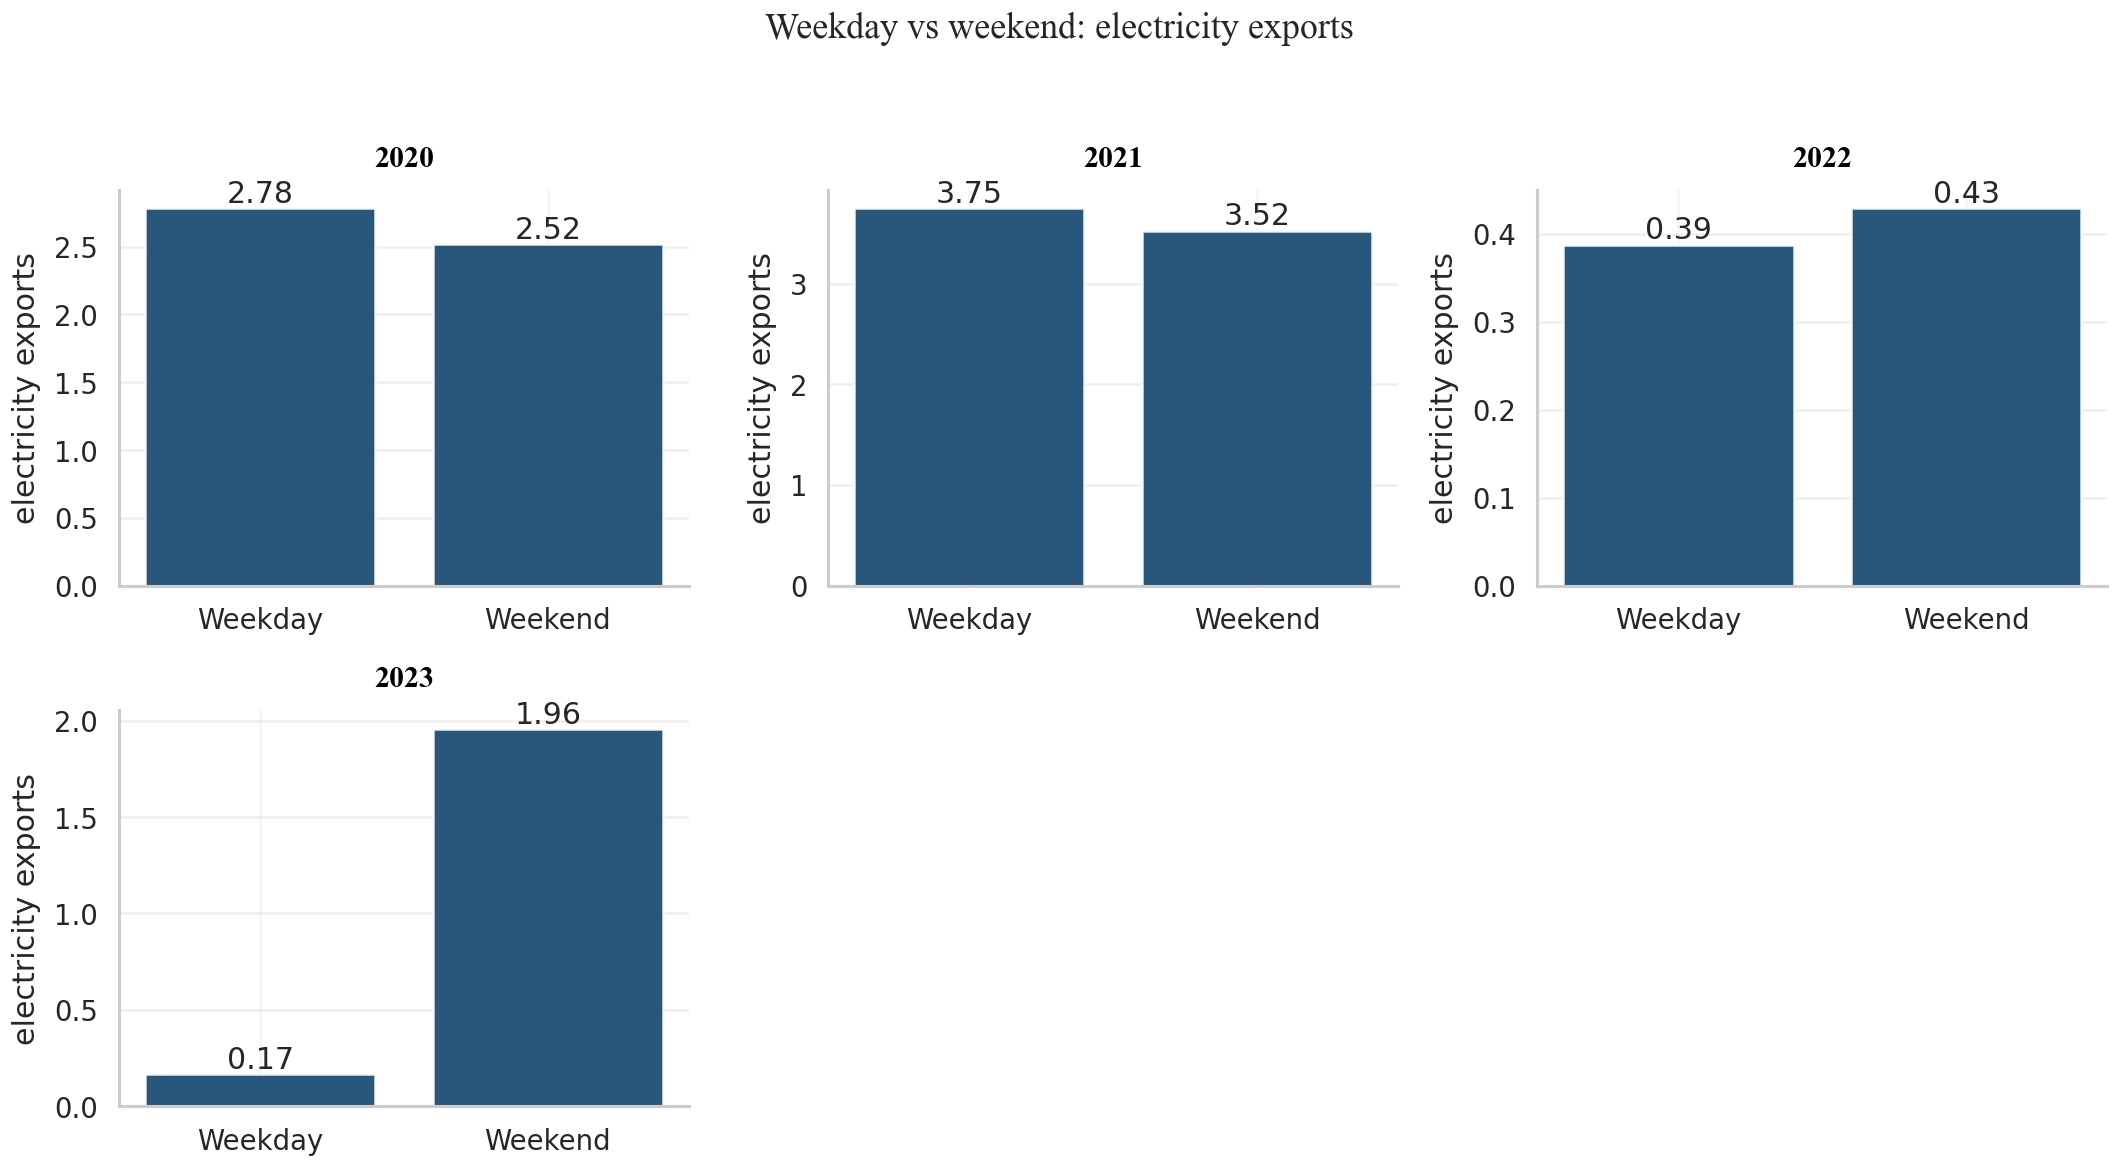

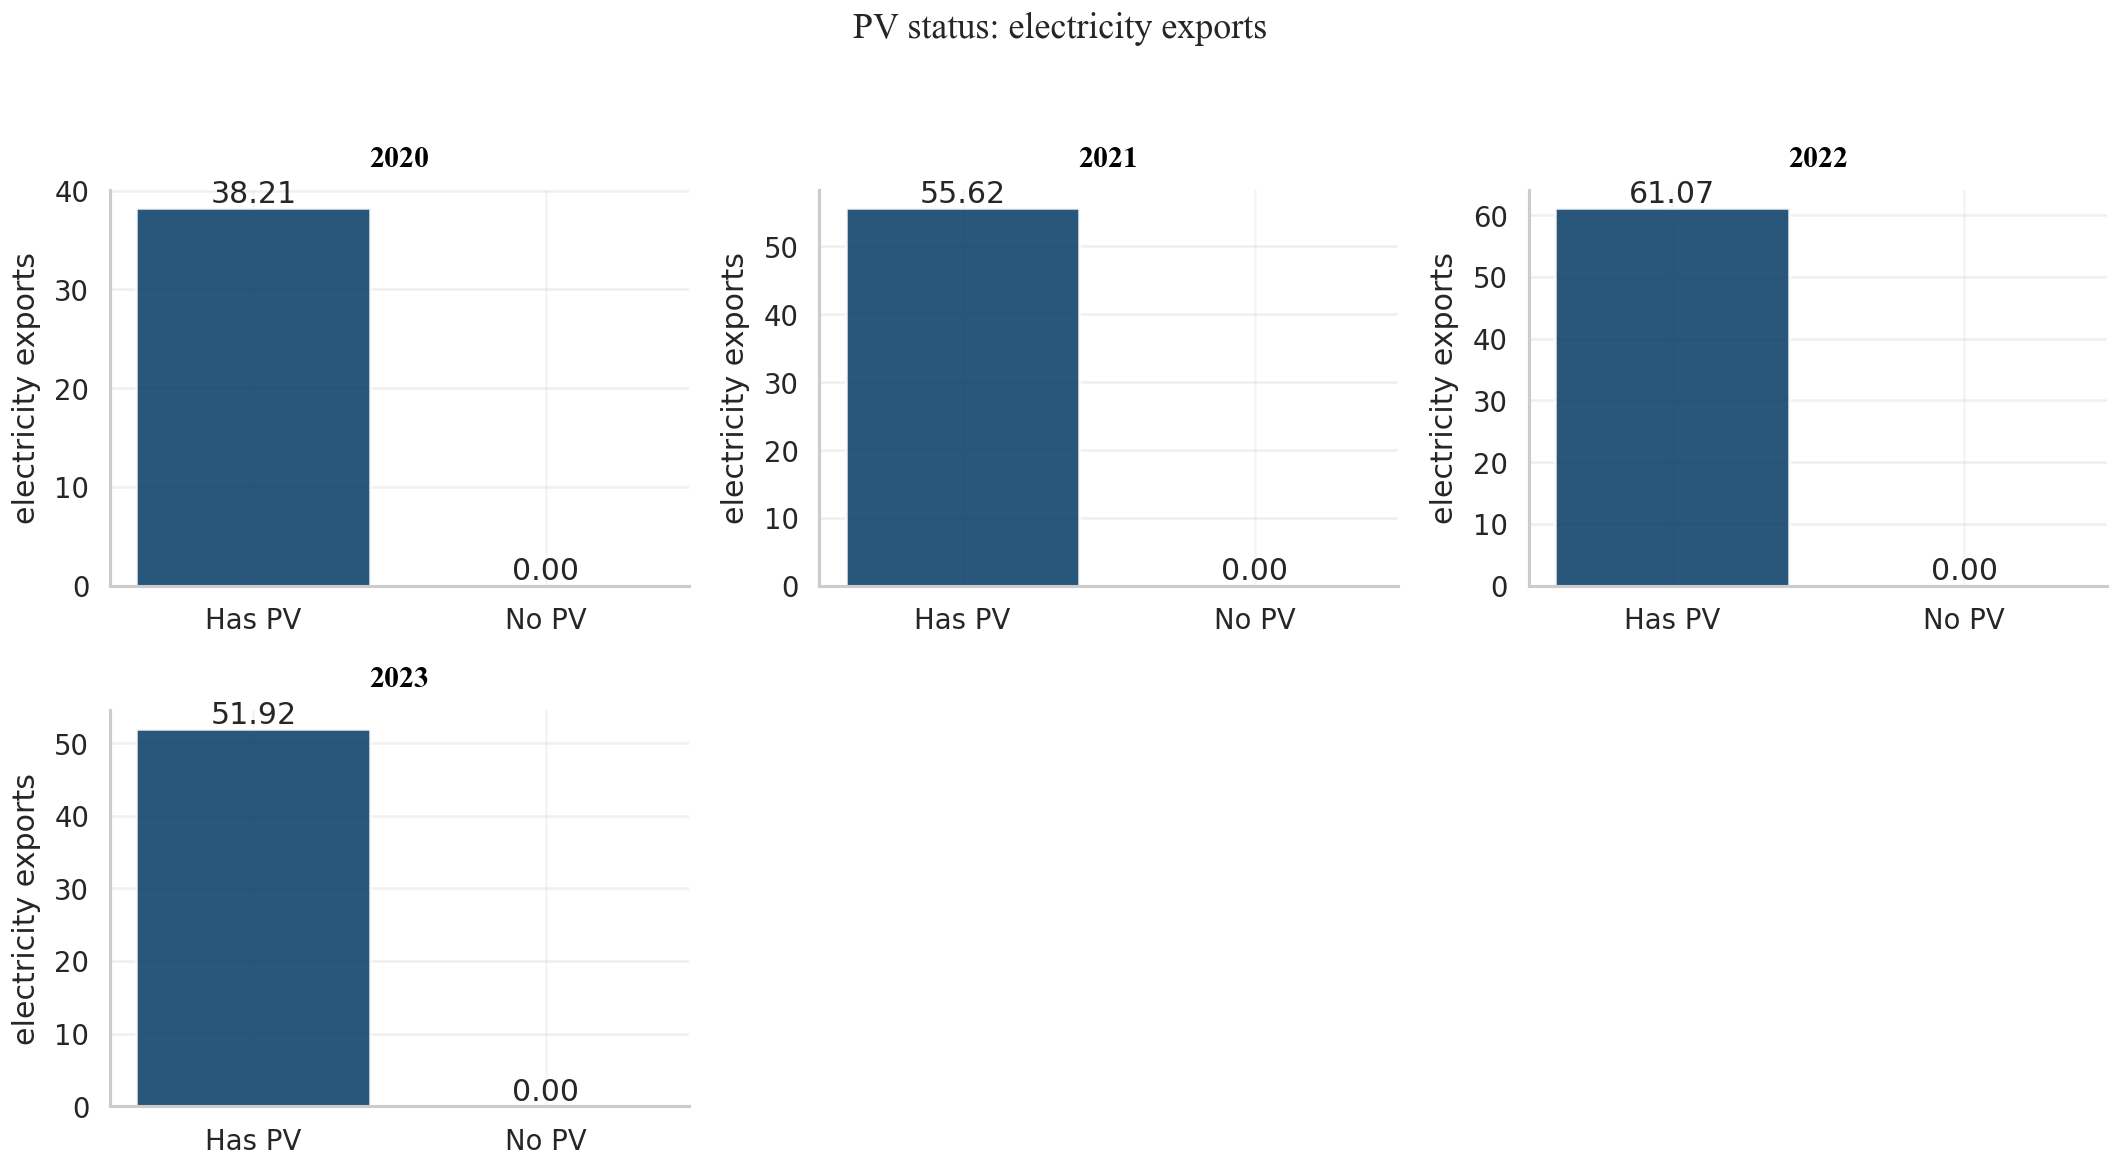

Processing quantity: electricity imports


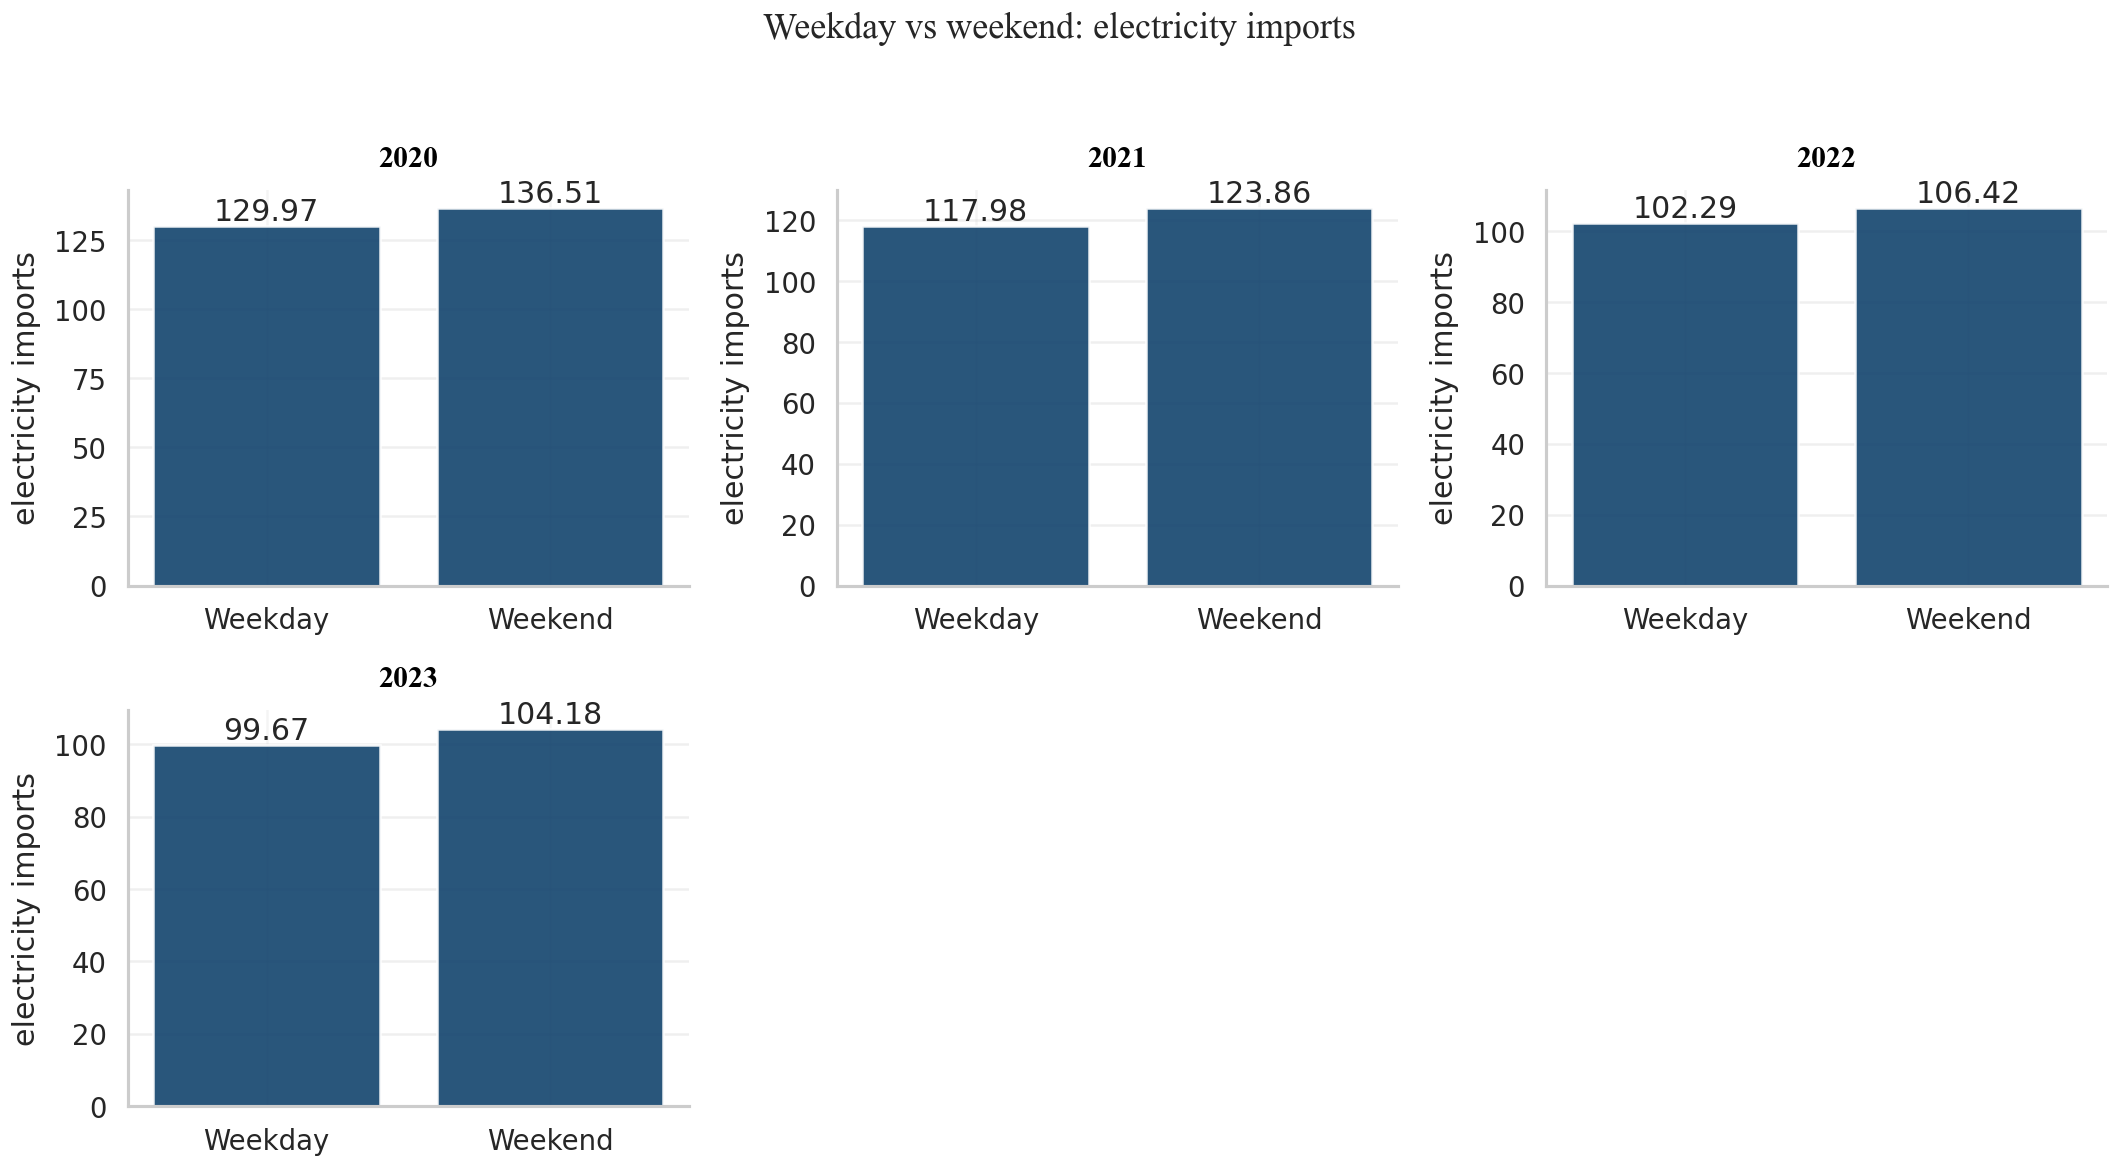

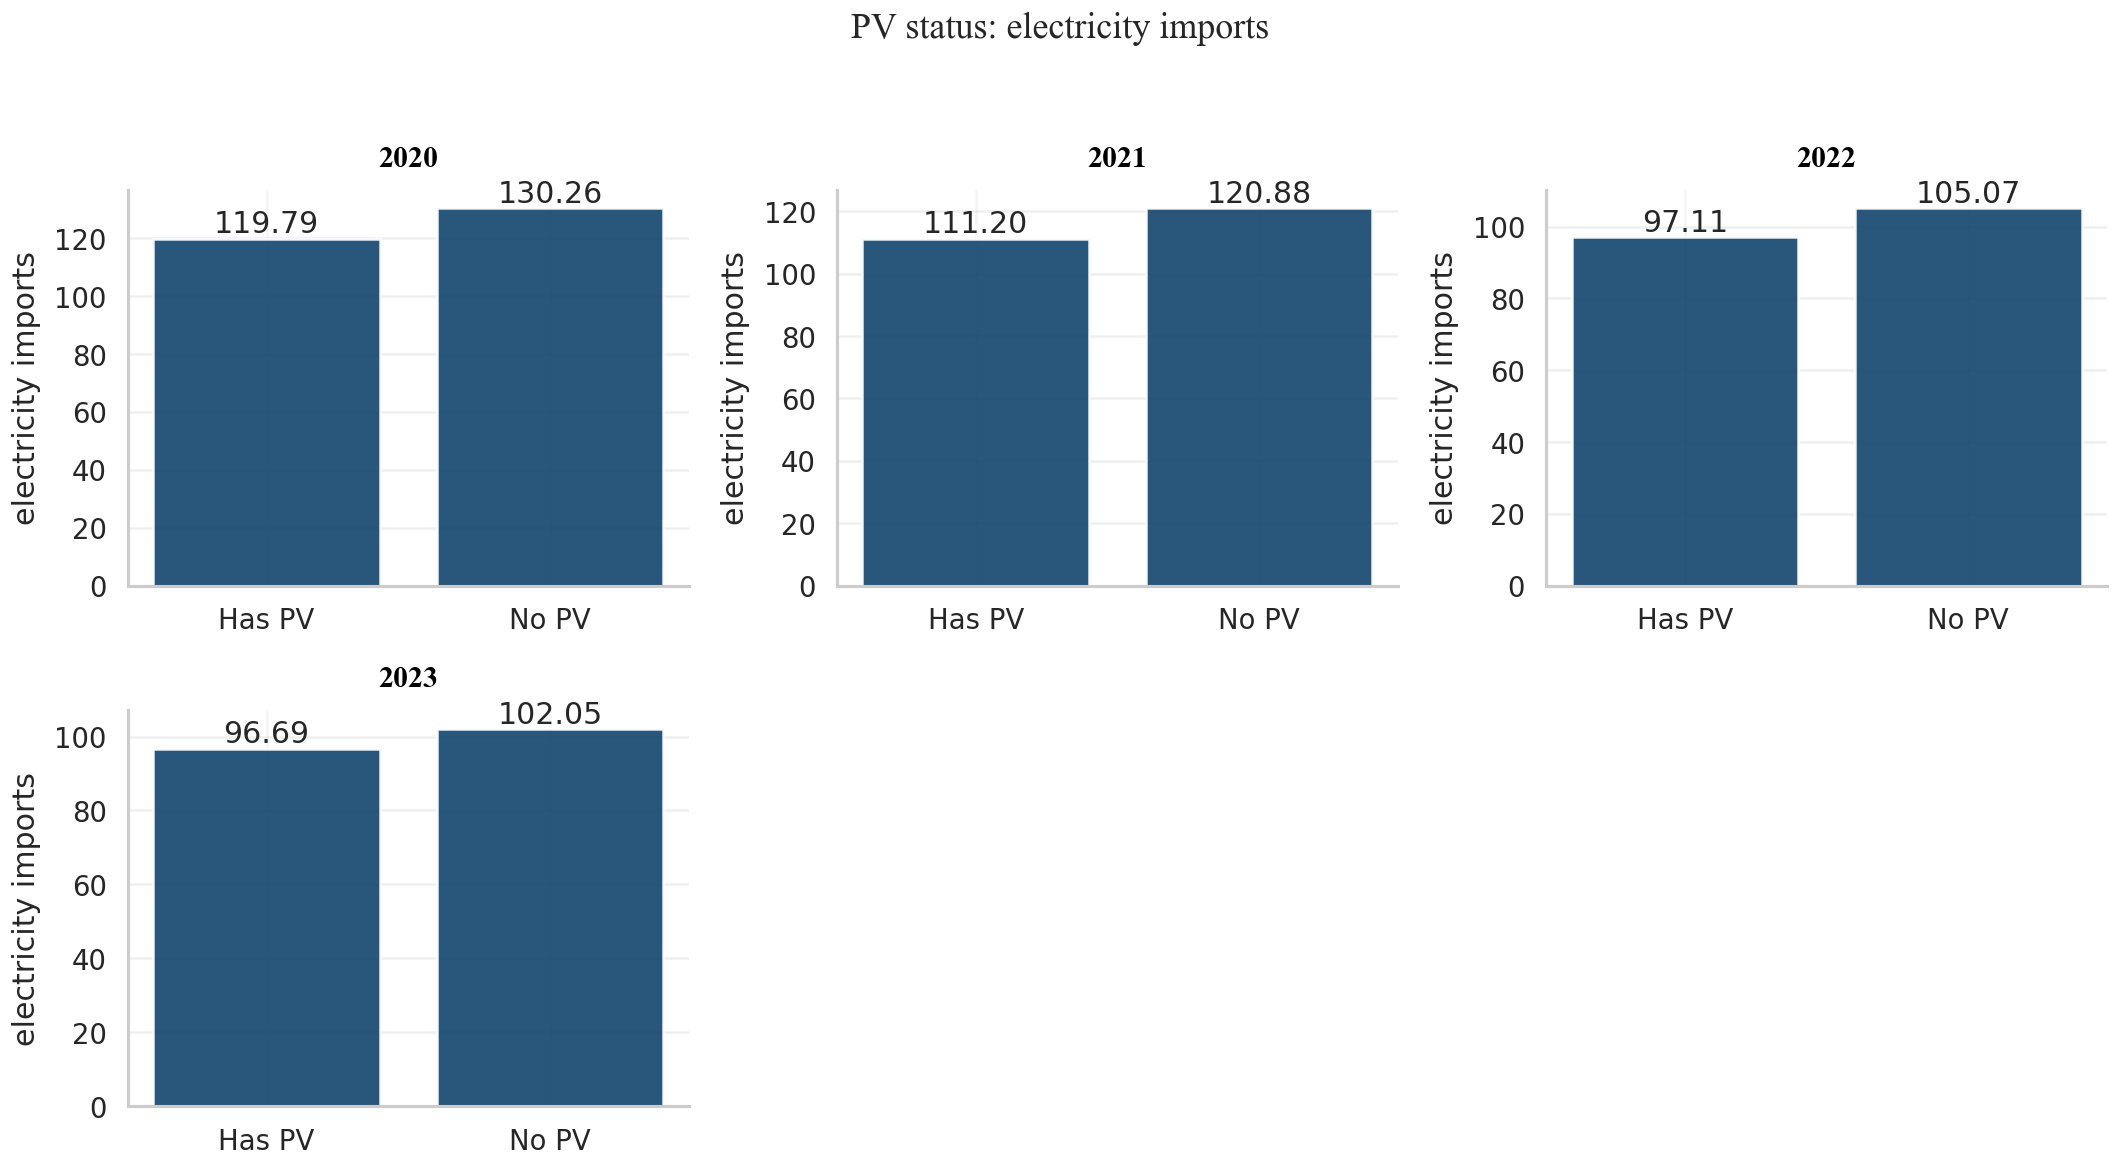

Processing quantity: electricity net


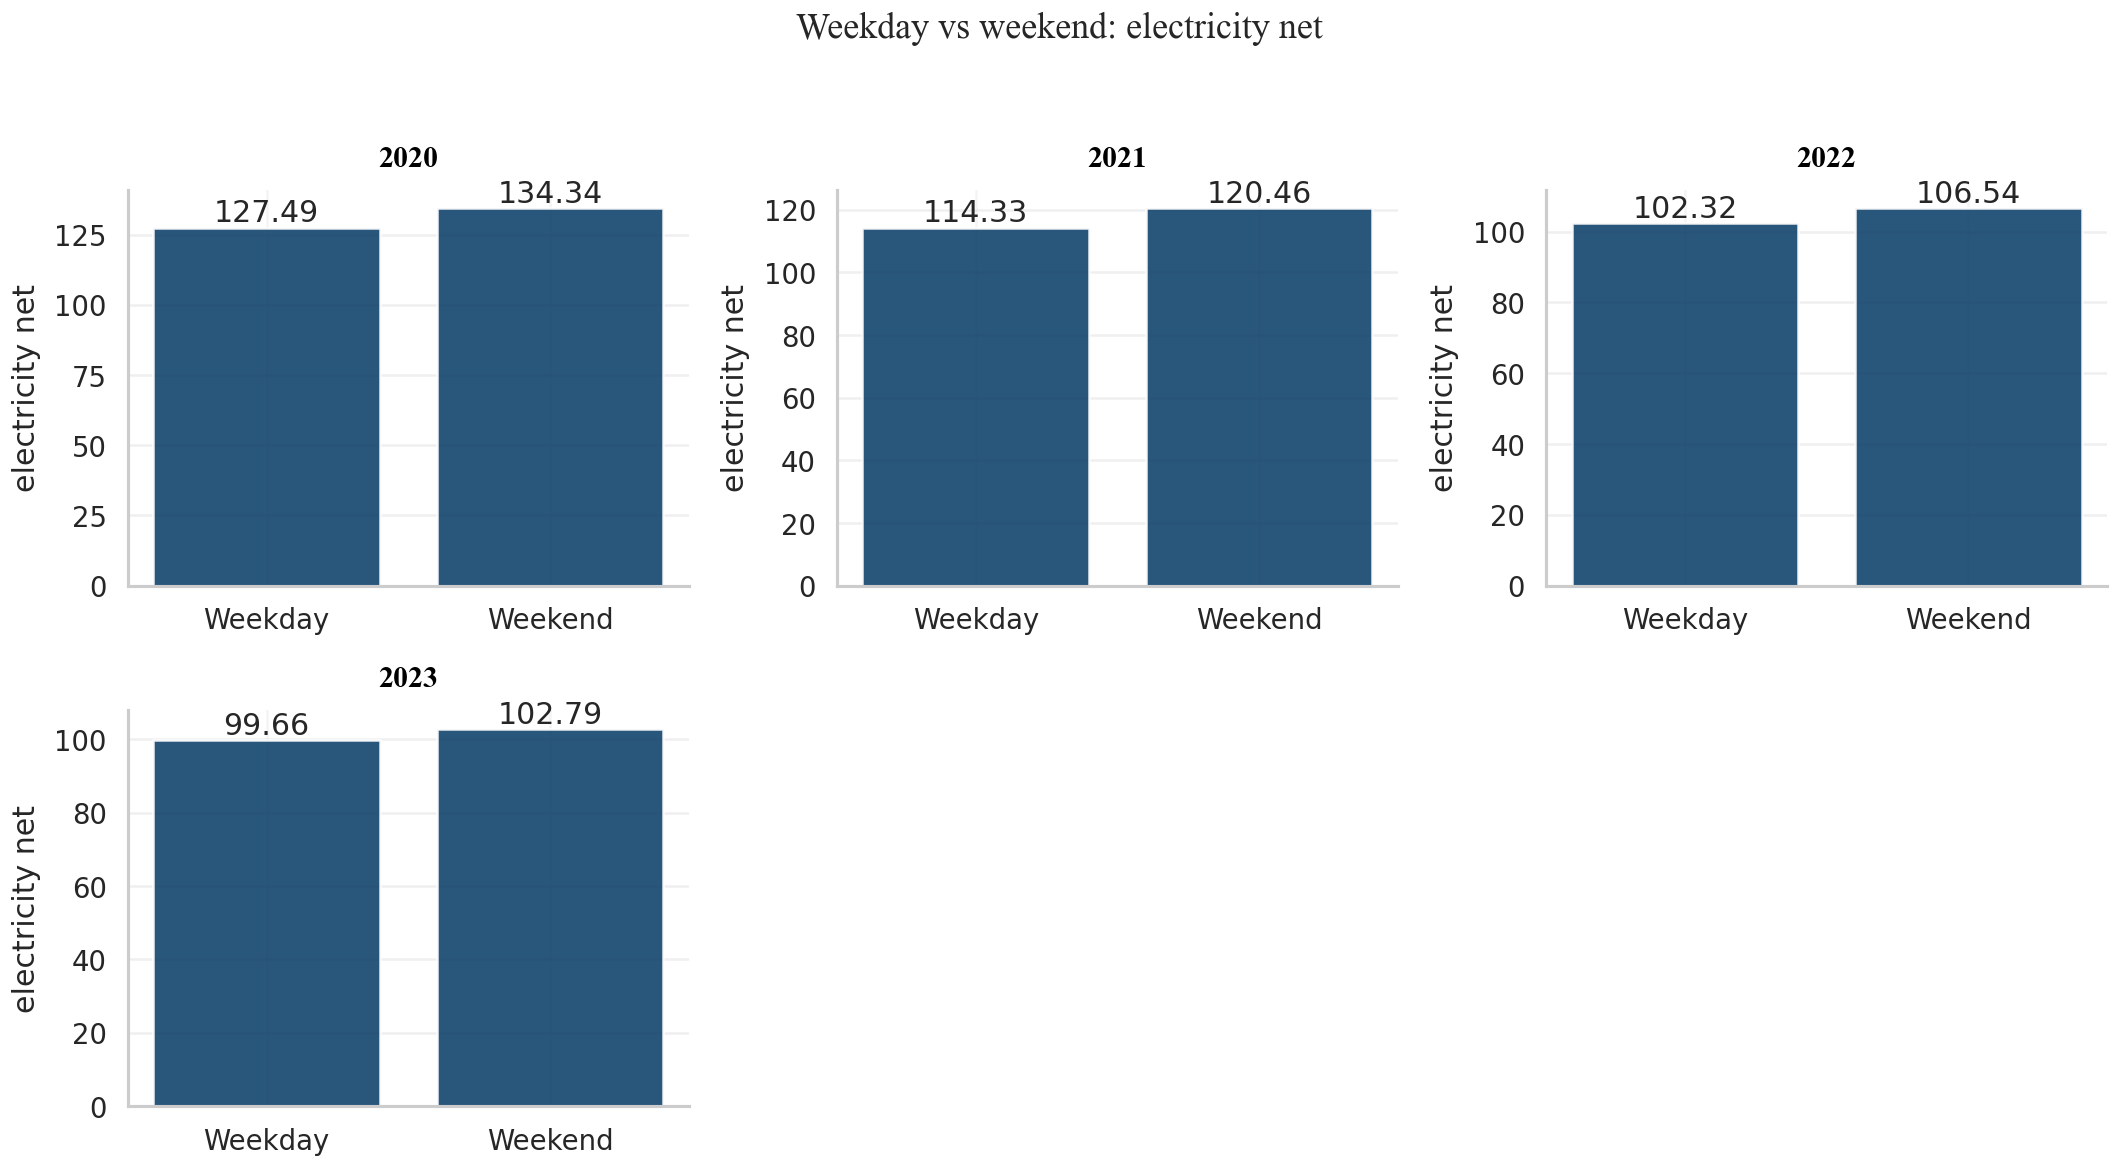

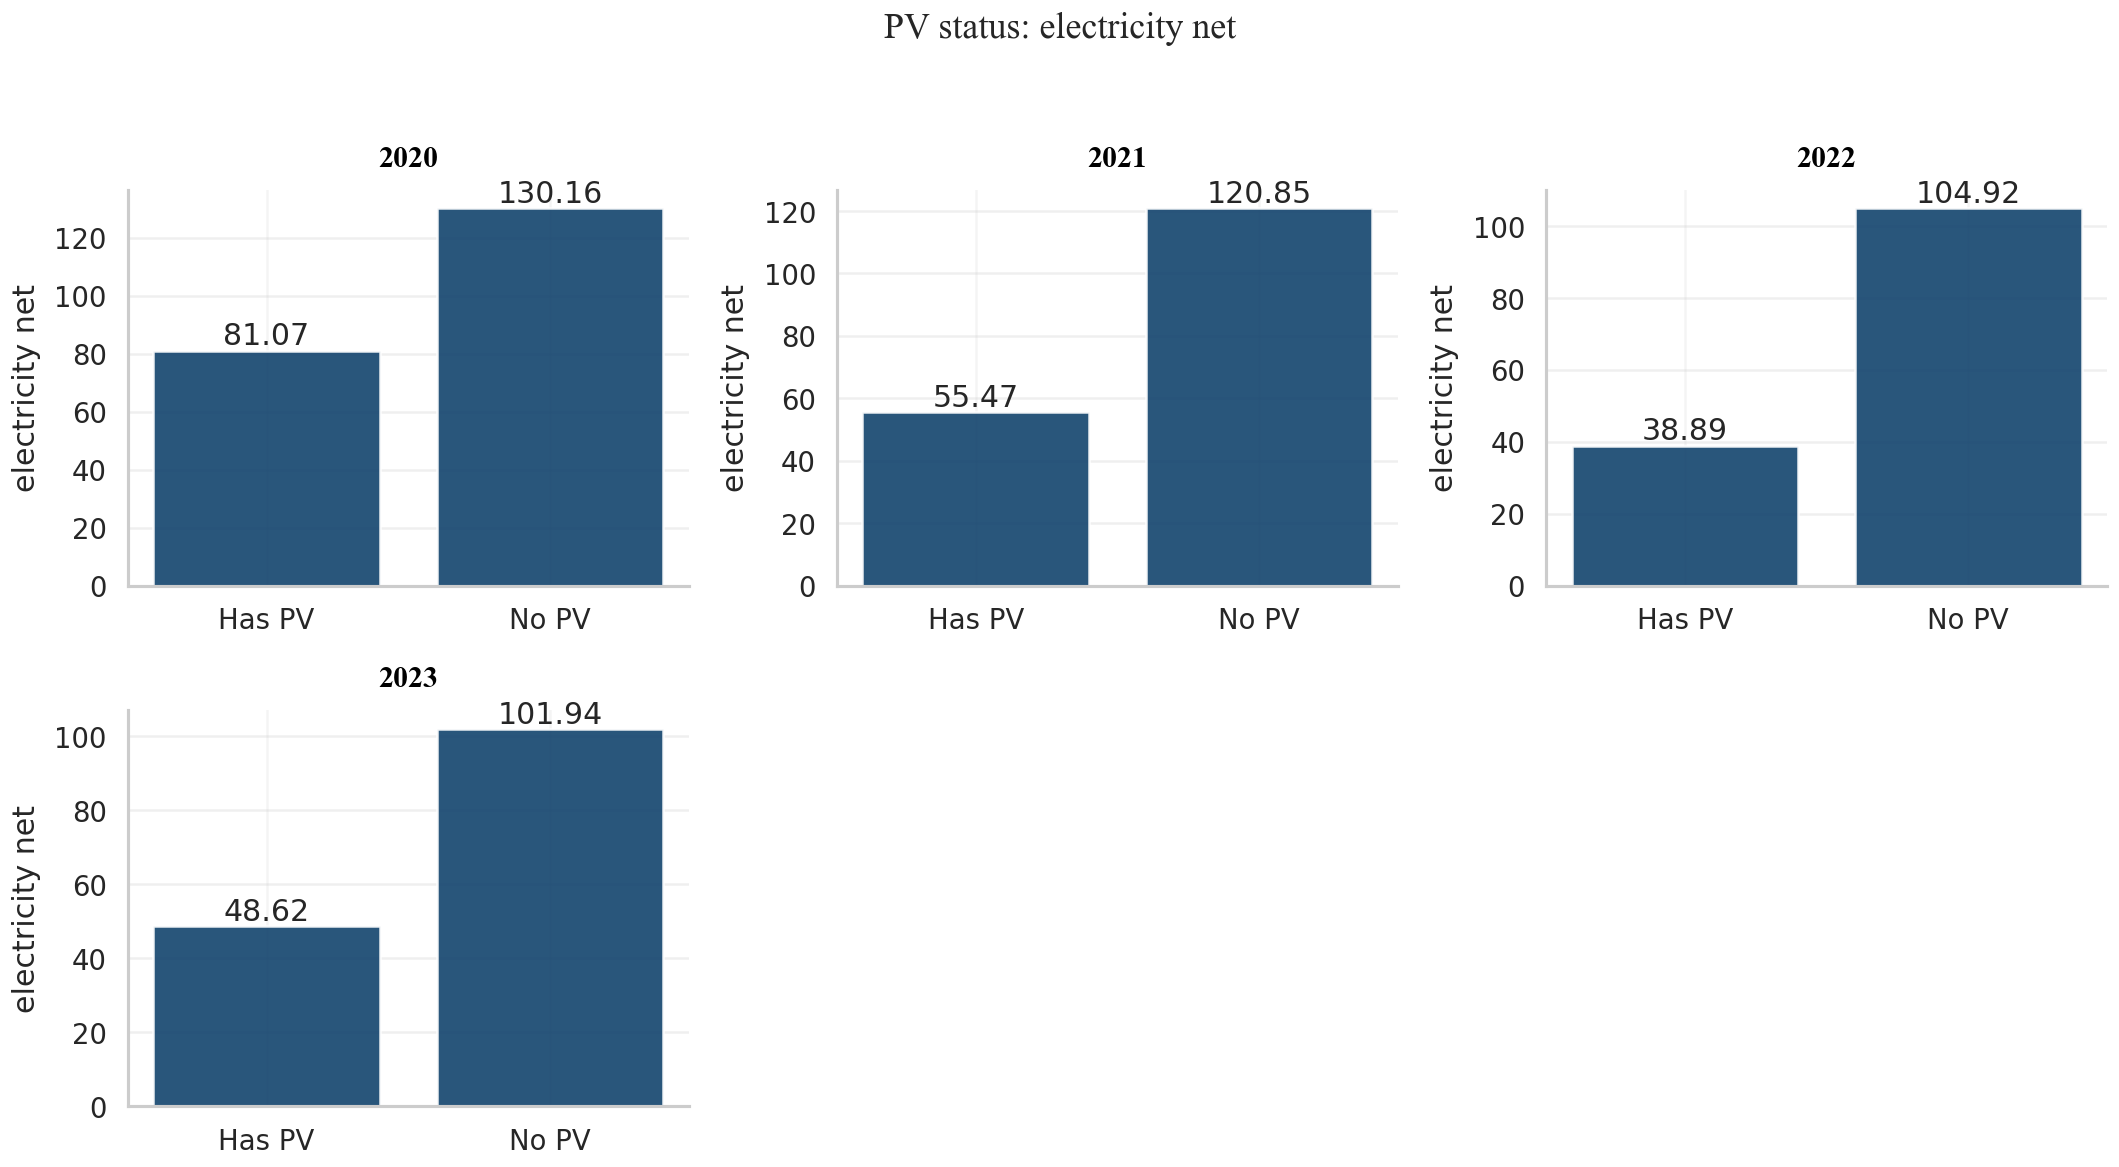

Processing quantity: gas


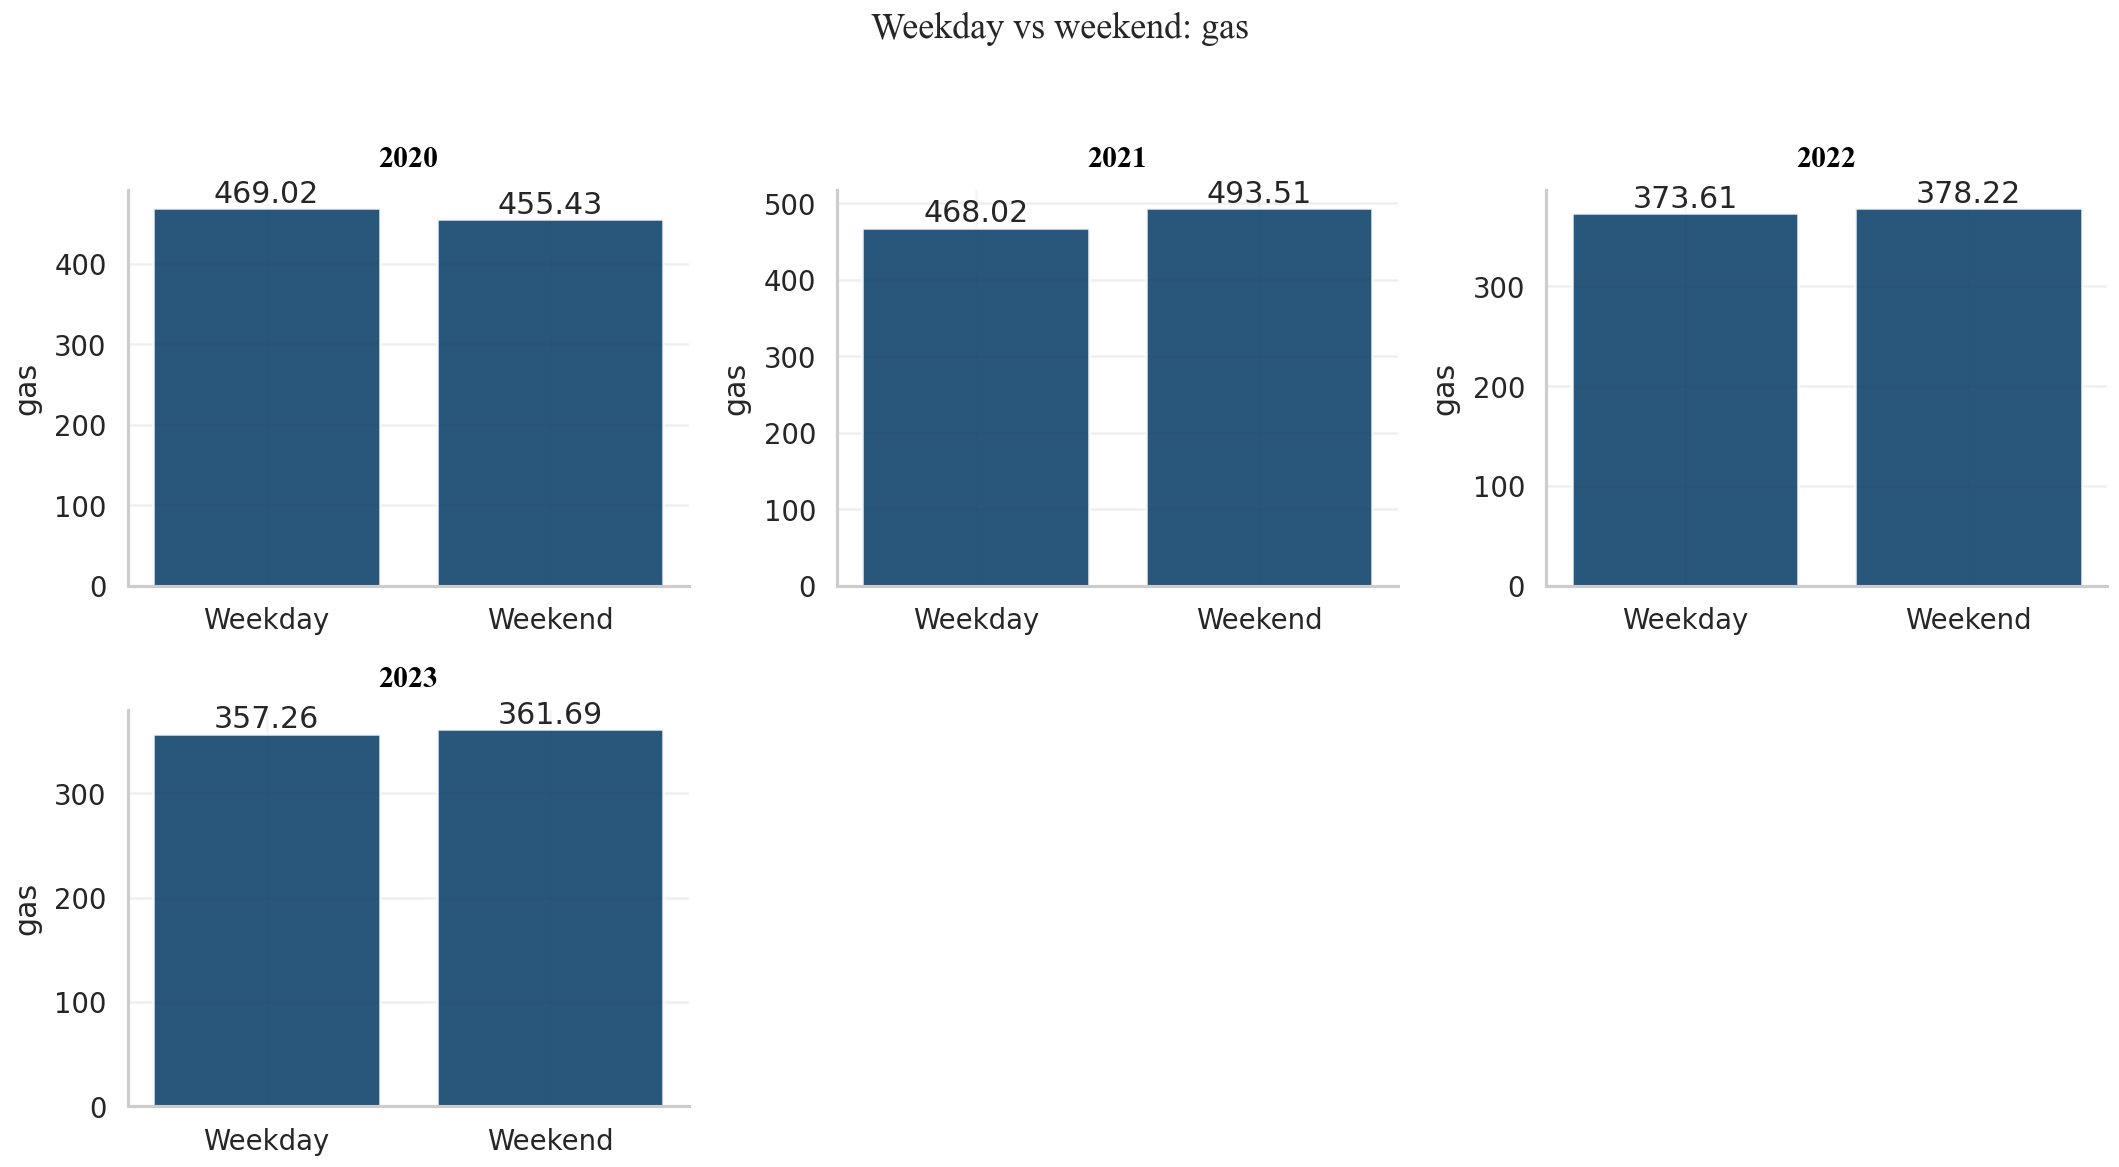

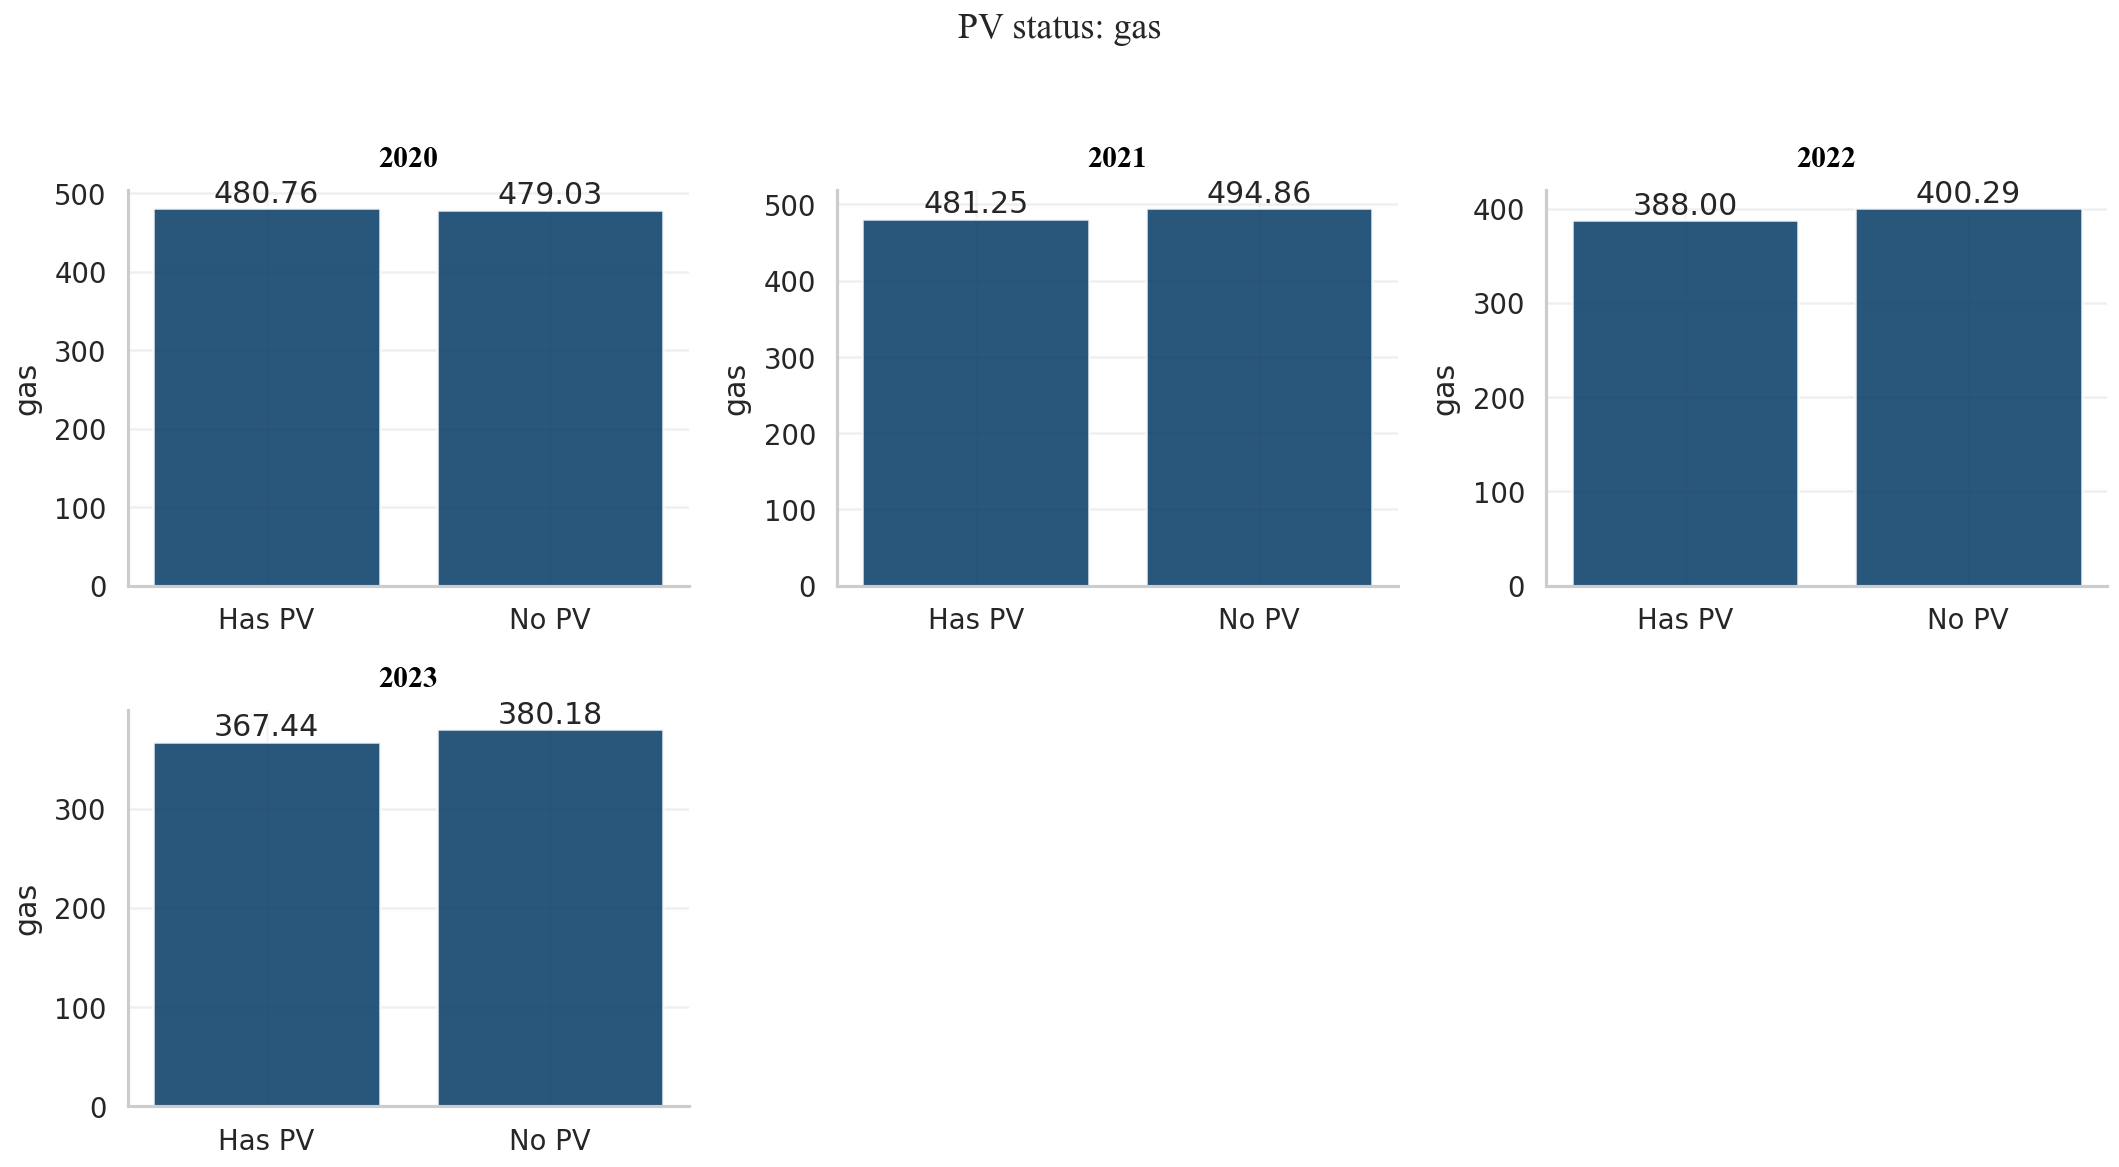

Processing quantity: gas + electricity imports


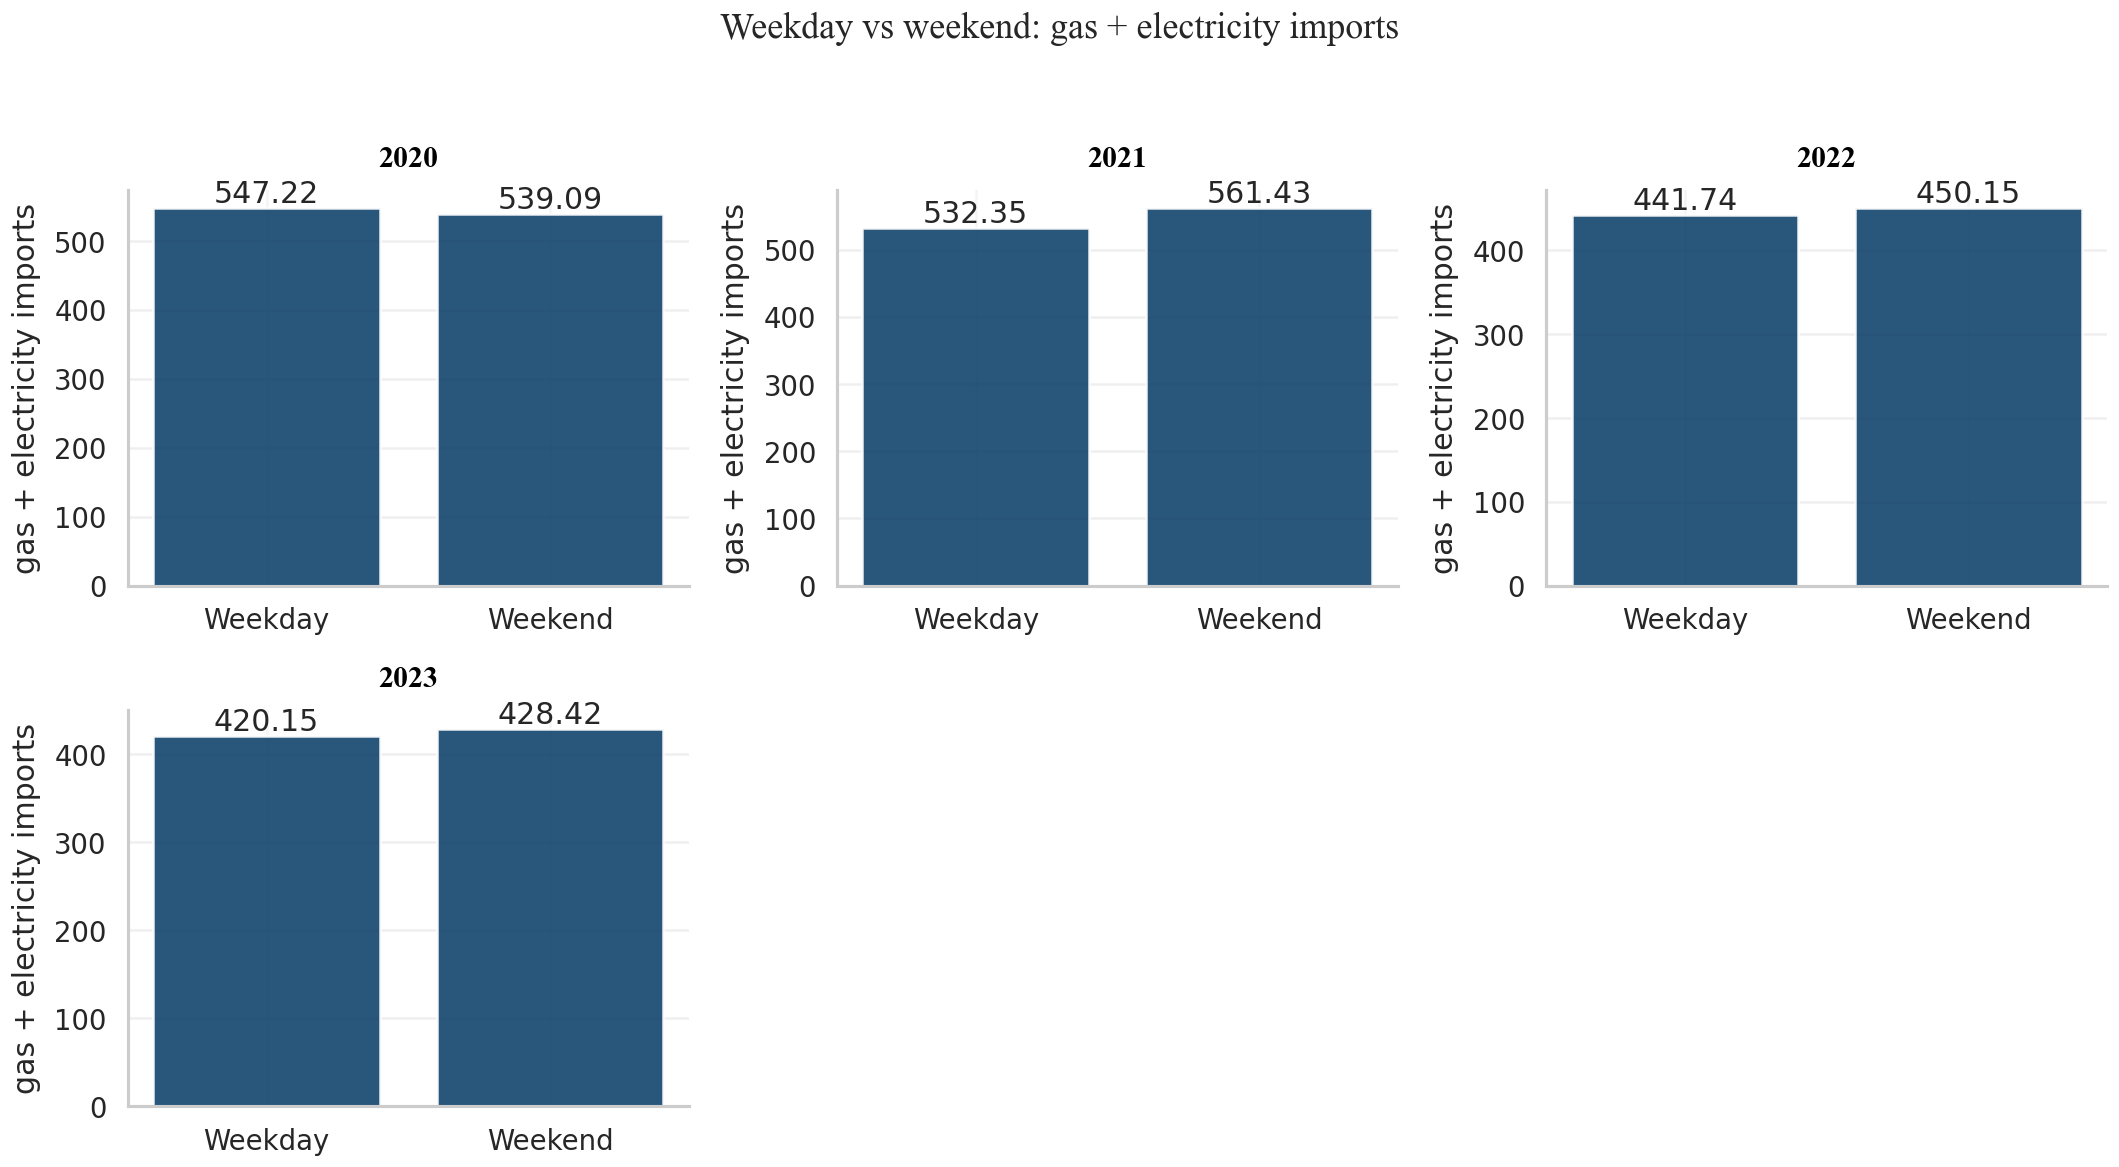

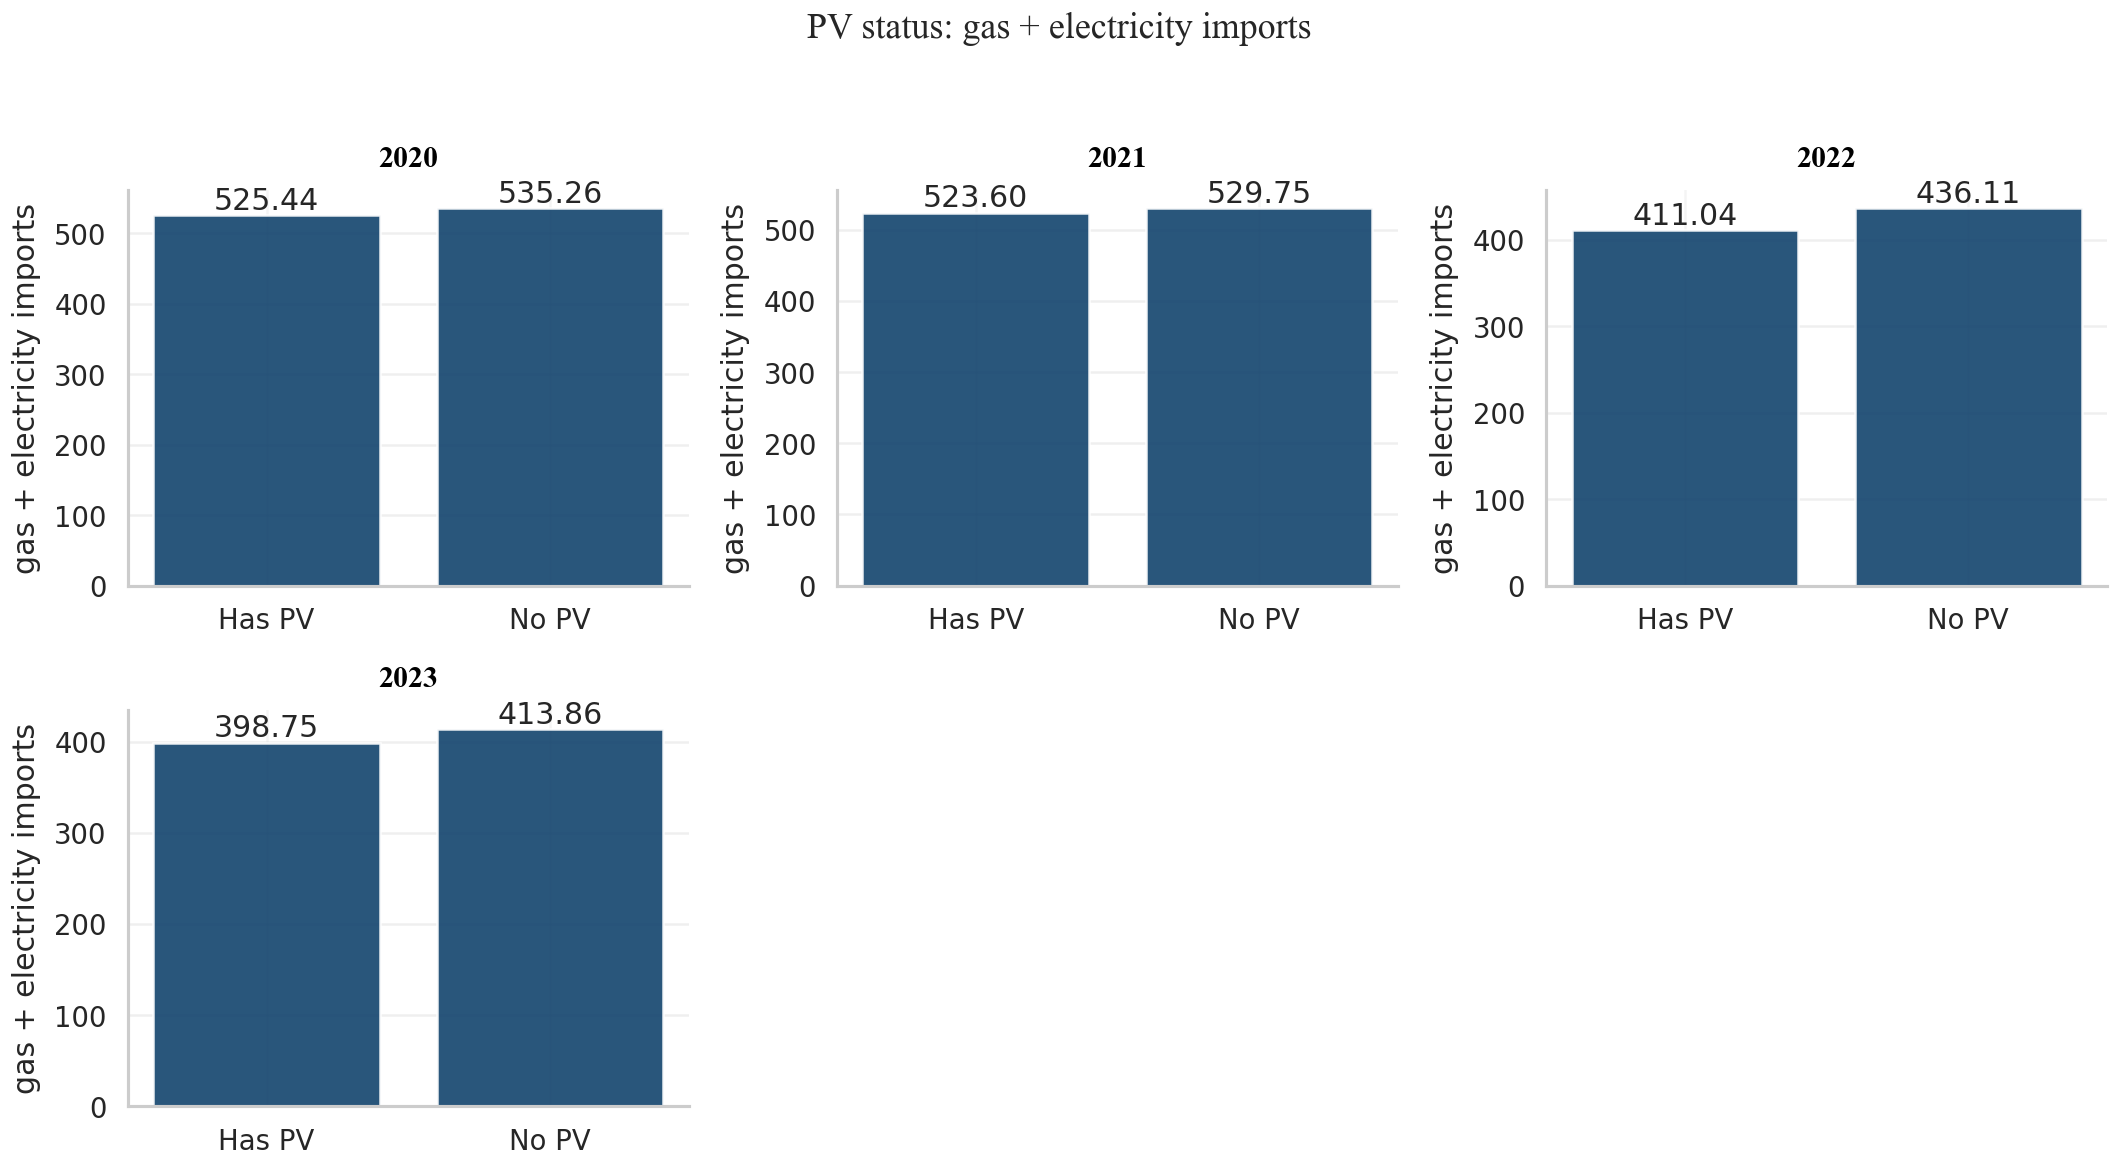


🪜 Creating cross-year comparison matrices...


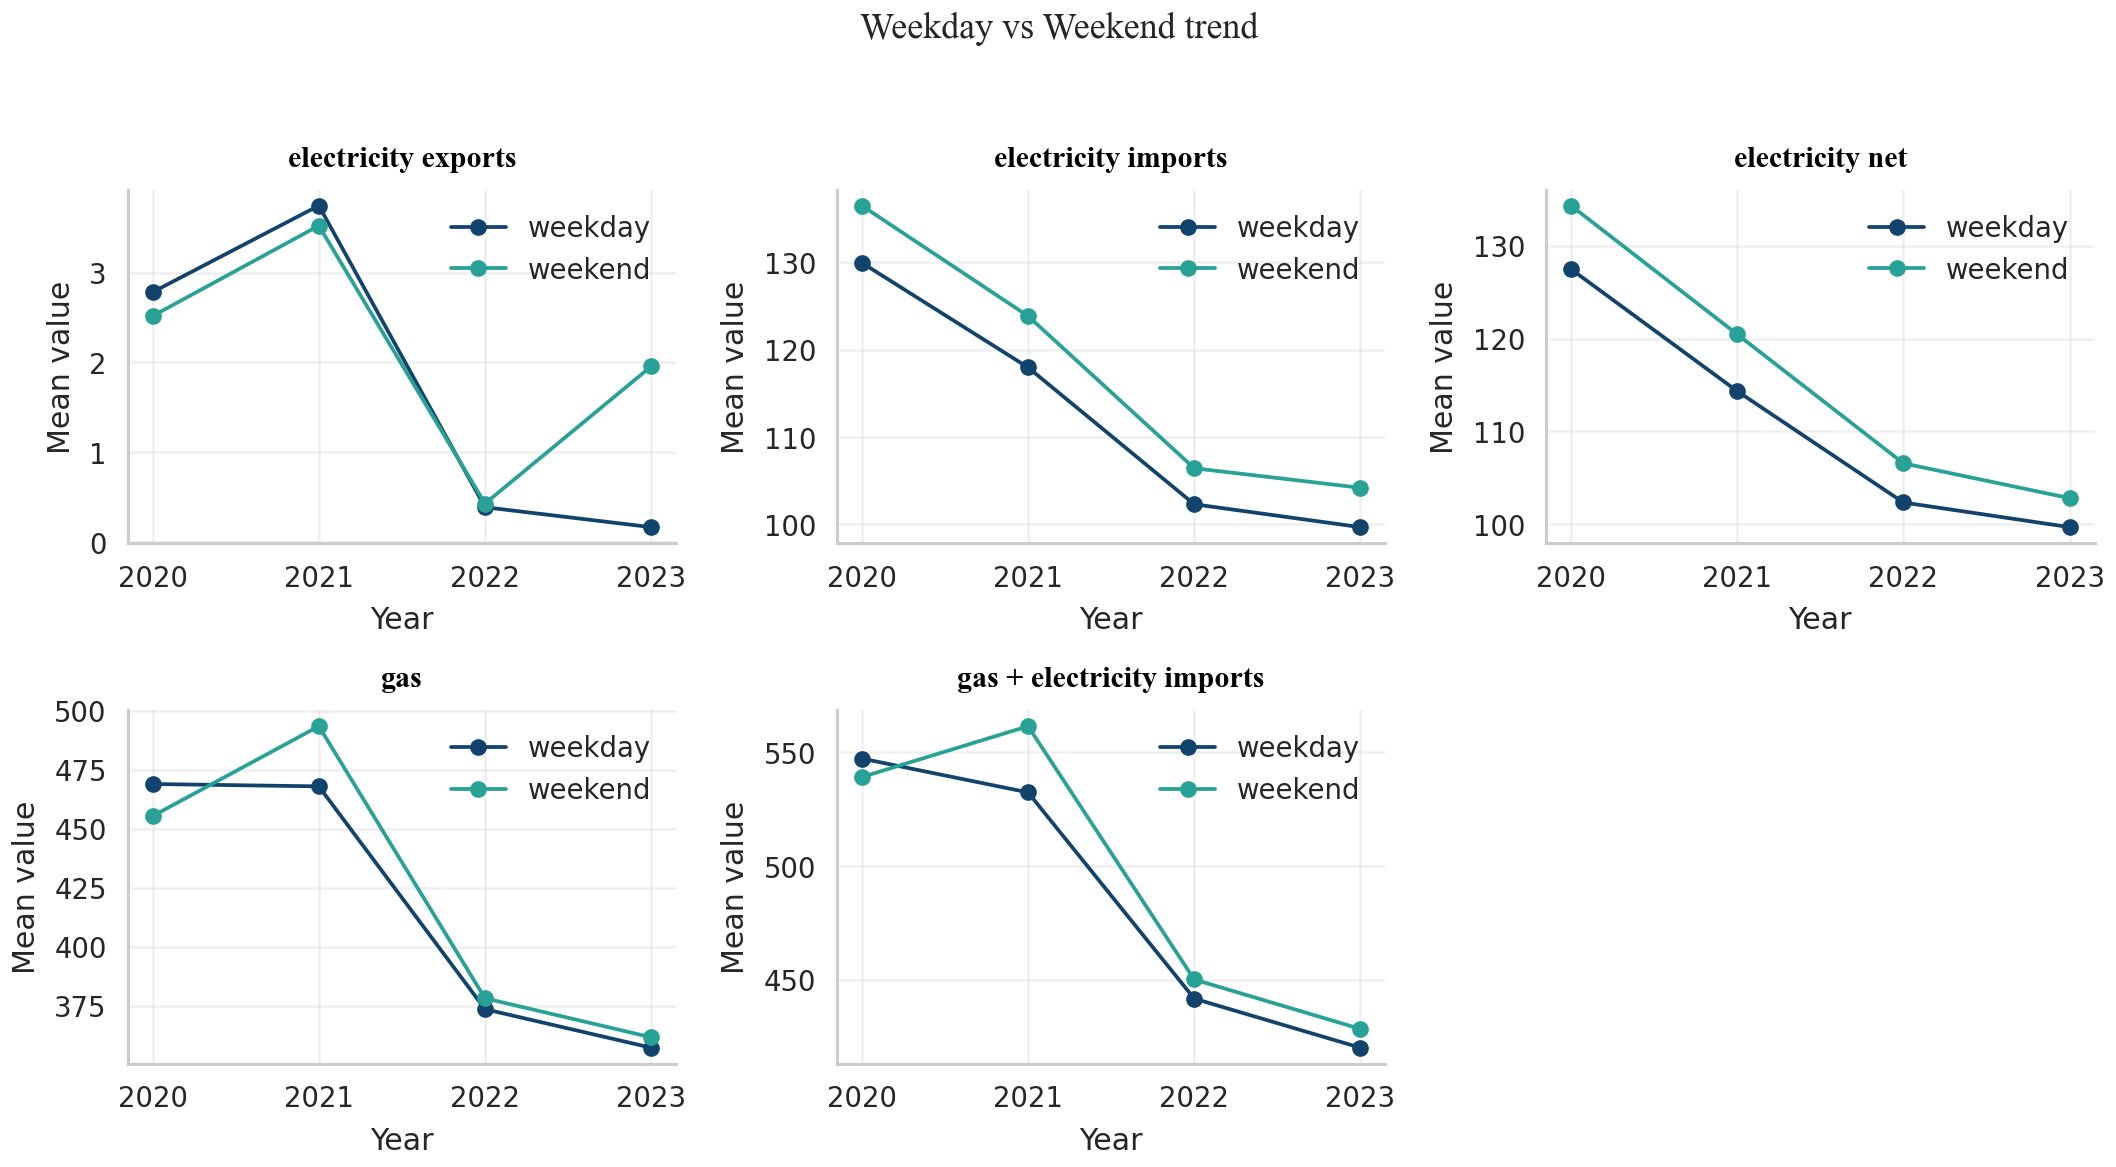

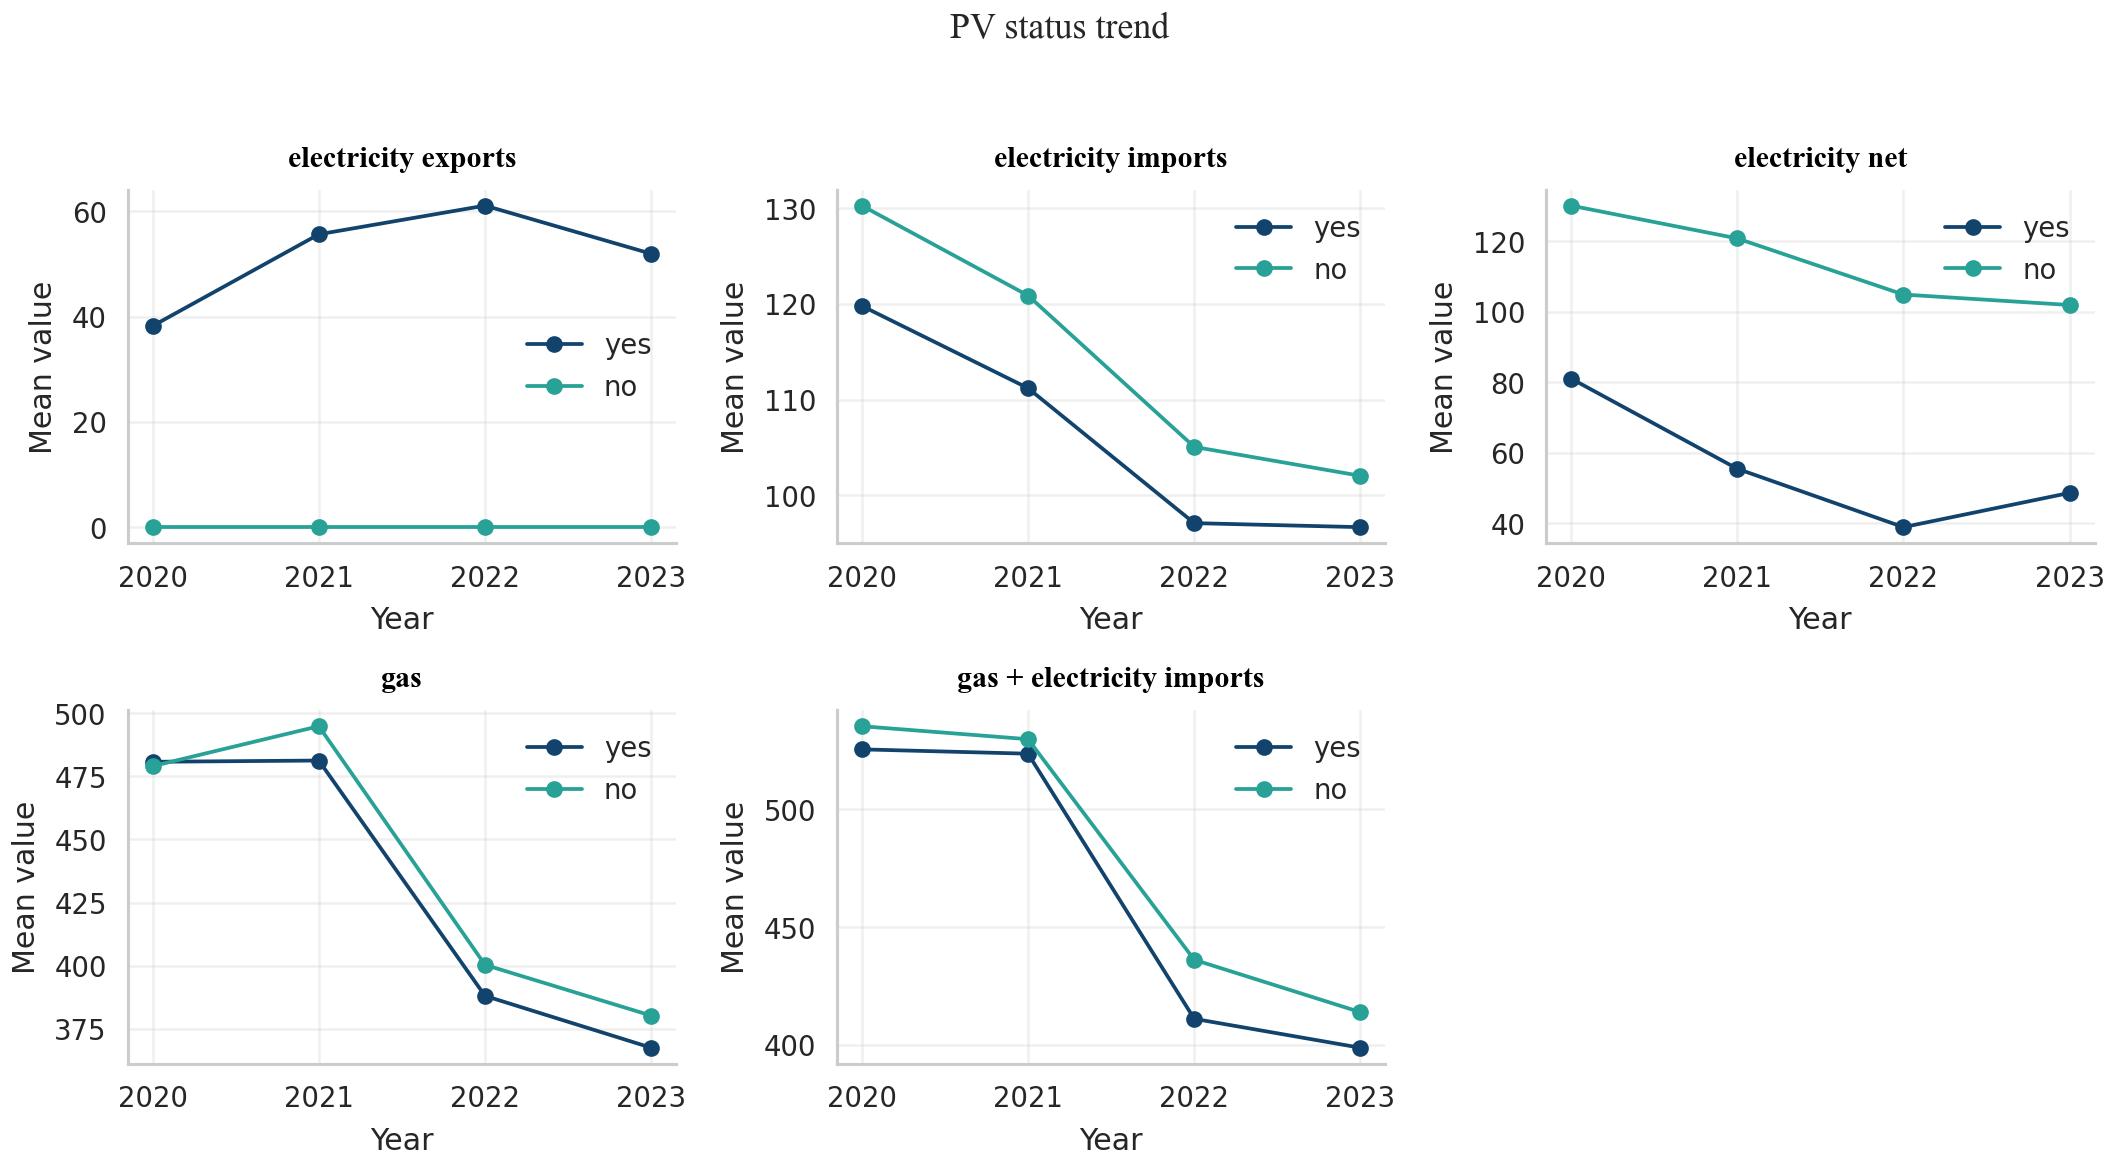


✅ analysis complete. figures saved to: /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/figures


In [ ]:
# -*- coding: utf-8 -*-
"""SERL multi-year energy analysis — merged & deduplicated

Combines:
1) Comprehensive quantity analysis (PV/heating, yearly trends, radial plots, bars, stats)
2) Quantity matrices (weekday vs weekend, PV status) + cross-year trend matrices

Enhancements:
- Single, DRY utilities & setup
- Pastel palette
- Times New Roman for headings/titles
"""

# =============================================================================
# setup & environment check
# =============================================================================

import os
import sys
import random
import json
import platform
from datetime import datetime
from pathlib import Path
import re
import math
from math import pi
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42  # keep runs deterministic enough
random.seed(SEED)

ENV_SNAPSHOT = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "seed": SEED,
}

# =============================================================================
# configuration
# =============================================================================

BASE_DIR = Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025")
DATA_DIR = BASE_DIR / "data" / "csv"
FIGURES_DIR = BASE_DIR / "figures"
REPRO_DIR = BASE_DIR / "repro"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPRO_DIR.mkdir(parents=True, exist_ok=True)

YEAR_FILES = {
    2020: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2020_aggregated_statistics.csv",
    2021: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2021_aggregated_statistics.csv",
    2022: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2022_aggregated_statistics.csv",
    2023: DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2023_aggregated_statistics.csv",
}

# Pastel palette + Times New Roman headings
COLORS = [
    "#12436D",  # dark blue
    "#28A197",  # teal
    "#821952",  # maroon
    "#F47130",  # orange
    "#8B8888",  # dark gray
    "#A285D1",  # lavender
    "#7DA7D9",  # periwinkle
    "#E6A0B6",  # blush
    "#9B72CF",  # orchid
    "#A7C7A5",  # sage
]
TITLE_FONT = "Times New Roman"

# clean white theme 🌿
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette(COLORS)
plt.rcParams.update({
    "figure.figsize": (12, 7),
    "font.family": "DejaVu Sans",  # body text
    "font.serif": [TITLE_FONT, "Times", "Times New Roman"],
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "grid.alpha": 0.2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlelocation": "center",
    "axes.titlepad": 14.0,
    "axes.labelpad": 8.0,
})

# =============================================================================
# utilities
# =============================================================================

def write_env_snapshot(path: Path) -> None:
    """Write environment snapshot for reproducibility."""
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(ENV_SNAPSHOT, f, indent=2)
    except Exception as e:
        print(f"could not write env snapshot: {e}")


def sanitize_filename(name: str) -> str:
    """Return a filesystem-safe version of `name`."""
    return re.sub(r'[\\/*?:"<>|]', "_", str(name))


def _savefig(fig: plt.Figure, name: str) -> None:
    """Save figure to FIGURES_DIR with a clean filename."""
    safe = sanitize_filename(name)
    out = FIGURES_DIR / f"{safe}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")


def _format_time_axis(ax: plt.Axes) -> None:
    """Standardize x ticks to 00:00–24:00, 4h step."""
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 4)])


def _title(ax: plt.Axes, text: str) -> None:
    """Apply Times New Roman to titles consistently."""
    ax.set_title(text, fontfamily="serif")  # uses font.serif list with Times


def _suptitle(fig: plt.Figure, text: str, **kwargs) -> None:
    fig.suptitle(text, fontfamily="serif", **kwargs)


def _palette(n: int) -> List[tuple]:
    return sns.color_palette(n_colors=n)

# =============================================================================
# data loading & preprocessing
# =============================================================================

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and enrich a SERL aggregated dataframe."""
    dfc = df.copy()

    # normalize text categories to lowercase for stable grouping.
    cat_cols = [
        "quantity",
        "unit",
        "weekday_weekend",
        "segmentation_variable_1",
        "segment_1_value",
        "segmentation_variable_2",
        "segment_2_value",
        "segmentation_variable_3",
        "segment_3_value",
    ]
    for col in cat_cols:
        if col in dfc.columns:
            dfc[col] = dfc[col].astype(str).str.strip().str.lower()

    # parse time from 'summary_time' like 'HH:MM' to hour / minute / half_hour.
    if "summary_time" in dfc.columns:
        tp = dfc["summary_time"].astype(str).str.extract(r"(\d{1,2}):(\d{2})")
        dfc["hour"] = pd.to_numeric(tp[0], errors="coerce")
        dfc["minute"] = pd.to_numeric(tp[1], errors="coerce")
        dfc["half_hour"] = dfc["hour"] * 2 + (dfc["minute"] >= 30).astype(int)
        dfc["time_index"] = dfc["half_hour"] / 2.0  # hours since midnight for plots

    # coerce known numeric columns
    num_cols = ["mean", "median", "standard_deviation", "mean_temp", "mean_solar", "n_rounded"]
    for col in num_cols:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc


def load_all_years() -> pd.DataFrame:
    """Load 2020–2023 csvs, tag with year, and preprocess."""
    dfs = []
    for year, path in YEAR_FILES.items():
        if not path.exists():
            print(f"⚠️ missing file for {year}: {path}")
            continue
        dfi = pd.read_csv(path)
        dfi["year"] = int(year)
        dfs.append(dfi)

    if not dfs:
        raise FileNotFoundError("no SERL csv files found — check DATA_DIR paths")

    df_all = pd.concat(dfs, ignore_index=True)
    df_all = preprocess_data(df_all)
    print(f"✅ combined shape: {df_all.shape}")
    return df_all

# =============================================================================
# analysis functions — shared
# =============================================================================

def unique_quantities(df: pd.DataFrame, verbose: bool = True) -> List[str]:
    qs = sorted(df["quantity"].dropna().unique().tolist())
    if verbose:
        print("Unique quantities in the dataset:")
        for i, q in enumerate(qs, 1):
            print(f"{i}. {q}")
    return qs

# =============================================================================
# analysis functions — part 1 (comprehensive quantity analysis)
# =============================================================================

def plot_quantity_pv_heating_analysis(df: pd.DataFrame, quantities: List[str]) -> None:
    """Plot how quantities vary with PV presence and heating type."""
    pv_heating_df = df[
        (df["segmentation_variable_1"] == "primary_space_heating_fuel") &
        (df["segmentation_variable_2"] == "has_pv") &
        (df["quantity"].isin(quantities))
    ].copy()

    if pv_heating_df.empty:
        print("No data with PV and heating type segmentation")
        return

    pv_heating_df["weighted_mean"] = pv_heating_df["mean"] * pv_heating_df["n_rounded"].fillna(0)
    grouped = pv_heating_df.groupby(["quantity", "segment_1_value", "segment_2_value"]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()

    grouped["mean_value"] = grouped["total_weighted"] / grouped["total_n"].replace(0, np.nan)

    n_quantities = len(quantities)
    ncols = min(3, n_quantities)
    nrows = math.ceil(n_quantities / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))
    axes = axes.flatten() if n_quantities > 1 else [axes]

    for i, quantity in enumerate(quantities):
        if i >= len(axes):
            break
        ax = axes[i]
        q_data = grouped[grouped["quantity"] == quantity]
        pivot_data = q_data.pivot_table(
            index="segment_1_value",
            columns="segment_2_value",
            values="mean_value"
        )

        # Use current palette
        pivot_data.plot(kind="bar", ax=ax, alpha=0.9)
        _title(ax, f"{quantity.title()}\nby Heating Type and PV Presence")
        ax.set_xlabel("Heating type")
        ax.set_ylabel("Mean value")
        ax.legend(title="PV presence")
        ax.tick_params(axis='x', rotation=45)

    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    _savefig(fig, "quantity_pv_heating_analysis")
    plt.show()


def plot_yearly_matrix_trends(df: pd.DataFrame, quantities: List[str]) -> None:
    """Plot matrix of line graphs showing yearly trends for all quantities."""
    df = df.copy()
    df["weighted_mean"] = df["mean"] * df["n_rounded"].fillna(0)
    yearly_trends = df.groupby(["year", "quantity"]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()

    yearly_trends["mean_value"] = yearly_trends["total_weighted"] / yearly_trends["total_n"].replace(0, np.nan)
    yearly_trends = yearly_trends[yearly_trends["quantity"].isin(quantities)]

    n_quantities = len(quantities)
    ncols = min(3, n_quantities)
    nrows = math.ceil(n_quantities / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = axes.flatten() if n_quantities > 1 else [axes]

    for i, quantity in enumerate(quantities):
        if i >= len(axes):
            break
        ax = axes[i]
        q_data = yearly_trends[yearly_trends["quantity"] == quantity]
        ax.plot(q_data["year"], q_data["mean_value"], marker="o", linewidth=2.5)
        _title(ax, f"{quantity.title()} yearly trend")
        ax.set_xlabel("Year")
        ax.set_ylabel("Mean value")
        ax.grid(True, alpha=0.3)

    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    _savefig(fig, "yearly_matrix_trends")
    plt.show()


def plot_radial_quantities(df: pd.DataFrame, quantities: List[str], year: int | None = None) -> None:
    """Create radial (radar) plot comparing normalized mean values across quantities."""
    if year is not None:
        plot_df = df[df["year"] == year]
    else:
        plot_df = df.copy()
    plot_df = plot_df[plot_df["quantity"].isin(quantities)]

    plot_df["weighted_mean"] = plot_df["mean"] * plot_df["n_rounded"].fillna(0)
    quantity_means = plot_df.groupby("quantity").agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()
    quantity_means["mean_value"] = quantity_means["total_weighted"] / quantity_means["total_n"].replace(0, np.nan)

    categories = quantity_means["quantity"].tolist()
    if not categories:
        print("No data available for radar plot.")
        return
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    max_val = quantity_means["mean_value"].max()
    values = (quantity_means["mean_value"] / max_val).tolist()
    values += values[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
    plt.ylim(0, 1)

    # Use first palette color for line/fill
    c = _palette(1)[0]
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.15)

    year_title = f" - {year}" if year else ""
    plt.title(f"Energy quantity comparison{year_title}", fontfamily="serif", size=16, y=1.08)

    plt.tight_layout()
    _savefig(fig, f"radial_quantities{'_' + str(year) if year else ''}")
    plt.show()


def plot_quantity_comparison_bars(df: pd.DataFrame, quantities: List[str]) -> None:
    """Grouped bar charts comparing quantities across years."""
    df = df.copy()
    df["weighted_mean"] = df["mean"] * df["n_rounded"].fillna(0)
    yearly_trends = df.groupby(["year", "quantity"]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()

    yearly_trends["mean_value"] = yearly_trends["total_weighted"] / yearly_trends["total_n"].replace(0, np.nan)
    yearly_trends = yearly_trends[yearly_trends["quantity"].isin(quantities)]

    fig, ax = plt.subplots(figsize=(14, 8))

    years = sorted(yearly_trends["year"].unique())
    n_years = len(years)
    n_quantities = len(quantities)

    bar_width = 0.8 / max(1, n_quantities)
    x_pos = np.arange(n_years)

    colors = _palette(n_quantities)
    for i, quantity in enumerate(quantities):
        q_data = yearly_trends[yearly_trends["quantity"] == quantity]
        values = [
            (q_data[q_data["year"] == y]["mean_value"].values[0]
             if not q_data[q_data["year"] == y].empty else 0)
            for y in years
        ]
        ax.bar(x_pos + i * bar_width, values, bar_width, label=quantity, alpha=0.9)

    ax.set_xlabel("Year")
    ax.set_ylabel("Mean value")
    _title(ax, "Energy quantity comparison by year")
    ax.set_xticks(x_pos + bar_width * (n_quantities - 1) / 2)
    ax.set_xticklabels(years)
    ax.legend()
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    _savefig(fig, "quantity_comparison_bars")
    plt.show()


def generate_descriptive_stats(df: pd.DataFrame, quantities: List[str]) -> None:
    """Generate descriptive statistics for quantities."""
    print("=" * 60)
    print("DESCRIPTIVE STATISTICS FOR ENERGY QUANTITIES")
    print("=" * 60)

    for quantity in quantities:
        q_data = df[df["quantity"] == quantity]
        if q_data.empty:
            print(f"\n{quantity.upper()}: no records")
            continue

        print(f"\n{quantity.upper()}:")
        print(f"  Number of records: {len(q_data):,}")
        print(f"  Mean of means: {q_data['mean'].mean():.4f}")
        print(f"  Median of means: {q_data['mean'].median():.4f}")
        print(f"  Std dev of means: {q_data['mean'].std():.4f}")
        print(f"  Min mean: {q_data['mean'].min():.4f}")
        print(f"  Max mean: {q_data['mean'].max():.4f}")

        yearly_stats = q_data.groupby("year")["mean"].agg(["mean", "std", "count"]).reset_index()
        print("  Yearly breakdown:")
        for _, row in yearly_stats.iterrows():
            print(f"    {int(row['year'])}: mean={row['mean']:.4f}, std={row['std']:.4f}, n={int(row['count'])}")

# =============================================================================
# analysis functions — part 2 (quantity matrices & cross-year trends)
# =============================================================================

def create_weekday_weekend_matrix(df: pd.DataFrame, quantity: str, years: List[int]) -> None:
    """Create a matrix of weekday vs weekend comparisons across years for a quantity."""
    ww_df = df[df["weekday_weekend"].isin(["weekday", "weekend"])].copy()
    if ww_df.empty:
        print(f"No weekday/weekend data for {quantity}")
        return

    ww_df["weighted_mean"] = ww_df["mean"] * ww_df["n_rounded"].fillna(0)
    yearly_data = ww_df.groupby(["year", "weekday_weekend"]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()
    yearly_data["mean_value"] = yearly_data["total_weighted"] / yearly_data["total_n"].replace(0, np.nan)

    n_years = len(years)
    ncols = min(3, n_years)
    nrows = math.ceil(n_years / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = axes.flatten() if n_years > 1 else [axes]

    colors = _palette(2)
    for i, year in enumerate(years):
        if i >= len(axes):
            break
        ax = axes[i]
        year_data = yearly_data[yearly_data["year"] == year]

        weekday_data = year_data[year_data["weekday_weekend"] == "weekday"]
        weekend_data = year_data[yearly_data["weekday_weekend"] == "weekend"]

        labels = ["Weekday", "Weekend"]
        values = [
            weekday_data["mean_value"].values[0] if not weekday_data.empty else 0,
            weekend_data["mean_value"].values[0] if not weekend_data.empty else 0,
        ]
        ax.bar(labels, values, alpha=0.9)
        _title(ax, f"{year}")
        ax.set_ylabel(quantity)
        ax.grid(True, axis='y', alpha=0.3)
        for j, v in enumerate(values):
            ax.text(j, v, f"{v:.2f}", ha='center', va='bottom')

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    _suptitle(fig, f"Weekday vs weekend: {quantity}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    _savefig(fig, f"weekday_weekend_matrix_{sanitize_filename(quantity)}")
    plt.show()


def create_pv_status_matrix(df: pd.DataFrame, quantity: str, years: List[int]) -> None:
    """Create a matrix of PV status comparisons across years for a quantity."""
    pv_df = df[df["segmentation_variable_2"] == "has_pv"].copy()
    if pv_df.empty:
        print(f"No PV status data for {quantity}")
        return

    pv_df["weighted_mean"] = pv_df["mean"] * pv_df["n_rounded"].fillna(0)
    yearly_data = pv_df.groupby(["year", "segment_2_value"]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()
    yearly_data["mean_value"] = yearly_data["total_weighted"] / yearly_data["total_n"].replace(0, np.nan)

    n_years = len(years)
    ncols = min(3, n_years)
    nrows = math.ceil(n_years / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = axes.flatten() if n_years > 1 else [axes]

    for i, year in enumerate(years):
        if i >= len(axes):
            break
        ax = axes[i]
        year_data = yearly_data[yearly_data["year"] == year]

        pv_yes_data = year_data[year_data["segment_2_value"] == "yes"]
        pv_no_data = year_data[year_data["segment_2_value"] == "no"]

        labels = ["Has PV", "No PV"]
        values = [
            pv_yes_data["mean_value"].values[0] if not pv_yes_data.empty else 0,
            pv_no_data["mean_value"].values[0] if not pv_no_data.empty else 0,
        ]
        ax.bar(labels, values, alpha=0.9)
        _title(ax, f"{year}")
        ax.set_ylabel(quantity)
        ax.grid(True, axis='y', alpha=0.3)
        for j, v in enumerate(values):
            ax.text(j, v, f"{v:.2f}", ha='center', va='bottom')

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    _suptitle(fig, f"PV status: {quantity}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    _savefig(fig, f"pv_status_matrix_{sanitize_filename(quantity)}")
    plt.show()


def create_trend_matrix(
    df: pd.DataFrame,
    quantities: List[str],
    years: List[int],
    category_col: str,
    categories: List[str],
    title: str,
    filter_condition: pd.Series | None = None,
) -> None:
    """Create a matrix of trends across years for different quantities."""
    plot_df = df[filter_condition].copy() if filter_condition is not None else df.copy()

    plot_df["weighted_mean"] = plot_df["mean"] * plot_df["n_rounded"].fillna(0)
    yearly_data = plot_df.groupby(["year", "quantity", category_col]).agg(
        total_weighted=("weighted_mean", "sum"),
        total_n=("n_rounded", "sum")
    ).reset_index()
    yearly_data["mean_value"] = yearly_data["total_weighted"] / yearly_data["total_n"].replace(0, np.nan)

    n_quantities = len(quantities)
    ncols = min(3, n_quantities)
    nrows = math.ceil(n_quantities / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = axes.flatten() if n_quantities > 1 else [axes]

    for i, quantity in enumerate(quantities):
        if i >= len(axes):
            break
        ax = axes[i]
        q_data = yearly_data[yearly_data["quantity"] == quantity]
        for category in categories:
            cat_data = q_data[q_data[category_col] == category]
            if not cat_data.empty:
                ax.plot(cat_data["year"], cat_data["mean_value"], marker="o", label=category)
        _title(ax, quantity)
        ax.set_xlabel("Year")
        ax.set_ylabel("Mean value")
        ax.legend()
        ax.grid(True, alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    _suptitle(fig, title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    _savefig(fig, f"cross_year_{sanitize_filename(title)}")
    plt.show()


def create_quantity_matrices(df: pd.DataFrame) -> None:
    """Create weekday/weekend and PV status matrices for each unique quantity."""
    quantities = unique_quantities(df, verbose=False)
    years = sorted(df["year"].dropna().unique().tolist())

    print(f"Found {len(quantities)} unique quantities: {quantities}")
    for q in quantities:
        print(f"Processing quantity: {q}")
        q_df = df[df["quantity"] == q].copy()
        create_weekday_weekend_matrix(q_df, q, years)
        create_pv_status_matrix(q_df, q, years)


def create_cross_year_comparison(df: pd.DataFrame) -> None:
    """Create cross-year comparison matrices for all quantities."""
    quantities = unique_quantities(df, verbose=False)
    years = sorted(df["year"].dropna().unique().tolist())

    # Weekday/weekend trend across years
    create_trend_matrix(
        df,
        quantities,
        years,
        category_col="weekday_weekend",
        categories=["weekday", "weekend"],
        title="Weekday vs Weekend trend",
    )

    # PV status trend across years (filter to has_pv segmentation)
    create_trend_matrix(
        df,
        quantities,
        years,
        category_col="segment_2_value",
        categories=["yes", "no"],
        title="PV status trend",
        filter_condition=(df["segmentation_variable_2"] == "has_pv"),
    )

# =============================================================================
# main orchestration
# =============================================================================

RUN_MATRICES_FOR_ALL_QUANTITIES = True  # set False if you want only the comprehensive analysis


def main() -> None:
    """Run the merged analysis end-to-end."""
    write_env_snapshot(REPRO_DIR / "env_snapshot.json")

    print("📂 loading & preprocessing SERL data...")
    df = load_all_years()

    years = sorted(df["year"].dropna().unique().tolist())

    # Identify quantities
    print("\n🔍 Identifying all unique quantities...")
    qs = unique_quantities(df)

    # Focus set (auto-filter to what's present)
    energy_quantities = [
        "electricity imports",
        "electricity exports",
        "electricity net",
        "gas",
        "gas + electricity imports",
    ]
    energy_quantities = [q for q in energy_quantities if q in qs]

    # PV + heating analysis
    print("\n📊 Analyzing relationships with PV and heating types...")
    if energy_quantities:
        plot_quantity_pv_heating_analysis(df, energy_quantities)
    else:
        print("No target energy quantities available for PV/heating analysis.")

    # Yearly trends matrix
    print("\n📈 Creating matrix of yearly trends...")
    if energy_quantities:
        plot_yearly_matrix_trends(df, energy_quantities)

    # Radial plots per year + combined
    print("\n🌀 Generating radial plots...")
    for year in years:
        plot_radial_quantities(df, energy_quantities, year)
    plot_radial_quantities(df, energy_quantities)

    # Yearly bar comparisons
    print("\n📊 Creating bar chart comparisons...")
    if energy_quantities:
        plot_quantity_comparison_bars(df, energy_quantities)

    # Descriptive stats
    print("\n📋 Generating descriptive statistics...")
    if energy_quantities:
        generate_descriptive_stats(df, energy_quantities)

    # Quantity matrices & cross-year comparisons
    if RUN_MATRICES_FOR_ALL_QUANTITIES:
        print("\n🧩 Creating matrices for each quantity...")
        create_quantity_matrices(df)

        print("\n🪜 Creating cross-year comparison matrices...")
        create_cross_year_comparison(df)

    print(f"\n✅ analysis complete. figures saved to: {FIGURES_DIR}")


if __name__ == "__main__":
    # small guard so you can import functions without side effects
    main()


In [ ]:
# -*- coding: utf-8 -*-
"""SERL Energy Dashboard - VSCode Inline Version"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Set up matplotlib for inline display
%matplotlib inline

# Use the same setup and data loading as your original code
class SERLAnalysisDashboard:
    def __init__(self):
        self.BASE_DIR = Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025")
        self.DATA_DIR = self.BASE_DIR / "data" / "csv"
        
        self.YEAR_FILES = {
            2020: self.DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2020_aggregated_statistics.csv",
            2021: self.DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2021_aggregated_statistics.csv",
            2022: self.DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2022_aggregated_statistics.csv",
            2023: self.DATA_DIR / "serl_half_hourly_energy_use_in_gb_domestic_buildings_2023_aggregated_statistics.csv",
        }
        
        # Colors for visualizations
        self.COLORS = [
            "#12436D", "#28A197", "#821952", "#F47130", "#8B8888",
            "#A285D1", "#7DA7D9", "#E6A0B6", "#9B72CF", "#A7C7A5"
        ]
        
        # Load data
        self.df = self.load_all_years()
        self.quantities = sorted(self.df["quantity"].dropna().unique().tolist())
        self.years = sorted(self.df["year"].dropna().unique().tolist())
        
        # Set up plotting style
        plt.style.use('default')
        plt.rcParams.update({
            "figure.figsize": (12, 7),
            "font.family": "DejaVu Sans",
            "font.serif": ["Times New Roman", "Times", "serif"],
            "axes.facecolor": "white",
            "figure.facecolor": "white",
            "savefig.facecolor": "white",
            "grid.alpha": 0.2,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.titleweight": "bold",
            "axes.titlelocation": "center",
            "axes.titlepad": 14.0,
            "axes.labelpad": 8.0,
        })
    
    def preprocess_data(self, df):
        dfc = df.copy()
        cat_cols = [
            "quantity", "unit", "weekday_weekend", "segmentation_variable_1",
            "segment_1_value", "segmentation_variable_2", "segment_2_value",
            "segmentation_variable_3", "segment_3_value",
        ]
        for col in cat_cols:
            if col in dfc.columns:
                dfc[col] = dfc[col].astype(str).str.strip().str.lower()

        if "summary_time" in dfc.columns:
            tp = dfc["summary_time"].astype(str).str.extract(r"(\d{1,2}):(\d{2})")
            dfc["hour"] = pd.to_numeric(tp[0], errors="coerce")
            dfc["minute"] = pd.to_numeric(tp[1], errors="coerce")
            dfc["half_hour"] = dfc["hour"] * 2 + (dfc["minute"] >= 30).astype(int)
            dfc["time_index"] = dfc["half_hour"] / 2.0

        num_cols = ["mean", "median", "standard_deviation", "mean_temp", "mean_solar", "n_rounded"]
        for col in num_cols:
            if col in dfc.columns:
                dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

        return dfc

    def load_all_years(self):
        dfs = []
        for year, path in self.YEAR_FILES.items():
            if not path.exists():
                print(f"⚠️ missing file for {year}: {path}")
                continue
            dfi = pd.read_csv(path)
            dfi["year"] = int(year)
            dfs.append(dfi)

        if not dfs:
            raise FileNotFoundError("no SERL csv files found — check DATA_DIR paths")

        df_all = pd.concat(dfs, ignore_index=True)
        df_all = self.preprocess_data(df_all)
        print(f"✅ combined shape: {df_all.shape}")
        return df_all
    
    def create_time_series_plot(self, quantity, years):
        # Filter data
        filtered_df = self.df[(self.df['quantity'] == quantity) & (self.df['year'].isin(years))]
        
        # Prepare data for time series
        filtered_df = filtered_df.copy()
        filtered_df['weighted_mean'] = filtered_df['mean'] * filtered_df['n_rounded'].fillna(0)
        
        # Group by time and year
        time_data = filtered_df.groupby(['time_index', 'year']).agg(
            total_weighted=('weighted_mean', 'sum'),
            total_n=('n_rounded', 'sum')
        ).reset_index()
        time_data['mean_value'] = time_data['total_weighted'] / time_data['total_n'].replace(0, np.nan)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for year in years:
            year_data = time_data[time_data['year'] == year]
            ax.plot(year_data['time_index'], year_data['mean_value'], label=str(year), linewidth=2.5)
        
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel(quantity.title())
        ax.set_title(f'Hourly {quantity.title()} Profile by Year', fontfamily='serif')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.set_xticks(range(0, 25, 4))
        ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 4)])
        
        plt.tight_layout()
        return fig
    
    def create_comparison_plot(self, quantity, years, analysis_type):
        filtered_df = self.df[(self.df['quantity'] == quantity) & (self.df['year'].isin(years))]
        filtered_df = filtered_df.copy()
        filtered_df['weighted_mean'] = filtered_df['mean'] * filtered_df['n_rounded'].fillna(0)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if analysis_type == 'Yearly Trends':
            # Yearly comparison
            yearly_data = filtered_df.groupby('year').agg(
                total_weighted=('weighted_mean', 'sum'),
                total_n=('n_rounded', 'sum')
            ).reset_index()
            yearly_data['mean_value'] = yearly_data['total_weighted'] / yearly_data['total_n'].replace(0, np.nan)
            
            ax.bar(yearly_data['year'], yearly_data['mean_value'], color=self.COLORS[:len(yearly_data)])
            ax.set_xlabel('Year')
            ax.set_ylabel(quantity.title())
            ax.set_title(f'{quantity.title()} by Year', fontfamily='serif')
            
            # Add value labels on bars
            for i, v in enumerate(yearly_data['mean_value']):
                ax.text(yearly_data['year'].iloc[i], v, f'{v:.2f}', ha='center', va='bottom')
                
        elif analysis_type == 'Weekday vs Weekend':
            # Weekday vs weekend
            ww_data = filtered_df[filtered_df['weekday_weekend'].isin(['weekday', 'weekend'])].copy()
            if not ww_data.empty:
                ww_grouped = ww_data.groupby(['year', 'weekday_weekend']).agg(
                    total_weighted=('weighted_mean', 'sum'),
                    total_n=('n_rounded', 'sum')
                ).reset_index()
                ww_grouped['mean_value'] = ww_grouped['total_weighted'] / ww_grouped['total_n'].replace(0, np.nan)
                
                # Pivot for grouped bar chart
                pivot_data = ww_grouped.pivot(index='year', columns='weekday_weekend', values='mean_value')
                
                x = np.arange(len(years))
                width = 0.35
                
                ax.bar(x - width/2, pivot_data['weekday'], width, label='Weekday')
                ax.bar(x + width/2, pivot_data['weekend'], width, label='Weekend')
                
                ax.set_xlabel('Year')
                ax.set_ylabel(quantity.title())
                ax.set_title(f'Weekday vs Weekend {quantity.title()}', fontfamily='serif')
                ax.set_xticks(x)
                ax.set_xticklabels(years)
                ax.legend()
            else:
                ax.text(0.5, 0.5, 'No weekday/weekend data available', 
                       ha='center', va='center', transform=ax.transAxes)
                
        elif analysis_type == 'PV Status Comparison':
            # PV status comparison
            pv_data = filtered_df[filtered_df['segmentation_variable_2'] == 'has_pv'].copy()
            if not pv_data.empty:
                pv_grouped = pv_data.groupby(['year', 'segment_2_value']).agg(
                    total_weighted=('weighted_mean', 'sum'),
                    total_n=('n_rounded', 'sum')
                ).reset_index()
                pv_grouped['mean_value'] = pv_grouped['total_weighted'] / pv_grouped['total_n'].replace(0, np.nan)
                
                # Pivot for grouped bar chart
                pivot_data = pv_grouped.pivot(index='year', columns='segment_2_value', values='mean_value')
                
                x = np.arange(len(years))
                width = 0.35
                
                if 'yes' in pivot_data.columns and 'no' in pivot_data.columns:
                    ax.bar(x - width/2, pivot_data['yes'], width, label='Has PV')
                    ax.bar(x + width/2, pivot_data['no'], width, label='No PV')
                elif 'yes' in pivot_data.columns:
                    ax.bar(x, pivot_data['yes'], width, label='Has PV')
                elif 'no' in pivot_data.columns:
                    ax.bar(x, pivot_data['no'], width, label='No PV')
                
                ax.set_xlabel('Year')
                ax.set_ylabel(quantity.title())
                ax.set_title(f'PV Status Comparison for {quantity.title()}', fontfamily='serif')
                ax.set_xticks(x)
                ax.set_xticklabels(years)
                ax.legend()
            else:
                ax.text(0.5, 0.5, 'No PV data available', 
                       ha='center', va='center', transform=ax.transAxes)
                
        elif analysis_type == 'Heating Type Comparison':
            # Heating type comparison
            heating_data = filtered_df[filtered_df['segmentation_variable_1'] == 'primary_space_heating_fuel'].copy()
            if not heating_data.empty:
                heating_grouped = heating_data.groupby(['year', 'segment_1_value']).agg(
                    total_weighted=('weighted_mean', 'sum'),
                    total_n=('n_rounded', 'sum')
                ).reset_index()
                heating_grouped['mean_value'] = heating_grouped['total_weighted'] / heating_grouped['total_n'].replace(0, np.nan)
                
                # Get top heating types
                top_heating = heating_grouped.groupby('segment_1_value')['mean_value'].mean().nlargest(5).index
                heating_grouped = heating_grouped[heating_grouped['segment_1_value'].isin(top_heating)]
                
                # Pivot for grouped bar chart
                pivot_data = heating_grouped.pivot(index='year', columns='segment_1_value', values='mean_value')
                
                x = np.arange(len(years))
                width = 0.8 / len(pivot_data.columns)
                
                for i, col in enumerate(pivot_data.columns):
                    offset = width * i - width * (len(pivot_data.columns) - 1) / 2
                    ax.bar(x + offset, pivot_data[col], width, label=col)
                
                ax.set_xlabel('Year')
                ax.set_ylabel(quantity.title())
                ax.set_title(f'Heating Type Comparison for {quantity.title()}', fontfamily='serif')
                ax.set_xticks(x)
                ax.set_xticklabels(years)
                ax.legend()
            else:
                ax.text(0.5, 0.5, 'No heating data available', 
                       ha='center', va='center', transform=ax.transAxes)
        
        plt.tight_layout()
        return fig
    
    def create_stats_table(self, quantity, years):
        filtered_df = self.df[(self.df['quantity'] == quantity) & (self.df['year'].isin(years))]
        
        if filtered_df.empty:
            return "No data available for the selected filters."
        
        # Calculate statistics
        stats = filtered_df.groupby('year')['mean'].agg(['mean', 'std', 'count']).reset_index()
        stats.columns = ['Year', 'Mean', 'Std Dev', 'Count']
        
        # Create HTML table
        html_table = "<table border='1' style='width:100%; border-collapse: collapse;'>"
        html_table += "<tr style='background-color: #f2f2f2;'><th>Year</th><th>Mean</th><th>Std Dev</th><th>Count</th></tr>"
        
        for _, row in stats.iterrows():
            html_table += f"<tr><td>{int(row['Year'])}</td><td>{row['Mean']:.4f}</td><td>{row['Std Dev']:.4f}</td><td>{int(row['Count'])}</td></tr>"
        
        html_table += "</table>"
        return html_table
    
    def create_dashboard(self):
        # Create widgets
        quantity_dropdown = widgets.Dropdown(
            options=self.quantities,
            value='electricity imports',
            description='Quantity:',
            style={'description_width': 'initial'}
        )
        
        year_select = widgets.SelectMultiple(
            options=self.years,
            value=self.years,
            description='Years:',
            style={'description_width': 'initial'}
        )
        
        analysis_dropdown = widgets.Dropdown(
            options=['Yearly Trends', 'Weekday vs Weekend', 'PV Status Comparison', 'Heating Type Comparison'],
            value='Yearly Trends',
            description='Analysis:',
            style={'description_width': 'initial'}
        )
        
        # Create output areas
        time_series_output = widgets.Output()
        comparison_output = widgets.Output()
        stats_output = widgets.Output()
        
        # Define update function
        def update_dashboard(quantity, years, analysis_type):
            # Clear previous outputs
            time_series_output.clear_output()
            comparison_output.clear_output()
            stats_output.clear_output()
            
            # Update time series plot
            with time_series_output:
                fig1 = self.create_time_series_plot(quantity, years)
                plt.show()
            
            # Update comparison plot
            with comparison_output:
                fig2 = self.create_comparison_plot(quantity, years, analysis_type)
                plt.show()
            
            # Update stats table
            with stats_output:
                stats_html = self.create_stats_table(quantity, years)
                display(HTML(stats_html))
        
        # Set up interactive widget
        dashboard = interactive(
            update_dashboard,
            quantity=quantity_dropdown,
            years=year_select,
            analysis_type=analysis_dropdown
        )
        
        # Display the dashboard
        display(HTML("<h1 style='font-family: Times New Roman, serif;'>SERL Energy Data Analysis Dashboard</h1>"))
        display(HTML("<p>Interactive dashboard for exploring SERL energy data from 2020-2023</p>"))
        display(dashboard)
        display(HTML("<h2 style='font-family: Times New Roman, serif;'>Time Series Analysis</h2>"))
        display(time_series_output)
        display(HTML("<h2 style='font-family: Times New Roman, serif;'>Comparative Analysis</h2>"))
        display(comparison_output)
        display(HTML("<h2 style='font-family: Times New Roman, serif;'>Statistical Summary</h2>"))
        display(stats_output)
        
        # Trigger initial update
        update_dashboard(quantity_dropdown.value, year_select.value, analysis_dropdown.value)

# Create and display the dashboard
dashboard = SERLAnalysisDashboard()

# For VSCode compatibility, we'll use a simpler approach
def create_simple_dashboard():
    """Create a simplified dashboard for VSCode compatibility"""
    print("SERL Energy Data Analysis Dashboard")
    print("Interactive dashboard for exploring SERL energy data from 2020-2023")
    
    # Create widgets
    quantity = widgets.Dropdown(
        options=dashboard.quantities,
        value='electricity imports',
        description='Quantity:',
        style={'description_width': 'initial'}
    )
    
    years = widgets.SelectMultiple(
        options=dashboard.years,
        value=dashboard.years,
        description='Years:',
        style={'description_width': 'initial'}
    )
    
    analysis_type = widgets.Dropdown(
        options=['Yearly Trends', 'Weekday vs Weekend', 'PV Status Comparison', 'Heating Type Comparison'],
        value='Yearly Trends',
        description='Analysis:',
        style={'description_width': 'initial'}
    )
    
    # Display widgets
    display(quantity)
    display(years)
    display(analysis_type)
    
    # Create output areas
    out1 = widgets.Output()
    out2 = widgets.Output()
    out3 = widgets.Output()
    
    display(widgets.HTML("<h2>Time Series Analysis</h2>"))
    display(out1)
    display(widgets.HTML("<h2>Comparative Analysis</h2>"))
    display(out2)
    display(widgets.HTML("<h2>Statistical Summary</h2>"))
    display(out3)
    
    # Define update function
    def on_change(change):
        with out1:
            out1.clear_output()
            fig1 = dashboard.create_time_series_plot(quantity.value, years.value)
            plt.show()
        
        with out2:
            out2.clear_output()
            fig2 = dashboard.create_comparison_plot(quantity.value, years.value, analysis_type.value)
            plt.show()
        
        with out3:
            out3.clear_output()
            stats_html = dashboard.create_stats_table(quantity.value, years.value)
            display(HTML(stats_html))
    
    # Set up observers
    quantity.observe(on_change, names='value')
    years.observe(on_change, names='value')
    analysis_type.observe(on_change, names='value')
    
    # Initial update
    on_change(None)

# Use the simplified dashboard for better VSCode compatibility
create_simple_dashboard()

✅ combined shape: (1961280, 26)
SERL Energy Data Analysis Dashboard
Interactive dashboard for exploring SERL energy data from 2020-2023


Dropdown(description='Quantity:', index=1, options=('electricity exports', 'electricity imports', 'electricity…

SelectMultiple(description='Years:', index=(0, 1, 2, 3), options=(2020, 2021, 2022, 2023), style=DescriptionSt…

Dropdown(description='Analysis:', options=('Yearly Trends', 'Weekday vs Weekend', 'PV Status Comparison', 'Hea…

HTML(value='<h2>Time Series Analysis</h2>')

Output()

HTML(value='<h2>Comparative Analysis</h2>')

Output()

HTML(value='<h2>Statistical Summary</h2>')

Output()